In [1]:
import numpy as np
from sumolib import checkBinary
import math
import random
import time
import traci
import os
import sys
import psutil
import optparse
import keras
import json
import tensorflow as tf 
from keras.models import load_model

from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from keras.models import Model
from keras.layers import Input,Dense,Flatten,concatenate

os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

from datetime import datetime

Using TensorFlow backend.


# Vehicle class

In [2]:
class Vehicle:
    def __init__(self,vid,waiting_time,vtype):
        self.vid=vid
        self.waiting_time=waiting_time
        self.vtype=vtype

# Environment

In [3]:
class Sumo:
    
    RedYellowGreenStates=["rrrrrGGrrrrrrGGr","rGGrrrrrrGGrrrrr","rrrrrrrrrrgrGGGG","GGGGrrrrrrrrrrgr","rrgrGGGGrrrrrrrr","rrrrrrgrGGGGrrrr","GrrrrrGrGrrrrrGr","rrGrGrrrrrGrGrrr"]
    
    def __init__(self,K,Z):
        self.K=K # K,Z are tunable constants
        self.Z=Z
        self.nearby_vehicles=[[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
        self.count=0
        self.previous_eval=0
        if 'SUMO_HOME' in os.environ:
            tools=os.path.join(os.environ['SUMO_HOME'],'tools')
            sys.path.append(tools)
   
        else: 
            sys.exit("please declare environment variable 'SUMO_HOME'")
            
    def getSumoBinary(self,gui):
        if(gui):
            sumoBinary = checkBinary('sumo-gui')
        else:
            sumoBinary = checkBinary('sumo')
        return sumoBinary

    def updateWaitingTime(self):
        for i in range(1,5):
            for j in range(0,3):
                all_vehicles_on_lane = traci.lane.getLastStepVehicleIDs(str(i)+"si_"+str(j))
                
                for vehicle in self.nearby_vehicles[i-1][j]:# removing the vehicle from the memory which has went through the junction
                    if vehicle.vid not in all_vehicles_on_lane:
                        nearby_vehicle_on_lane=self.nearby_vehicles[i-1][j]
                        nearby_vehicle_on_lane.remove(vehicle)
                        self.nearby_vehicles[i-1][j]=nearby_vehicle_on_lane
                        
                for vehicle_id in all_vehicles_on_lane:
#                     getLanePosition outputs the position of the vehicle with respect to start end of the lane that is not the junction side
                    if(traci.vehicle.getLanePosition(vehicle_id)>=132):# consider vehicles which is 100M near or less to the junction lan length is 232
                        flag=1
                        for e,vehicle in enumerate(self.nearby_vehicles[i-1][j]):
                            if vehicle.vid==vehicle_id:#checking for exsisting vehicles
                                vehicle.waiting_time+=1
                                vehicle_list=self.nearby_vehicles[i-1][j]
                                vehicle_list[e]=vehicle# replace the old vehicle object with updated one
                                self.nearby_vehicles[i-1][j]=vehicle_list
                                flag=0
                                break
                        if(flag):
                            #register the new vehicle
                            new_vehicle_obj=Vehicle(vehicle_id,0,traci.vehicle.getTypeID(vehicle_id))
                            nearby_vehicle_on_lane=self.nearby_vehicles[i-1][j]
                            nearby_vehicle_on_lane.append(new_vehicle_obj)
                            self.nearby_vehicles[i-1][j]=nearby_vehicle_on_lane     
        return
    
    def getState(self):
        #onehot encode the phase index
        current_phase = self.RedYellowGreenStates.index(traci.trafficlight.getRedYellowGreenState('0'))
        num_classes = 8 # since we have 8 phases
        target = np.array(current_phase)
        phase_index = np.eye(num_classes)[target] #onehot encoding
        
        incomming_state=np.zeros([12,3]) # definition of a one row is (number of vehicles in that lane,average waiting time,emergency or not)
        outgoing_state=np.ones(4) #will get the negetive impact of this [Left,Right,Bottom,Top]
        total_waiting_time_distribution=[]# this will contain all the vehicle waiting times around the junction
        emg_waiting_time_distribution = []# this will contain maximum waiting time of emg for each lane
        for i in range(1,5):
            for j in range(0,3):

                #prepairing incomming state          
                emergency_waiting_time=0
                waiting_time_distribution=[]
                for vehicle in self.nearby_vehicles[i-1][j]:
                    if vehicle.vtype == "emergency":
                        if vehicle.waiting_time > emergency_waiting_time:
                            emergency_waiting_time = vehicle.waiting_time
                    else:        
                        waiting_time_distribution.append(vehicle.waiting_time)
                        total_waiting_time_distribution.append(vehicle.waiting_time)
                    
                if not waiting_time_distribution:# append 0 to empty list to get rid of nan issue
                    waiting_time_distribution.append(0)
                    
                if(emergency_waiting_time):
                    emg_waiting_time_distribution.append(emergency_waiting_time) #append the maximum emg waiting time of each lane
                
                waiting_time_mean =  np.mean(waiting_time_distribution)
   
                
                #Scalling state representation
                #maximum waiting time of a vehicle is 100s
                #maximum number of vehicles that can be fit in to 100M range is 17 
                
                incomming_state[j+(i-1)*3][0] = len(self.nearby_vehicles[i-1][j])/17 # adding queue length
                
                if(waiting_time_mean>100): #adding average waiting time
                    incomming_state[j+(i-1)*3][1] = 1
                else:
                    incomming_state[j+(i-1)*3][1] = waiting_time_mean/100
                    
               

                if(emergency_waiting_time>100): # adding emergency waiting time
                    incomming_state[j+(i-1)*3][2] = 1
                else:
                    incomming_state[j+(i-1)*3][2] = emergency_waiting_time/100
                
        
            #prepairing outgoing state      
            for vehicle_id in traci.lane.getLastStepVehicleIDs(str(i)+"o_0"):
                if(traci.vehicle.getLanePosition(vehicle_id) >= 386):#length of an outgoing road is 486M
                    outgoing_state[i-1] = outgoing_state[i-1] - 1/17 # - because of to get the negetive impact when the road is blocked
       
        #transforming outgoing state into attention state
        outgoing_state_final=np.ones(12)
        outgoing_state_final[4] = outgoing_state_final[6] = outgoing_state_final[11] = outgoing_state[0]
        outgoing_state_final[1] = outgoing_state_final[8] = outgoing_state_final[9] = outgoing_state[1]
        outgoing_state_final[2] = outgoing_state_final[3] = outgoing_state_final[10] = outgoing_state[2]
        outgoing_state_final[0] = outgoing_state_final[5] = outgoing_state_final[7] = outgoing_state[3]
            
        combined_traffic_state = np.append(incomming_state,outgoing_state_final.reshape(12,1),axis=1)
            
        if not total_waiting_time_distribution:# append 0 to empty list to get rid of nan issue
            total_waiting_time_distribution.append(0)
            
        if not emg_waiting_time_distribution:# append 0 to empty list to get rid of nan issue
            emg_waiting_time_distribution.append(0)
            
        ret_param1 = [combined_traffic_state.reshape(1,12,4),phase_index.reshape(1,8)]
        ret_param2 = [total_waiting_time_distribution,emg_waiting_time_distribution]
        return ret_param1,ret_param2
        
    def changePhase(self,next_phase_index):
       
        current_phase=traci.trafficlight.getRedYellowGreenState('0') # 0-7
        next_phase=self.RedYellowGreenStates[next_phase_index]
        
        
        if(next_phase != current_phase):#generate yellow phase
            yellow_phase = ""
            for i in range(0, len(current_phase)):
                if(current_phase[i].lower()=="g" and next_phase[i].lower()=="r"):

                    yellow_phase = yellow_phase+"y"
                else:
                    yellow_phase = yellow_phase+current_phase[i]

            traci.trafficlight.setRedYellowGreenState('0',yellow_phase) #set yellow phase

            for i in range(3): # allow yellow phase for 3 seconds
                traci.simulationStep()
                self.updateWaitingTime()
        traci.trafficlight.setRedYellowGreenState('0',next_phase)
        return
    
    def reward(self,current_state_distribution):
        
        #calculating the mean and the std of the mean of all the lanes for the current state   
        reg_waiting_time_mean =  np.mean(current_state_distribution[0])
        reg_waiting_time_std = np.std(current_state_distribution[0])
        
        emg_waiting_time_mean = np.mean(current_state_distribution[1])
        emg_waiting_time_std = np.std(current_state_distribution[1])

#         print(current_state[0])
#         print(reg_wainting_time_mean)
        reward = 30 - ((reg_waiting_time_mean) + self.Z*(emg_waiting_time_mean)) 
#         reward = 10 * (50 - ((reg_waiting_time_mean + self.K*reg_waiting_time_std) + self.Z*(emg_waiting_time_mean + self.K*emg_waiting_time_std)))

#         reward = 10*(self.previous_eval - current_eval)
#         self.previous_eval = current_eval
        
        return reward,round(reg_waiting_time_mean,2),round(reg_waiting_time_std,2),round(emg_waiting_time_mean,2),round(emg_waiting_time_std,2)


# Deep Q-network

In [4]:
class DQN:
    
    def load_model(self):
        try:
            return load_model('models/avg_only/DQN.h5')
        except:
            print("No model found")
            return self.createDQN()
        
    def save_model(self):
        PolicyNetwork.save('models/DQN.h5')

    def createDQN(self):
        traffic_State = Input(shape = (12,4))
        phase_index = Input(shape = (8,))

        Dense1_out = Dense(50,name="Dense1",activation='relu')(traffic_State)
        Dense2_out = Dense(30,name="Dense2",activation='relu')(Dense1_out)
        Flatten_out = Flatten()(Dense2_out)
        Dense3_out = Dense(20,name="Dense3",activation='relu')(Flatten_out)
        
        Dense4_out = Dense(20,name="Dense4",activation='relu')(phase_index)
        
        Concatination_layer = concatenate([Dense3_out,Dense4_out])
        Dense5_out = Dense(16,name="Dense5",activation='relu')(Concatination_layer)
        Dense6_out = Dense(8,name="Dense6")(Dense5_out)#no activation function for last layer

        model = Model(inputs=[traffic_State,phase_index], outputs=[Dense6_out])
        model.compile(optimizer="Adam",loss="mse")
#         plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
        return model

# Replay Memory

In [5]:
class ReplayMemory:
    def __init__(self,capacity,initial_state,initial_action):
        self.capacity=capacity
        self.replay_memory=[]
        self.push_count=0
        self.buffer_state=initial_state
        self.buffer_action=initial_action
        
    
    #also the next state cannot be directly observerd here because it takes time for vehicles to move and actualy become another
    #state after making a decision.
    def addToReplayBuffuer(self,current_state,action,reward):#here the reward is reward for the previous action
        
        experience=[self.buffer_state,self.buffer_action,reward,current_state]
        #buffer_state and buffer_action contains the previous state and the action now this reward and current state is corresponding to that experience
        self.buffer_state=current_state
        self.buffer_action=action
        
        if(len(self.replay_memory)<self.capacity):
            self.replay_memory.append(experience)
        else:
                # replace the oldest  experience with the new one in replay memory
            self.replay_memory[self.push_count%self.capacity]=experience
            self.push_count +=1
            
    def replay(self,replay_batch_size):

        if len(self.replay_memory) < replay_batch_size: 
            return

        replay_samples = random.sample(self.replay_memory, replay_batch_size)
#         print('experience replay....')
        for sample in replay_samples:

            state, action, reward, new_state = sample
            
            target = PolicyNetwork.predict(state)
            
            #only with fixed q targets
            #Q_future = max(TargetNetwork.predict(new_state)[0])
            
            #with double network concept
            best_action_new_state = np.argmax(PolicyNetwork.predict(new_state)[0])
            Q_future = TargetNetwork.predict(new_state)[0][best_action_new_state] 
            #q value for the best action from the target network
            
            
#             print(TargetNetwork.predict(new_state)[0])
            target[0][action] = reward + Q_future * gamma
            PolicyNetwork.fit(state, target, epochs=1, verbose=0)


# Agent

In [4]:
class Agent:
    
    def __init__(self,tau):
        self.step_number= -250 # -250 to prevent epsilon decaying bellow 1 before experience replay
        self.tau = tau
         
    def getAction(self,state):
        epsilon = math.exp(-1.*self.step_number*epsilon_decay)
        epsilon = max(epsilon_min, epsilon)
        self.step_number+=1
        print(epsilon)
        if np.random.random() < epsilon:
            return np.random.randint(0,action_space)
        else:
            return np.argmax(PolicyNetwork.predict(state)[0])
             
    def update_target_graph(self):
        weights = PolicyNetwork.get_weights()
        target_weights =TargetNetwork.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * (weights[i] - target_weights[i]) + target_weights[i] 
        TargetNetwork.set_weights(target_weights)    
        

In [7]:
action_space=8 #action is to choose next phase,agent will take an action within last 4seconds of the current phase
minimum_phase_duration=12
DQNet=DQN()
PolicyNetwork = DQNet.load_model()

PolicyNetwork.summary()
TargetNetwork = DQNet.load_model()
#parameaters to be tuned

gamma = 0.999
epsilon_min = 0.01
epsilon_decay = 0.0002 #0.0003
learning_rate = 0.001
tau = 0.125
replay_memory_capacity = 10000
replay_batch_size=256

No model found
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 4)        0                                            
__________________________________________________________________________________________________
Dense1 (Dense)                  (None, 12, 50)       250         input_1[0][0]                    
__________________________________________________________________________________________________
Dense2 (Dense)                  (None, 12, 30)       1530        Dense1[0][0]                     
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 360)          0           Dense2[0][0]                     
______________________________________________________________________________________________

# Training

In [8]:
sumo_env=Sumo(K=0.5,Z=1)

initial_state=[np.zeros([12,4]).reshape(1,12,4),np.zeros(8).reshape(1,8)]
replayMemory=ReplayMemory(replay_memory_capacity,initial_state,0)
agent=Agent(tau)

step_count = 1  
action_count=[]
steps_per_episode=5000
regular_waiting_history=[]
emergency_waiting_history=[]
regular_std_history=[]
emergency_std_history=[]
reward_history=[]
episode_no = 0


In [9]:
while True:
    if(episode_no>30):
        break
    print("============== episode {} =================".format(episode_no))
    traci.start([sumo_env.getSumoBinary(gui=False), "-c", "cross3ltl.sumocfg", '--start'])
    initial_steps = 0
    while initial_steps < 100: # take initial environment to intermediat trafic state
        traci.simulationStep()
        initial_steps +=1

    while step_count % steps_per_episode != 0:
            
            step_count += 1
            traci.simulationStep()
            sumo_env.updateWaitingTime()
            if(step_count % 12 == 0):#agent will make a decision at the 12th second of the current phase

                current_state,current_waiting_distribution=sumo_env.getState()
                action=agent.getAction(current_state)
                sumo_env.changePhase(action)
#                 print(current_state)
#                 print(current_state_distribution)
                reward,regular_waiting,regular_std,emergency_waiting,emergency_std=sumo_env.reward(current_waiting_distribution)

                replayMemory.addToReplayBuffuer(current_state,action,reward)
                replayMemory.replay(replay_batch_size)#experience replay is performed after each action
                
                print("episode ",episode_no," waiting ",regular_waiting," regular_std ",regular_std," reward ",reward)
                 
                action_count.append(step_count)

                regular_waiting_history.append(regular_waiting)
                emergency_waiting_history.append(emergency_waiting)

                regular_std_history.append(regular_std)
                emergency_std_history.append(emergency_std)

                reward_history.append(reward)
    #                 print('reg_waiting : ',regular_waiting,'emg_waiting : ',emergency_waiting,'reg_std : ',regular_std,'emg_std : ',emg_std,'reward : ',reward_history)

            if(step_count % steps_per_episode/4 == 0):
                agent.update_target_graph()#updating target graph is performed 4 times per episode

    step_count+=1
    traci.close(wait=False)
    episode_no += 1

============== episode 0 =================
1.0512710963760241
episode  0  waiting  8.44  regular_std  3.01  reward  21.5625
1.0510608631807692
episode  0  waiting  18.76  regular_std  8.38  reward  11.239999999999998
1.050850672027949
episode  0  waiting  23.14  regular_std  14.16  reward  6.863636363636363
1.0506405229091558
episode  0  waiting  24.58  regular_std  17.63  reward  5.416666666666668
1.0504304158159836
episode  0  waiting  31.32  regular_std  22.69  reward  -1.3157894736842088
1.050220350740028
episode  0  waiting  31.4  regular_std  24.11  reward  -1.3999999999999986
1.050010327672887
episode  0  waiting  26.45  regular_std  17.55  reward  3.5454545454545467
1.049800346606159
episode  0  waiting  26.26  regular_std  22.45  reward  3.7368421052631575
1.049590407531445
episode  0  waiting  30.83  regular_std  26.26  reward  -0.8260869565217384
1.0493805104403475
episode  0  waiting  35.88  regular_std  28.81  reward  -5.882352941176471
1.0491706553244706
episode  0  waiti

1.0325175053051183
episode  0  waiting  68.3  regular_std  79.89  reward  -38.29629629629629
1.032311022453031
episode  0  waiting  82.5  regular_std  82.64  reward  -52.5
1.0321045808933844
episode  0  waiting  44.79  regular_std  40.87  reward  -14.791666666666664
1.0318981806179213
episode  0  waiting  48.13  regular_std  46.9  reward  -18.130434782608695
1.0316918216183855
episode  0  waiting  49.68  regular_std  51.25  reward  -19.68181818181818
1.0314855038865227
episode  0  waiting  26.0  regular_std  25.01  reward  4.0
1.0312792274140803
episode  0  waiting  33.52  regular_std  30.52  reward  -3.5238095238095255
1.031072992192807
episode  0  waiting  44.24  regular_std  34.64  reward  -14.235294117647058
1.0308667982144535
episode  0  waiting  47.95  regular_std  39.47  reward  -17.950000000000003
1.0306606454707723
episode  0  waiting  52.35  regular_std  41.65  reward  -22.347826086956523
1.030454533953517
episode  0  waiting  60.25  regular_std  47.01  reward  -30.25
1.03024

1.0138956595273219
episode  0  waiting  56.49  regular_std  49.87  reward  -26.48717948717949
1.0136929006719777
episode  0  waiting  46.79  regular_std  39.51  reward  -16.789473684210527
1.0134901823643498
episode  0  waiting  58.83  regular_std  43.69  reward  -28.833333333333336
1.0132875045963292
episode  0  waiting  48.94  regular_std  37.59  reward  -18.941176470588232
1.0130848673598092
episode  0  waiting  41.29  regular_std  30.46  reward  -11.285714285714285
1.0128822706466838
episode  0  waiting  40.41  regular_std  34.6  reward  -10.413793103448278
1.0126797144488495
episode  0  waiting  45.04  regular_std  40.88  reward  -15.04
1.0124771987582037
episode  0  waiting  45.11  regular_std  46.41  reward  -15.107142857142854
1.0122747235666463
episode  0  waiting  32.89  regular_std  32.0  reward  -2.892857142857146
1.0120722888660778
episode  0  waiting  31.71  regular_std  33.68  reward  -1.7058823529411775
1.011869894648401
episode  0  waiting  31.23  regular_std  20.97  r

episode  0  waiting  90.88  regular_std  85.54  reward  -64.875
0.9958088076649545
episode  0  waiting  96.2  regular_std  87.51  reward  -85.2
0.99560966581827
episode  0  waiting  78.0  regular_std  76.79  reward  -48.0
0.9954105637959723
episode  0  waiting  81.83  regular_std  80.48  reward  -51.83333333333333
0.9952115015900972
episode  0  waiting  76.91  regular_std  84.1  reward  -54.90697674418605
0.9950124791926823
episode  0  waiting  88.0  regular_std  87.29  reward  -67.0
0.9948134965957668
episode  0  waiting  95.69  regular_std  90.16  reward  -65.68888888888888
0.9946145537913912
episode  0  waiting  97.25  regular_std  92.15  reward  -67.25490196078431
0.9944156507715979
episode  0  waiting  84.71  regular_std  83.33  reward  -54.70833333333333
0.9942167875284308
episode  0  waiting  93.04  regular_std  84.81  reward  -65.03921568627452
0.9940179640539353
episode  0  waiting  102.98  regular_std  89.38  reward  -89.98039215686275
0.9938191803401585
episode  0  waiting  

episode  0  waiting  77.47  regular_std  78.65  reward  -72.47058823529412
0.97824023505121
episode  0  waiting  61.39  regular_std  50.08  reward  -31.38709677419355
0.9780446065677002
episode  0  waiting  83.85  regular_std  51.82  reward  -53.84615384615384
0.9778490172059748
episode  0  waiting  73.15  regular_std  65.51  reward  -43.14814814814815
0.9776534669582102
episode  0  waiting  76.1  regular_std  68.3  reward  -46.096774193548384
0.9774579558165845
episode  0  waiting  76.22  regular_std  69.94  reward  -46.22222222222223
0.9772624837732771
episode  0  waiting  89.68  regular_std  74.78  reward  -59.67647058823529
0.9770670508204692
episode  0  waiting  75.79  regular_std  61.73  reward  -45.794117647058826
0.9768716569503434
episode  0  waiting  73.23  regular_std  62.33  reward  -43.230769230769226
0.976676302155084
episode  0  waiting  82.42  regular_std  67.87  reward  -52.421052631578945
0.9764809864268769
episode  0  waiting  81.77  regular_std  71.73  reward  -51.7

episode  1  waiting  79.1  regular_std  56.5  reward  -49.0952380952381
0.9609816162572236
episode  1  waiting  74.5  regular_std  61.13  reward  -50.5
0.9607894391523232
episode  1  waiting  77.69  regular_std  63.39  reward  -65.6896551724138
0.9605973004790005
episode  1  waiting  85.36  regular_std  70.28  reward  -55.35714285714286
0.96040520022957
episode  1  waiting  83.82  regular_std  74.85  reward  -53.81818181818181
0.9602131383963476
episode  1  waiting  59.21  regular_std  59.72  reward  -29.206896551724135
0.9600211149716509
episode  1  waiting  32.59  regular_std  29.69  reward  -2.5925925925925952
0.9598291299477989
episode  1  waiting  38.48  regular_std  33.4  reward  -8.481481481481481
0.9596371833171122
episode  1  waiting  42.72  regular_std  37.37  reward  -12.724137931034484
0.959445275071913
episode  1  waiting  56.75  regular_std  39.85  reward  -26.75
0.959253405204525
episode  1  waiting  55.96  regular_std  45.81  reward  -25.958333333333336
0.95906157370727

episode  1  waiting  48.1  regular_std  34.99  reward  -18.096774193548384
0.9440274829178357
episode  1  waiting  56.94  regular_std  39.14  reward  -36.93939393939394
0.9438386963005431
episode  1  waiting  46.13  regular_std  29.97  reward  -41.12903225806451
0.9436499474367985
episode  1  waiting  53.97  regular_std  34.81  reward  -63.96666666666667
0.943461236319052
episode  1  waiting  58.15  regular_std  37.33  reward  -28.148148148148145
0.943272562939755
episode  1  waiting  53.45  regular_std  47.1  reward  -23.448275862068968
0.9430839272913607
episode  1  waiting  54.83  regular_std  50.32  reward  -24.833333333333336
0.9428953293663236
episode  1  waiting  58.78  regular_std  54.36  reward  -28.775
0.9427067691570997
episode  1  waiting  51.1  regular_std  43.13  reward  -21.1
0.9425182466561468
episode  1  waiting  60.94  regular_std  46.95  reward  -30.935483870967744
0.9423297618559239
episode  1  waiting  68.94  regular_std  51.3  reward  -38.93939393939394
0.94214131

episode  1  waiting  83.38  regular_std  67.15  reward  -150.37735849056605
0.9271870071971895
episode  1  waiting  91.25  regular_std  71.19  reward  -170.25
0.9270015883382541
episode  1  waiting  84.06  regular_std  61.59  reward  -178.0625
0.9268162065593822
episode  1  waiting  75.14  regular_std  59.85  reward  -184.13636363636363
0.9266308618531588
episode  1  waiting  68.88  regular_std  60.02  reward  -192.88095238095238
0.9264455542121699
episode  1  waiting  78.7  regular_std  62.91  reward  -135.19767441860466
0.9262602836290034
episode  1  waiting  87.61  regular_std  64.03  reward  -102.10975609756099
0.9260750500962484
episode  1  waiting  83.19  regular_std  60.53  reward  -112.6904761904762
0.9258898536064953
episode  1  waiting  70.59  regular_std  50.61  reward  -75.08823529411765
0.9257046941523367
episode  1  waiting  63.5  regular_std  57.61  reward  -83.0
0.9255195717263659
episode  1  waiting  61.92  regular_std  63.21  reward  -110.9189189189189
0.9253344863211

episode  1  waiting  50.7  regular_std  44.25  reward  -20.700000000000003
0.9108290957817837
episode  1  waiting  34.36  regular_std  27.65  reward  -4.359999999999999
0.9106469481779949
episode  1  waiting  30.5  regular_std  29.71  reward  -0.5
0.9104648370000841
episode  1  waiting  35.19  regular_std  33.17  reward  -5.192307692307693
0.910282762240767
episode  1  waiting  35.19  regular_std  35.19  reward  -5.1875
0.9101007238927604
episode  1  waiting  33.03  regular_std  28.59  reward  -3.028571428571432
0.9099187219487829
episode  1  waiting  39.81  regular_std  33.27  reward  -9.810810810810814
0.9097367564015544
episode  1  waiting  48.54  regular_std  37.8  reward  -32.53846153846154
0.9095548272437963
episode  1  waiting  59.23  regular_std  39.43  reward  -55.230769230769226
0.9093729344682314
episode  1  waiting  64.79  regular_std  42.55  reward  -72.79069767441861
0.909191078067584
episode  1  waiting  73.44  regular_std  44.4  reward  -93.44444444444444
0.909009258034

episode  1  waiting  41.35  regular_std  32.58  reward  -11.346153846153847
0.8945808450150142
episode  1  waiting  41.21  regular_std  34.73  reward  -11.208333333333336
0.8944019467364355
episode  1  waiting  39.21  regular_std  30.93  reward  -9.210526315789473
0.8942230842339346
episode  1  waiting  53.22  regular_std  33.6  reward  -23.22222222222222
0.8940442575003572
episode  1  waiting  53.15  regular_std  44.39  reward  -23.15
0.8938654665285504
episode  1  waiting  41.16  regular_std  40.25  reward  -11.157894736842103
0.8936867113113622
episode  1  waiting  55.39  regular_std  42.99  reward  -25.388888888888886
0.8935079918416426
episode  1  waiting  36.88  regular_std  47.27  reward  -6.875
0.8933293081122429
episode  1  waiting  40.0  regular_std  49.32  reward  -21.0
0.8931506601160155
episode  1  waiting  47.11  regular_std  53.92  reward  -43.111111111111114
0.8929720478458147
episode  1  waiting  51.61  regular_std  60.38  reward  -62.611111111111114
0.8927934712944959

episode  2  waiting  55.39  regular_std  44.09  reward  -25.388888888888886
0.8786224462679074
episode  2  waiting  66.84  regular_std  46.81  reward  -36.83783783783784
0.8784467393499313
episode  2  waiting  72.69  regular_std  55.46  reward  -49.69444444444444
0.8782710675698249
episode  2  waiting  65.53  regular_std  55.66  reward  -57.529411764705884
0.8780954309205613
episode  2  waiting  58.89  regular_std  47.99  reward  -65.89285714285714
0.877919829395115
episode  2  waiting  52.28  regular_std  37.55  reward  -71.28
0.8777442629864621
episode  2  waiting  38.84  regular_std  26.31  reward  -69.84
0.8775687316875799
episode  2  waiting  27.96  regular_std  26.45  reward  2.039999999999999
0.877393235491447
episode  2  waiting  38.91  regular_std  29.64  reward  -8.909090909090907
0.8772177743910435
episode  2  waiting  50.18  regular_std  30.66  reward  -20.18181818181818
0.8770423483793512
episode  2  waiting  43.3  regular_std  40.06  reward  -13.304347826086953
0.87686695

episode  2  waiting  106.9  regular_std  91.48  reward  -76.9
0.8627761563917117
episode  2  waiting  96.81  regular_std  87.11  reward  -66.80555555555556
0.8626036184148062
episode  2  waiting  71.77  regular_std  75.1  reward  -41.766666666666666
0.8624311149420454
episode  2  waiting  74.31  regular_std  79.11  reward  -44.3125
0.8622586459665295
episode  2  waiting  83.73  regular_std  85.59  reward  -53.733333333333334
0.8620862114813594
episode  2  waiting  55.93  regular_std  57.81  reward  -32.93103448275862
0.8619138114796381
episode  2  waiting  54.31  regular_std  59.22  reward  -43.31428571428572
0.8617414459544692
episode  2  waiting  73.48  regular_std  62.03  reward  -77.48387096774194
0.8615691148989583
episode  2  waiting  87.92  regular_std  72.73  reward  -106.91666666666669
0.8613968183062121
episode  2  waiting  82.63  regular_std  76.53  reward  -116.63333333333333
0.8612245561693387
episode  2  waiting  96.43  regular_std  82.54  reward  -145.42857142857144
0.86

episode  2  waiting  60.97  regular_std  56.19  reward  -30.971428571428568
0.8477241423038419
episode  2  waiting  53.0  regular_std  47.26  reward  -23.0
0.8475546144287337
episode  2  waiting  66.03  regular_std  51.64  reward  -36.02777777777777
0.8473851204558103
episode  2  waiting  64.8  regular_std  56.3  reward  -47.8
0.8472156603782917
episode  2  waiting  68.03  regular_std  59.63  reward  -63.02702702702703
0.8470462341893996
episode  2  waiting  86.41  regular_std  69.63  reward  -56.41379310344827
0.8468768418823571
episode  2  waiting  87.38  regular_std  73.9  reward  -57.375
0.8467074834503884
episode  2  waiting  71.2  regular_std  59.86  reward  -41.2
0.8465381588867191
episode  2  waiting  71.21  regular_std  63.56  reward  -41.21428571428571
0.8463688681845762
episode  2  waiting  64.79  regular_std  61.23  reward  -49.78571428571429
0.8461996113371882
episode  2  waiting  74.45  regular_std  63.56  reward  -74.44827586206897
0.8460303883377849
episode  2  waiting 

episode  2  waiting  68.94  regular_std  70.07  reward  -38.935483870967744
0.8326016187601963
episode  2  waiting  78.09  regular_std  72.89  reward  -48.09375
0.8324351150873666
episode  2  waiting  84.88  regular_std  73.72  reward  -58.882352941176464
0.8322686447119416
episode  2  waiting  73.34  regular_std  68.14  reward  -62.34285714285714
0.8321022076272624
episode  2  waiting  56.81  regular_std  43.35  reward  -60.81481481481481
0.8319358038266718
episode  2  waiting  50.93  regular_std  43.17  reward  -69.93333333333334
0.8317694333035133
episode  2  waiting  52.73  regular_std  46.39  reward  -83.72727272727272
0.8316030960511323
episode  2  waiting  53.72  regular_std  47.77  reward  -62.22413793103448
0.8314367920628752
episode  2  waiting  41.03  regular_std  26.07  reward  -64.53333333333333
0.8312705213320899
episode  2  waiting  45.77  regular_std  25.69  reward  -84.26923076923077
0.8311042838521256
episode  2  waiting  51.16  regular_std  34.84  reward  -134.16
0.8

episode  3  waiting  33.89  regular_std  28.33  reward  -3.8888888888888857
0.8177488654247067
episode  3  waiting  33.82  regular_std  33.0  reward  -3.823529411764703
0.8175853320055089
episode  3  waiting  39.65  regular_std  38.39  reward  -9.647058823529413
0.8174218312897243
episode  3  waiting  46.73  regular_std  45.93  reward  -16.733333333333334
0.8172583632708131
episode  3  waiting  48.85  regular_std  48.08  reward  -18.846153846153847
0.8170949279422366
episode  3  waiting  47.29  regular_std  50.47  reward  -17.294117647058826
0.8169315252974574
episode  3  waiting  26.15  regular_std  21.77  reward  3.8461538461538467
0.8167681553299392
episode  3  waiting  18.93  regular_std  15.46  reward  11.066666666666666
0.8166048180331473
episode  3  waiting  19.91  regular_std  18.93  reward  10.086956521739129
0.8164415134005483
episode  3  waiting  29.46  regular_std  21.28  reward  0.5416666666666679
0.8162782414256099
episode  3  waiting  31.0  regular_std  25.76  reward  -1

episode  3  waiting  26.67  regular_std  19.44  reward  3.333333333333332
0.8033217181536265
episode  3  waiting  37.04  regular_std  20.49  reward  -7.039999999999999
0.8031610698753591
episode  3  waiting  45.72  regular_std  26.09  reward  -15.719999999999999
0.8030004537235346
episode  3  waiting  47.17  regular_std  36.68  reward  -17.173913043478258
0.8028398696917284
episode  3  waiting  39.53  regular_std  41.75  reward  -9.526315789473685
0.802679317773517
episode  3  waiting  52.61  regular_std  45.39  reward  -22.611111111111114
0.8025187979624785
episode  3  waiting  54.5  regular_std  48.81  reward  -24.5
0.802358310252192
episode  3  waiting  68.33  regular_std  52.66  reward  -38.33333333333333
0.8021978546362379
episode  3  waiting  51.69  regular_std  39.27  reward  -21.6875
0.8020374311081983
episode  3  waiting  72.0  regular_std  39.34  reward  -42.0
0.8018770396616559
episode  3  waiting  53.0  regular_std  49.4  reward  -23.0
0.8017166802901953
episode  3  waiting

episode  3  waiting  60.19  regular_std  54.71  reward  -30.193548387096776
0.7889912880176096
episode  3  waiting  46.57  regular_std  35.83  reward  -16.56666666666667
0.78883350553878
episode  3  waiting  40.47  regular_std  36.51  reward  -10.46875
0.7886757546132906
episode  3  waiting  45.3  regular_std  40.31  reward  -15.297297297297298
0.7885180352348315
episode  3  waiting  48.55  regular_std  42.06  reward  -18.545454545454547
0.7883603473970939
episode  3  waiting  46.24  regular_std  30.99  reward  -16.243243243243242
0.7882026910937704
episode  3  waiting  53.03  regular_std  36.33  reward  -23.032258064516128
0.7880450663185546
episode  3  waiting  48.33  regular_std  31.12  reward  -18.333333333333336
0.7878874730651415
episode  3  waiting  54.74  regular_std  37.28  reward  -35.74285714285713
0.7877299113272275
episode  3  waiting  51.76  regular_std  34.72  reward  -47.75757575757575
0.78757238109851
episode  3  waiting  47.53  regular_std  34.74  reward  -55.53333333

episode  3  waiting  30.22  regular_std  21.83  reward  -0.21875
0.774916497961081
episode  3  waiting  29.39  regular_std  22.64  reward  0.6071428571428577
0.7747615301587855
episode  3  waiting  37.37  regular_std  27.31  reward  -7.366666666666667
0.7746065933469514
episode  3  waiting  43.43  regular_std  34.64  reward  -18.42857142857143
0.7744516875193811
episode  3  waiting  35.85  regular_std  32.23  reward  -15.846153846153847
0.7742968126698784
episode  3  waiting  31.12  regular_std  25.13  reward  -26.115384615384613
0.7741419687922484
episode  3  waiting  29.58  regular_std  17.37  reward  -39.578947368421055
0.7739871558802971
episode  3  waiting  29.59  regular_std  20.91  reward  0.40909090909091006
0.7738323739278322
episode  3  waiting  30.43  regular_std  24.37  reward  -0.43478260869565233
0.7736776229286625
episode  3  waiting  27.83  regular_std  19.39  reward  2.166666666666668
0.7735229028765976
episode  3  waiting  41.65  regular_std  21.64  reward  -11.652173

episode  3  waiting  23.62  regular_std  17.48  reward  6.384615384615383
0.7612450214093307
episode  3  waiting  27.87  regular_std  20.04  reward  2.133333333333333
0.7610927876289343
episode  3  waiting  24.0  regular_std  17.46  reward  6.0
0.7609405842922495
episode  3  waiting  27.87  regular_std  19.95  reward  2.133333333333333
0.7607884113931882
episode  3  waiting  26.35  regular_std  23.59  reward  3.6499999999999986
0.7606362689256635
episode  3  waiting  30.21  regular_std  26.33  reward  -0.21052631578947256
0.7604841568835896
episode  3  waiting  35.2  regular_std  30.92  reward  -5.200000000000003
0.7603320752608821
episode  3  waiting  41.19  regular_std  36.69  reward  -11.19047619047619
0.7601800240514577
episode  3  waiting  53.44  regular_std  45.6  reward  -23.4375
0.7600280032492344
episode  3  waiting  44.17  regular_std  47.54  reward  -14.166666666666664
0.7598760128481312
episode  3  waiting  67.85  regular_std  53.49  reward  -37.84615384615384
0.75972405284

episode  4  waiting  36.36  regular_std  29.87  reward  -6.359999999999999
0.7476651961050049
episode  4  waiting  39.09  regular_std  34.12  reward  -9.090909090909093
0.7475156780180909
episode  4  waiting  27.47  regular_std  22.1  reward  2.526315789473685
0.7473661898318044
episode  4  waiting  32.94  regular_std  28.13  reward  -2.941176470588232
0.7472167315401653
episode  4  waiting  35.0  regular_std  29.06  reward  -5.0
0.7470673031371956
episode  4  waiting  31.79  regular_std  28.94  reward  -1.7857142857142847
0.7469179046169182
episode  4  waiting  37.67  regular_std  33.43  reward  -7.666666666666664
0.7467685359733571
episode  4  waiting  23.92  regular_std  15.15  reward  6.076923076923077
0.7466191972005375
episode  4  waiting  32.31  regular_std  19.39  reward  -2.3125
0.746469888292486
episode  4  waiting  33.95  regular_std  26.35  reward  -3.950000000000003
0.74632060924323
episode  4  waiting  30.74  regular_std  28.36  reward  -0.7368421052631575
0.7461713600467

episode  4  waiting  41.07  regular_std  34.33  reward  -11.07142857142857
0.734327620864863
episode  4  waiting  39.57  regular_std  35.67  reward  -9.56666666666667
0.7341807700262634
episode  4  waiting  51.78  regular_std  41.18  reward  -21.77777777777778
0.7340339485548947
episode  4  waiting  56.46  regular_std  46.72  reward  -26.46153846153846
0.733887156444884
episode  4  waiting  49.42  regular_std  36.24  reward  -19.42307692307692
0.7337403936903597
episode  4  waiting  53.67  regular_std  37.24  reward  -23.666666666666664
0.7335936602854513
episode  4  waiting  61.34  regular_std  39.27  reward  -31.344827586206897
0.7334469562242892
episode  4  waiting  60.31  regular_std  39.21  reward  -30.307692307692307
0.7333002815010057
episode  4  waiting  42.35  regular_std  44.95  reward  -12.346153846153847
0.7331536361097334
episode  4  waiting  30.9  regular_std  31.63  reward  -0.8999999999999986
0.7330070200446067
episode  4  waiting  39.17  regular_std  37.55  reward  -9.

episode  4  waiting  111.94  regular_std  115.25  reward  -110.44117647058823
0.7212279741978487
episode  4  waiting  112.89  regular_std  118.73  reward  -140.89189189189187
0.721083743026607
episode  4  waiting  106.83  regular_std  122.28  reward  -149.83333333333331
0.7209395406987151
episode  4  waiting  117.52  regular_std  129.25  reward  -175.525
0.720795367208405
episode  4  waiting  128.34  regular_std  136.2  reward  -98.34210526315789
0.7206512225499097
episode  4  waiting  157.84  regular_std  144.56  reward  -127.84375
0.7205071067174633
episode  4  waiting  126.5  regular_std  117.14  reward  -96.5
0.7203630197053014
episode  4  waiting  84.54  regular_std  76.24  reward  -54.53846153846153
0.7202189615076603
episode  4  waiting  61.09  regular_std  82.62  reward  -31.09375
0.7200749321187777
episode  4  waiting  68.0  regular_std  88.59  reward  -38.0
0.7199309315328926
episode  4  waiting  69.92  regular_std  86.33  reward  -39.91891891891892
0.7197869597442447
episode

episode  4  waiting  39.39  regular_std  32.2  reward  -9.39473684210526
0.7083620117038449
episode  4  waiting  36.61  regular_std  23.46  reward  -6.611111111111114
0.7082203534678
episode  4  waiting  40.15  regular_std  21.45  reward  -10.148148148148145
0.7080787235605692
episode  4  waiting  41.86  regular_std  26.37  reward  -11.857142857142854
0.7079371219764875
episode  4  waiting  36.0  regular_std  27.69  reward  -6.0
0.7077955487098908
episode  4  waiting  33.4  regular_std  26.67  reward  -15.399999999999999
0.7076540037551161
episode  4  waiting  36.74  regular_std  22.72  reward  -33.73684210526316
0.7075124871065017
episode  4  waiting  39.26  regular_std  29.62  reward  -9.263157894736842
0.7073709987583868
episode  4  waiting  39.65  regular_std  35.76  reward  -9.649999999999999
0.707229538705112
episode  4  waiting  38.09  regular_std  38.14  reward  -8.090909090909093
0.7070881069410189
episode  4  waiting  50.84  regular_std  42.35  reward  -28.842105263157897
0.7

episode  4  waiting  62.0  regular_std  53.61  reward  -32.0
0.6958647237268297
episode  4  waiting  31.24  regular_std  28.2  reward  -16.235294117647058
0.695725564698451
episode  4  waiting  30.67  regular_std  32.11  reward  -30.66666666666667
0.695586433499095
episode  4  waiting  29.27  regular_std  32.82  reward  -44.27272727272728
0.6954473301231965
episode  4  waiting  29.55  regular_std  32.49  reward  -17.545454545454547
0.6953082545651913
episode  4  waiting  40.33  regular_std  39.47  reward  -43.33333333333334
0.6951692068195162
episode  4  waiting  40.56  regular_std  46.19  reward  -10.555555555555557
0.6950301868806097
episode  4  waiting  38.54  regular_std  45.9  reward  -8.53846153846154
0.6948911947429106
episode  4  waiting  39.78  regular_std  31.86  reward  -9.782608695652172
0.6947522304008594
episode  4  waiting  46.36  regular_std  37.16  reward  -16.36
0.6946132938488976
episode  4  waiting  57.48  regular_std  38.31  reward  -27.48148148148148
0.69447438508

episode  5  waiting  117.14  regular_std  106.94  reward  -182.14285714285714
0.6835879193502898
episode  5  waiting  105.39  regular_std  113.38  reward  -75.39393939393939
0.6834512154372668
episode  5  waiting  88.1  regular_std  91.0  reward  -58.099999999999994
0.6833145388622924
episode  5  waiting  88.06  regular_std  93.74  reward  -58.05882352941177
0.6831778896198997
episode  5  waiting  86.62  regular_std  94.17  reward  -56.61538461538461
0.6830412677046226
episode  5  waiting  75.29  regular_std  64.5  reward  -45.28571428571429
0.6829046731109963
episode  5  waiting  77.39  regular_std  67.15  reward  -47.390243902439025
0.6827681058335572
episode  5  waiting  87.46  regular_std  75.85  reward  -57.45945945945945
0.6826315658668423
episode  5  waiting  83.18  regular_std  82.69  reward  -53.18181818181819
0.6824950532053901
episode  5  waiting  83.68  regular_std  86.17  reward  -55.67567567567568
0.68235856784374
episode  5  waiting  59.17  regular_std  58.39  reward  -4

episode  5  waiting  39.68  regular_std  36.43  reward  -15.67857142857143
0.6713934165767435
episode  5  waiting  36.5  regular_std  36.89  reward  -27.5
0.6712591513204014
episode  5  waiting  45.44  regular_std  40.26  reward  -15.444444444444443
0.6711249129144253
episode  5  waiting  37.64  regular_std  25.0  reward  -7.640000000000001
0.6709907013534459
episode  5  waiting  33.74  regular_std  28.08  reward  -3.7407407407407405
0.6708565166320947
episode  5  waiting  47.48  regular_std  33.61  reward  -17.47826086956522
0.6707223587450041
episode  5  waiting  37.61  regular_std  30.85  reward  -7.608695652173914
0.670588227686808
episode  5  waiting  42.35  regular_std  36.34  reward  -12.352941176470587
0.6704541234521412
episode  5  waiting  26.18  regular_std  26.03  reward  3.8181818181818166
0.6703200460356393
episode  5  waiting  33.86  regular_std  27.07  reward  -3.857142857142854
0.6701859954319394
episode  5  waiting  31.67  regular_std  30.55  reward  -1.66666666666666

episode  5  waiting  40.6  regular_std  31.72  reward  -10.600000000000001
0.659416451143581
episode  5  waiting  33.81  regular_std  27.49  reward  -12.80952380952381
0.6592845810408021
episode  5  waiting  31.39  regular_std  21.43  reward  -1.3888888888888893
0.6591527373094066
episode  5  waiting  39.33  regular_std  24.75  reward  -16.333333333333336
0.6590209199441206
episode  5  waiting  18.91  regular_std  17.33  reward  -10.909090909090907
0.6588891289396716
episode  5  waiting  23.43  regular_std  21.41  reward  6.571428571428573
0.6587573642907878
episode  5  waiting  29.69  regular_std  25.77  reward  0.3125
0.6586256259921985
episode  5  waiting  24.28  regular_std  21.68  reward  5.722222222222221
0.6584939140386346
episode  5  waiting  22.44  regular_std  24.11  reward  7.555555555555557
0.6583622284248272
episode  5  waiting  32.31  regular_std  29.71  reward  -2.3125
0.6582305691455089
episode  5  waiting  19.89  regular_std  15.87  reward  10.11111111111111
0.65809893

episode  5  waiting  29.0  regular_std  18.0  reward  -13.0
0.6476531424092266
episode  5  waiting  32.53  regular_std  25.96  reward  -31.526315789473685
0.647523624732944
episode  5  waiting  41.38  regular_std  29.77  reward  -11.38095238095238
0.6473941329576066
episode  5  waiting  44.96  regular_std  34.8  reward  -14.96153846153846
0.6472646670780347
episode  5  waiting  41.4  regular_std  35.69  reward  -11.399999999999999
0.6471352270890494
episode  5  waiting  39.46  regular_std  27.78  reward  -9.458333333333336
0.6470058129854733
episode  5  waiting  47.6  regular_std  32.78  reward  -17.6
0.6468764247621298
episode  5  waiting  58.3  regular_std  38.09  reward  -28.304347826086953
0.6467470624138434
episode  5  waiting  40.35  regular_std  34.13  reward  -10.347826086956523
0.6466177259354396
episode  5  waiting  46.71  regular_std  38.16  reward  -16.708333333333336
0.646488415321745
episode  5  waiting  54.44  regular_std  43.65  reward  -24.439999999999998
0.64635913056

episode  6  waiting  37.56  regular_std  37.56  reward  -7.555555555555557
0.6360996789587434
episode  6  waiting  40.16  regular_std  43.83  reward  -10.157894736842103
0.6359724717440972
episode  6  waiting  26.96  regular_std  31.35  reward  3.0434782608695663
0.6358452899683499
episode  6  waiting  34.41  regular_std  33.22  reward  -4.407407407407405
0.6357181336264143
episode  6  waiting  41.04  regular_std  37.81  reward  -11.043478260869563
0.6355910027132041
episode  6  waiting  47.08  regular_std  39.15  reward  -17.07692307692308
0.635463897223634
episode  6  waiting  52.23  regular_std  45.86  reward  -22.230769230769234
0.63533681715262
episode  6  waiting  60.24  regular_std  50.64  reward  -30.240000000000002
0.6352097624950788
episode  6  waiting  64.29  regular_std  55.42  reward  -34.28571428571429
0.6350827332459281
episode  6  waiting  77.89  regular_std  55.96  reward  -47.888888888888886
0.6349557294000868
episode  6  waiting  64.36  regular_std  46.58  reward  -3

episode  6  waiting  28.86  regular_std  23.03  reward  1.1428571428571423
0.6247523173689031
episode  6  waiting  37.53  regular_std  28.28  reward  -7.529411764705884
0.6246273793996427
episode  6  waiting  42.16  regular_std  31.58  reward  -12.157894736842103
0.6245024664154776
episode  6  waiting  37.18  regular_std  29.92  reward  -7.176470588235297
0.6243775784114112
episode  6  waiting  49.31  regular_std  32.17  reward  -19.3125
0.6242527153824481
episode  6  waiting  42.42  regular_std  37.47  reward  -12.416666666666664
0.6241278773235935
episode  6  waiting  25.09  regular_std  21.75  reward  4.90909090909091
0.6240030642298543
episode  6  waiting  25.25  regular_std  20.18  reward  4.75
0.6238782760962376
episode  6  waiting  28.88  regular_std  23.09  reward  1.1153846153846168
0.623753512917752
episode  6  waiting  25.39  regular_std  21.37  reward  4.6060606060606055
0.6236287746894071
episode  6  waiting  34.74  regular_std  24.29  reward  -4.741935483870968
0.62350406

episode  6  waiting  46.24  regular_std  41.46  reward  -16.243243243243242
0.6137301147444475
episode  6  waiting  56.27  regular_std  48.36  reward  -26.266666666666666
0.6136073809952827
episode  6  waiting  41.77  regular_std  26.84  reward  -11.769230769230766
0.6134846717904131
episode  6  waiting  41.65  regular_std  34.01  reward  -11.653846153846153
0.6133619871249305
episode  6  waiting  44.83  regular_std  38.98  reward  -27.833333333333336
0.6132393269939275
episode  6  waiting  54.56  regular_std  41.6  reward  -52.5625
0.6131166913924976
episode  6  waiting  64.03  regular_std  47.12  reward  -34.03125
0.6129940803157355
episode  6  waiting  53.83  regular_std  39.71  reward  -23.827586206896555
0.6128714937587367
episode  6  waiting  41.75  regular_std  39.53  reward  -11.75
0.6127489317165977
episode  6  waiting  47.3  regular_std  43.74  reward  -17.299999999999997
0.612626394184416
episode  6  waiting  48.48  regular_std  49.04  reward  -18.476190476190474
0.612503881

episode  6  waiting  52.52  regular_std  44.84  reward  -22.525
0.6029023715038421
episode  6  waiting  56.3  regular_std  46.85  reward  -34.30434782608695
0.602781803086785
episode  6  waiting  56.47  regular_std  45.75  reward  -43.465116279069775
0.602661258781
episode  6  waiting  51.57  regular_std  41.39  reward  -21.57142857142857
0.6025407385816653
episode  6  waiting  49.77  regular_std  32.16  reward  -19.771428571428572
0.6024202424839605
episode  6  waiting  53.68  regular_std  37.75  reward  -23.675675675675677
0.6022997704830654
episode  6  waiting  54.41  regular_std  44.74  reward  -24.405405405405403
0.6021793225741612
episode  6  waiting  50.82  regular_std  37.5  reward  -20.823529411764703
0.6020588987524299
episode  6  waiting  57.32  regular_std  40.37  reward  -27.32
0.6019384990130546
episode  6  waiting  54.46  regular_std  48.77  reward  -24.464285714285715
0.6018181233512195
episode  6  waiting  37.48  regular_std  33.36  reward  -7.483870967741936
0.6016977

episode  6  waiting  36.04  regular_std  35.45  reward  -6.035714285714285
0.5921472156074813
episode  6  waiting  37.75  regular_std  25.95  reward  -7.75
0.5920287980065146
episode  6  waiting  39.0  regular_std  32.49  reward  -9.0
0.5919104040866999
episode  6  waiting  40.73  regular_std  35.31  reward  -10.727272727272727
0.5917920338433015
episode  6  waiting  32.48  regular_std  28.78  reward  -2.4761904761904745
0.5916736872715845
episode  6  waiting  32.59  regular_std  29.77  reward  -2.588235294117645
0.5915553643668151
episode  6  waiting  41.53  regular_std  32.22  reward  -11.526315789473685
0.5914370651242603
episode  6  waiting  48.29  regular_std  37.06  reward  -18.285714285714285
0.5913187895391883
episode  6  waiting  52.2  regular_std  46.41  reward  -22.200000000000003
0.5912005376068677
episode  6  waiting  51.89  regular_std  51.7  reward  -28.888888888888886
0.5910823093225689
episode  6  waiting  45.4  regular_std  53.22  reward  -37.400000000000006
0.5909641

episode  7  waiting  49.47  regular_std  40.44  reward  -19.46666666666667
0.5817002490057088
episode  7  waiting  49.79  regular_std  43.56  reward  -19.789473684210527
0.5815839205891371
episode  7  waiting  40.06  regular_std  30.48  reward  -10.058823529411768
0.5814676154359223
episode  7  waiting  51.39  regular_std  32.96  reward  -21.388888888888886
0.5813513335414121
episode  7  waiting  46.72  regular_std  44.93  reward  -16.72222222222222
0.5812350749009555
episode  7  waiting  47.87  regular_std  47.14  reward  -17.869565217391305
0.5811188395099017
episode  7  waiting  51.56  regular_std  47.84  reward  -21.555555555555557
0.5810026273636019
episode  7  waiting  37.21  regular_std  33.67  reward  -7.208333333333336
0.5808864384574071
episode  7  waiting  43.08  regular_std  39.57  reward  -13.083333333333336
0.5807702727866698
episode  7  waiting  34.17  regular_std  28.36  reward  -4.173913043478258
0.5806541303467436
episode  7  waiting  36.54  regular_std  32.01  reward

episode  7  waiting  33.77  regular_std  23.32  reward  -3.7692307692307665
0.5713233170865275
episode  7  waiting  42.88  regular_std  28.88  reward  -12.884615384615387
0.5712090638488149
episode  7  waiting  37.48  regular_std  30.04  reward  -7.478260869565219
0.5710948334594648
episode  7  waiting  34.35  regular_std  28.43  reward  -4.350000000000001
0.5709806259139082
episode  7  waiting  31.24  regular_std  32.28  reward  -1.2413793103448292
0.5708664412075767
episode  7  waiting  36.83  regular_std  34.51  reward  -6.833333333333336
0.5707522793359028
episode  7  waiting  33.34  regular_std  25.98  reward  -3.344827586206897
0.5706381402943203
episode  7  waiting  43.33  regular_std  30.16  reward  -13.333333333333336
0.5705240240782634
episode  7  waiting  58.78  regular_std  34.24  reward  -28.782608695652172
0.5704099306831676
episode  7  waiting  62.69  regular_std  39.13  reward  -32.69230769230769
0.5702958601044691
episode  7  waiting  70.63  regular_std  43.99  reward 

episode  7  waiting  98.78  regular_std  90.27  reward  -68.78125
0.5610192838421705
episode  7  waiting  80.92  regular_std  64.78  reward  -50.91666666666667
0.5609070912050398
episode  7  waiting  82.61  regular_std  68.09  reward  -52.60714285714286
0.5607949210041927
episode  7  waiting  72.81  regular_std  77.99  reward  -42.8125
0.5606827732351427
episode  7  waiting  59.13  regular_std  60.51  reward  -29.12903225806452
0.5605706478934036
episode  7  waiting  66.06  regular_std  66.14  reward  -36.064516129032256
0.5604585449744904
episode  7  waiting  65.65  regular_std  69.37  reward  -35.647058823529406
0.5603464644739192
episode  7  waiting  48.75  regular_std  43.63  reward  -18.75
0.5602344063872066
episode  7  waiting  52.43  regular_std  47.93  reward  -22.42857142857143
0.5601223707098704
episode  7  waiting  44.0  regular_std  31.05  reward  -14.0
0.560010357437429
episode  7  waiting  41.08  regular_std  34.25  reward  -11.083333333333336
0.559898366565402
episode  7

episode  7  waiting  39.57  regular_std  35.21  reward  -55.565217391304344
0.5510112789913407
episode  7  waiting  40.33  regular_std  38.3  reward  -10.333333333333336
0.5509010877550334
episode  7  waiting  26.53  regular_std  18.23  reward  3.473684210526315
0.5507909185547697
episode  7  waiting  30.8  regular_std  21.54  reward  -5.799999999999997
0.5506807713861427
episode  7  waiting  31.31  regular_std  24.2  reward  -21.3125
0.5505706462447467
episode  7  waiting  32.05  regular_std  28.49  reward  -7.045454545454547
0.5504605431261766
episode  7  waiting  34.96  regular_std  28.29  reward  -4.956521739130437
0.5503504620260283
episode  7  waiting  27.45  regular_std  20.27  reward  2.5454545454545467
0.5502404029398986
episode  7  waiting  30.45  regular_std  23.36  reward  -0.45454545454545325
0.550130365863385
episode  7  waiting  38.41  regular_std  26.82  reward  -8.409090909090907
0.5500203507920862
episode  7  waiting  36.76  regular_std  21.68  reward  -6.761904761904

episode  7  waiting  38.66  regular_std  27.37  reward  -8.655172413793103
0.5411818066152029
episode  7  waiting  43.45  regular_std  34.89  reward  -13.450000000000003
0.5410735810767944
episode  7  waiting  51.53  regular_std  38.05  reward  -21.529411764705884
0.5409653771813293
episode  7  waiting  37.11  regular_std  29.87  reward  -14.111111111111114
0.5408571949244794
episode  7  waiting  41.63  regular_std  36.99  reward  -33.63157894736842
0.5407490343019172
episode  7  waiting  54.72  regular_std  40.39  reward  -24.72222222222222
0.5406408953093166
episode  7  waiting  61.71  regular_std  43.81  reward  -31.714285714285715
0.5405327779423518
episode  7  waiting  21.71  regular_std  19.67  reward  8.294117647058822
0.5404246821966981
episode  7  waiting  26.17  regular_std  22.37  reward  -0.16666666666666785
0.540316608068032
episode  7  waiting  31.08  regular_std  25.53  reward  -20.08333333333333
0.5402085555520302
episode  7  waiting  40.95  regular_std  29.34  reward  

episode  8  waiting  37.37  regular_std  36.55  reward  -7.370370370370374
0.5315276818787179
episode  8  waiting  40.39  regular_std  43.21  reward  -16.391304347826086
0.5314213869721872
episode  8  waiting  45.04  regular_std  43.52  reward  -15.037037037037038
0.5313151133225119
episode  8  waiting  30.82  regular_std  24.9  reward  -0.821428571428573
0.5312088609254413
episode  8  waiting  25.69  regular_std  20.66  reward  4.310344827586206
0.5311026297767252
episode  8  waiting  27.73  regular_std  20.06  reward  2.2666666666666657
0.5309964198721143
episode  8  waiting  33.32  regular_std  23.73  reward  -3.3214285714285694
0.5308902312073603
episode  8  waiting  38.77  regular_std  29.64  reward  -8.769230769230766
0.5307840637782156
episode  8  waiting  50.83  regular_std  29.72  reward  -20.833333333333336
0.5306779175804336
episode  8  waiting  34.58  regular_std  27.6  reward  -4.583333333333336
0.5305717926097684
episode  8  waiting  29.75  regular_std  28.99  reward  0.2

episode  8  waiting  39.24  regular_std  24.61  reward  -9.23809523809524
0.522045776761016
episode  8  waiting  31.75  regular_std  26.25  reward  -1.75
0.5219413780458834
episode  8  waiting  22.72  regular_std  16.32  reward  7.277777777777779
0.5218370002084058
episode  8  waiting  29.0  regular_std  20.08  reward  1.0
0.5217326432444084
episode  8  waiting  27.21  regular_std  22.4  reward  2.7894736842105274
0.5216283071497168
episode  8  waiting  22.48  regular_std  18.15  reward  7.521739130434781
0.5215239919201575
episode  8  waiting  26.28  regular_std  18.74  reward  3.719999999999999
0.521419697551558
episode  8  waiting  29.88  regular_std  20.02  reward  0.125
0.5213154240397465
episode  8  waiting  38.04  regular_std  26.18  reward  -8.043478260869563
0.521211171380552
episode  8  waiting  34.15  regular_std  32.34  reward  -4.148148148148145
0.5211069395698044
episode  8  waiting  38.89  regular_std  35.92  reward  -8.892857142857146
0.5210027286033344
episode  8  wait

episode  8  waiting  19.23  regular_std  21.61  reward  10.76923076923077
0.5127330190418905
episode  8  waiting  22.0  regular_std  20.21  reward  8.0
0.5126304826920589
episode  8  waiting  20.8  regular_std  22.84  reward  9.2
0.5125279668474467
episode  8  waiting  19.81  regular_std  13.19  reward  10.1875
0.5124254715039531
episode  8  waiting  26.8  regular_std  15.54  reward  3.1999999999999993
0.5123229966574786
episode  8  waiting  25.75  regular_std  17.37  reward  4.25
0.512220542303924
episode  8  waiting  31.15  regular_std  22.26  reward  -1.1538461538461533
0.5121181084391911
episode  8  waiting  35.5  regular_std  26.48  reward  -5.5
0.5120156950591827
episode  8  waiting  37.65  regular_std  27.66  reward  -7.652173913043477
0.511913302159802
episode  8  waiting  29.71  regular_std  28.57  reward  0.29166666666666785
0.5118109297369536
episode  8  waiting  36.71  regular_std  28.14  reward  -6.714285714285715
0.5117085777865424
episode  8  waiting  30.36  regular_std 

episode  8  waiting  49.72  regular_std  33.38  reward  -19.72222222222222
0.5035863913063714
episode  8  waiting  29.0  regular_std  24.54  reward  1.0
0.5034856840991666
episode  8  waiting  36.0  regular_std  29.6  reward  -6.0
0.5033849970313892
episode  8  waiting  30.24  regular_std  26.09  reward  -0.235294117647058
0.5032843300990116
episode  8  waiting  42.08  regular_std  33.07  reward  -12.083333333333336
0.5031836832980074
episode  8  waiting  29.94  regular_std  33.33  reward  0.0625
0.5030830566243506
episode  8  waiting  31.38  regular_std  34.43  reward  -1.3809523809523796
0.5029824500740161
episode  8  waiting  26.87  regular_std  23.65  reward  3.1304347826086953
0.5028818636429797
episode  8  waiting  27.46  regular_std  23.23  reward  -2.4642857142857153
0.502781297327218
episode  8  waiting  38.27  regular_std  27.77  reward  -28.269230769230766
0.502680751122708
episode  8  waiting  49.85  regular_std  31.76  reward  -54.84615384615384
0.5025802250254283
episode 

episode  9  waiting  47.88  regular_std  37.24  reward  -17.88235294117647
0.49460292996705696
episode  9  waiting  44.16  regular_std  42.37  reward  -14.157894736842103
0.4945040192724627
episode  9  waiting  29.58  regular_std  20.69  reward  0.41666666666666785
0.4944051283580293
episode  9  waiting  47.33  regular_std  23.94  reward  -17.333333333333336
0.4943062572198011
episode  9  waiting  36.27  regular_std  34.46  reward  -6.266666666666666
0.4942074058538233
episode  9  waiting  21.09  regular_std  18.13  reward  8.90909090909091
0.49410857425614163
episode  9  waiting  16.92  regular_std  14.82  reward  13.083333333333332
0.49400976242280314
episode  9  waiting  22.27  regular_std  16.01  reward  7.733333333333334
0.4939109703498552
episode  9  waiting  25.0  regular_std  16.91  reward  5.0
0.49381219803334614
episode  9  waiting  25.42  regular_std  22.94  reward  4.578947368421051
0.49371344546932505
episode  9  waiting  26.46  regular_std  23.32  reward  3.54166666666666

episode  9  waiting  18.3  regular_std  15.28  reward  11.695652173913043
0.485876889964988
episode  9  waiting  24.2  regular_std  19.22  reward  5.800000000000001
0.48577972430388494
episode  9  waiting  26.95  regular_std  17.81  reward  3.05263157894737
0.48568257807397097
episode  9  waiting  29.0  regular_std  22.77  reward  1.0
0.4855854512713602
episode  9  waiting  30.52  regular_std  26.46  reward  -0.5161290322580641
0.48548834389216755
episode  9  waiting  38.81  regular_std  30.31  reward  -8.806451612903224
0.48539125593250876
episode  9  waiting  43.61  regular_std  32.99  reward  -13.611111111111114
0.48529418738850016
episode  9  waiting  53.16  regular_std  34.95  reward  -23.16216216216216
0.4851971382562592
episode  9  waiting  49.1  regular_std  37.29  reward  -19.102564102564102
0.48510010853190383
episode  9  waiting  47.73  regular_std  40.57  reward  -17.729729729729726
0.48500309821155285
episode  9  waiting  50.44  regular_std  38.38  reward  -20.444444444444

episode  9  waiting  46.97  regular_std  34.82  reward  -16.96666666666667
0.47730479926144576
episode  9  waiting  36.34  regular_std  31.94  reward  -6.344827586206897
0.4772093478470531
episode  9  waiting  35.62  regular_std  28.11  reward  -5.625
0.4771139155210344
episode  9  waiting  37.0  regular_std  32.3  reward  -7.0
0.4770185022795723
episode  9  waiting  25.87  regular_std  23.1  reward  4.133333333333333
0.47692310811885047
episode  9  waiting  31.84  regular_std  25.32  reward  -5.840000000000003
0.476827733035053
episode  9  waiting  25.27  regular_std  20.49  reward  -14.266666666666666
0.47673237702436494
episode  9  waiting  25.26  regular_std  16.17  reward  -29.25925925925926
0.47663704008297203
episode  9  waiting  35.32  regular_std  21.35  reward  -19.31818181818182
0.4765417222070607
episode  9  waiting  38.95  regular_std  27.79  reward  -37.95238095238095
0.4764464233928184
episode  9  waiting  38.67  regular_std  28.88  reward  -52.66666666666666
0.476351143

episode  9  waiting  60.2  regular_std  36.01  reward  -132.2
0.4688839418035
episode  9  waiting  52.12  regular_std  44.03  reward  -22.125
0.46879017439219306
episode  9  waiting  49.98  regular_std  47.23  reward  -19.975609756097562
0.4686964257324931
episode  9  waiting  49.11  regular_std  36.86  reward  -19.111111111111114
0.46860269582065023
episode  9  waiting  41.74  regular_std  39.14  reward  -15.74418604651163
0.46850898465291524
episode  9  waiting  37.78  regular_std  29.54  reward  -26.78048780487805
0.4684152922255396
episode  9  waiting  45.24  regular_std  34.1  reward  -49.23684210526315
0.4683216185347759
episode  9  waiting  53.03  regular_std  39.66  reward  -23.027027027027025
0.4682279635768769
episode  9  waiting  55.56  regular_std  43.31  reward  -25.558139534883722
0.4681343273480965
episode  9  waiting  65.36  regular_std  44.79  reward  -35.36363636363636
0.4680407098446893
episode  9  waiting  69.6  regular_std  50.88  reward  -39.59574468085107
0.46794

episode  9  waiting  69.58  regular_std  64.4  reward  -39.58064516129032
0.4606116494562274
episode  9  waiting  76.56  regular_std  68.51  reward  -46.5625
0.460519536337955
episode  9  waiting  68.3  regular_std  55.67  reward  -38.30434782608695
0.4604274416404641
episode  9  waiting  50.67  regular_std  38.39  reward  -25.666666666666664
0.460335365360071
episode  9  waiting  52.96  regular_std  43.87  reward  -22.96
0.46024330749309256
episode  9  waiting  45.19  regular_std  44.86  reward  -15.185185185185183
0.4601512680358465
episode  9  waiting  41.93  regular_std  40.04  reward  -11.925925925925924
0.4600592469846511
episode  9  waiting  46.46  regular_std  41.81  reward  -16.464285714285715
0.45996724433582575
episode  9  waiting  50.53  regular_std  44.11  reward  -20.53125
0.45987526008569024
episode  9  waiting  58.32  regular_std  45.78  reward  -28.323529411764703
0.4597832942305652
episode  9  waiting  40.73  regular_std  30.63  reward  -10.733333333333334
0.459691346

episode  10  waiting  27.56  regular_std  23.11  reward  2.444444444444443
0.4524853011573167
episode  10  waiting  34.09  regular_std  26.3  reward  -4.0909090909090935
0.452394813146188
episode  10  waiting  25.95  regular_std  20.49  reward  4.050000000000001
0.4523043432308519
episode  10  waiting  31.36  regular_std  24.36  reward  -1.3636363636363633
0.4522138914076895
episode  10  waiting  34.81  regular_std  28.65  reward  -4.814814814814817
0.4521234576730829
episode  10  waiting  42.7  regular_std  29.85  reward  -12.700000000000003
0.45203304202341466
episode  10  waiting  48.45  regular_std  35.38  reward  -18.448275862068968
0.4519426444550681
episode  10  waiting  43.25  regular_std  39.26  reward  -13.25
0.45185226496442743
episode  10  waiting  29.33  regular_std  26.5  reward  0.6666666666666679
0.4517619035478774
episode  10  waiting  32.43  regular_std  18.38  reward  -2.4285714285714306
0.45167156020180355
episode  10  waiting  36.09  regular_std  25.84  reward  -19

episode  10  waiting  43.55  regular_std  40.43  reward  -13.545454545454547
0.4445023220865903
episode  10  waiting  52.34  regular_std  44.58  reward  -22.34375
0.4444134305116268
episode  10  waiting  54.97  regular_std  47.08  reward  -24.96875
0.4443245567132006
episode  10  waiting  38.92  regular_std  25.59  reward  -8.920000000000002
0.4442357006877567
episode  10  waiting  38.93  regular_std  24.59  reward  -8.93333333333333
0.44414686243174084
episode  10  waiting  29.36  regular_std  29.76  reward  0.6363636363636367
0.44405804194159954
episode  10  waiting  11.0  regular_std  9.32  reward  19.0
0.44396923921378006
episode  10  waiting  14.69  regular_std  12.51  reward  15.3125
0.44388045424473016
episode  10  waiting  21.09  regular_std  18.42  reward  8.90909090909091
0.4437916870308985
episode  10  waiting  30.31  regular_std  20.61  reward  -0.3076923076923066
0.44370293756873436
episode  10  waiting  30.17  regular_std  26.94  reward  -0.16666666666666785
0.44361420585

episode  10  waiting  49.71  regular_std  35.95  reward  -19.708333333333336
0.43666018285017605
episode  10  waiting  51.25  regular_std  38.98  reward  -21.25
0.43657285954622743
episode  10  waiting  44.86  regular_std  31.2  reward  -14.863636363636367
0.4364855537051933
episode  10  waiting  36.31  regular_std  31.48  reward  -6.307692307692307
0.4363982653235814
episode  10  waiting  33.33  regular_std  32.54  reward  -3.3333333333333357
0.43631099439790016
episode  10  waiting  29.36  regular_std  21.66  reward  0.6400000000000006
0.43622374092465876
episode  10  waiting  35.4  regular_std  26.77  reward  -5.399999999999999
0.43613650490036704
episode  10  waiting  36.83  regular_std  31.01  reward  -6.827586206896555
0.43604928632153556
episode  10  waiting  40.85  regular_std  28.16  reward  -10.846153846153847
0.4359620851846756
episode  10  waiting  50.92  regular_std  33.0  reward  -33.92307692307692
0.43587490148629915
episode  10  waiting  56.68  regular_std  39.24  rewar

episode  10  waiting  37.48  regular_std  32.43  reward  -7.479999999999997
0.4290421985385087
episode  10  waiting  32.6  regular_std  26.48  reward  -2.6000000000000014
0.428956398679073
episode  10  waiting  25.35  regular_std  19.89  reward  1.647058823529413
0.4288706159778932
episode  10  waiting  25.9  regular_std  13.26  reward  4.100000000000001
0.4287848504315382
episode  10  waiting  21.35  regular_std  19.97  reward  6.649999999999999
0.4286991020365772
episode  10  waiting  26.82  regular_std  19.91  reward  3.1818181818181834
0.42861337078958034
episode  10  waiting  29.33  regular_std  21.91  reward  0.6666666666666679
0.4285276566871184
episode  10  waiting  27.85  regular_std  23.23  reward  2.1499999999999986
0.42844195972576277
episode  10  waiting  41.42  regular_std  26.18  reward  -11.421052631578945
0.4283562799020856
episode  10  waiting  42.0  regular_std  30.61  reward  -12.0
0.42827061721265963
episode  10  waiting  43.15  regular_std  28.28  reward  -13.1499

episode  10  waiting  20.28  regular_std  18.9  reward  -44.27777777777777
0.4215571177688911
episode  10  waiting  25.75  regular_std  21.88  reward  4.25
0.42147281477591764
episode  10  waiting  24.81  regular_std  15.95  reward  5.1875
0.4213885286418568
episode  10  waiting  24.33  regular_std  18.77  reward  5.666666666666668
0.42130425936333715
episode  10  waiting  29.0  regular_std  20.26  reward  -1.0
0.42122000693698797
episode  10  waiting  20.38  regular_std  17.92  reward  -7.384615384615387
0.4211357713594391
episode  10  waiting  26.77  regular_std  23.39  reward  3.23076923076923
0.4210515526273212
episode  10  waiting  36.31  regular_std  28.07  reward  -6.307692307692307
0.4209673507372653
episode  10  waiting  16.43  regular_std  18.24  reward  13.571428571428573
0.42088316568590367
episode  10  waiting  28.17  regular_std  21.89  reward  1.8333333333333321
0.42079899746986865
episode  10  waiting  27.27  regular_std  26.57  reward  -11.266666666666666
0.42071484608

episode  11  waiting  18.85  regular_std  14.84  reward  11.153846153846153
0.41411978966197255
episode  11  waiting  21.57  regular_std  16.3  reward  8.428571428571427
0.4140369739858838
episode  11  waiting  18.31  regular_std  18.83  reward  8.6875
0.4139541748712741
episode  11  waiting  25.39  regular_std  22.18  reward  4.611111111111111
0.4138713923148314
episode  11  waiting  29.96  regular_std  25.44  reward  0.04166666666666785
0.4137886263132445
episode  11  waiting  36.37  regular_std  28.37  reward  -6.366666666666667
0.41370587686320265
episode  11  waiting  38.07  regular_std  25.46  reward  -8.06896551724138
0.413623143961396
episode  11  waiting  42.61  regular_std  29.37  reward  -12.612903225806448
0.41354042760451515
episode  11  waiting  44.48  regular_std  30.68  reward  -14.482758620689658
0.4134577277892514
episode  11  waiting  42.96  regular_std  25.26  reward  -12.956521739130437
0.41337504451229684
episode  11  waiting  53.3  regular_std  27.19  reward  -23

episode  11  waiting  32.89  regular_std  24.42  reward  -2.8888888888888857
0.4068136747336209
episode  11  waiting  25.69  regular_std  24.37  reward  4.307692307692307
0.4067323201344053
episode  11  waiting  19.31  regular_std  17.57  reward  10.6875
0.4066509818044825
episode  11  waiting  26.5  regular_std  16.98  reward  3.5
0.4065696597405991
episode  11  waiting  23.24  regular_std  18.19  reward  6.764705882352942
0.4064883539395021
episode  11  waiting  17.67  regular_std  15.99  reward  12.333333333333332
0.40640706439793933
episode  11  waiting  20.1  regular_std  16.87  reward  9.899999999999999
0.40632579111265915
episode  11  waiting  21.21  regular_std  15.84  reward  8.789473684210527
0.4062445340804107
episode  11  waiting  28.0  regular_std  21.51  reward  2.0
0.4061632932979437
episode  11  waiting  30.55  regular_std  27.11  reward  -0.5500000000000007
0.4060820687620085
episode  11  waiting  22.54  regular_std  20.32  reward  7.458333333333332
0.40600086046935596

episode  11  waiting  28.58  regular_std  24.54  reward  1.4210526315789487
0.3997163933381341
episode  11  waiting  37.32  regular_std  27.73  reward  -7.315789473684212
0.39963645805326137
episode  11  waiting  36.63  regular_std  32.49  reward  -6.631578947368418
0.3995565387538471
episode  11  waiting  25.36  regular_std  22.51  reward  4.640000000000001
0.39947663543669437
episode  11  waiting  21.6  regular_std  14.95  reward  8.399999999999999
0.3993967480986071
episode  11  waiting  27.96  regular_std  19.93  reward  2.041666666666668
0.3993168767363899
episode  11  waiting  29.16  regular_std  19.2  reward  0.8399999999999999
0.39923702134684774
episode  11  waiting  33.3  regular_std  22.13  reward  -3.3043478260869534
0.3991571819267865
episode  11  waiting  39.15  regular_std  28.47  reward  -9.149999999999999
0.39907735847301257
episode  11  waiting  37.21  regular_std  32.54  reward  -7.214285714285715
0.3989975509823331
episode  11  waiting  46.44  regular_std  36.79  re

episode  11  waiting  21.0  regular_std  17.84  reward  9.0
0.3926643905568654
episode  11  waiting  26.16  regular_std  19.88  reward  3.842105263157894
0.39258586553151836
episode  11  waiting  35.63  regular_std  24.39  reward  -5.631578947368418
0.392507356209606
episode  11  waiting  21.6  regular_std  17.46  reward  8.399999999999999
0.3924288625879878
episode  11  waiting  25.62  regular_std  20.33  reward  4.384615384615383
0.39235038466352423
episode  11  waiting  29.12  regular_std  24.92  reward  0.875
0.3922719224330761
episode  11  waiting  34.84  regular_std  26.98  reward  -4.842105263157897
0.39219347589350495
episode  11  waiting  26.4  regular_std  25.27  reward  3.6000000000000014
0.3921150450416729
episode  11  waiting  41.88  regular_std  30.33  reward  -11.875
0.3920366298744427
episode  11  waiting  31.05  regular_std  29.58  reward  -1.0476190476190474
0.39195823038867766
episode  11  waiting  39.18  regular_std  33.54  reward  -9.18181818181818
0.39187984658124

episode  12  waiting  34.0  regular_std  30.06  reward  -4.0
0.3857368028460214
episode  12  waiting  29.12  regular_std  32.28  reward  0.8846153846153832
0.38565966319967393
episode  12  waiting  30.08  regular_std  33.61  reward  -0.0799999999999983
0.38558253897971306
episode  12  waiting  39.63  regular_std  35.93  reward  -9.629629629629626
0.38550543018305383
episode  12  waiting  50.33  regular_std  41.16  reward  -20.333333333333336
0.38542833680661187
episode  12  waiting  39.71  regular_std  30.49  reward  -9.714285714285715
0.3853512588473034
episode  12  waiting  40.28  regular_std  29.51  reward  -10.277777777777779
0.3852741963020453
episode  12  waiting  36.6  regular_std  38.15  reward  -6.600000000000001
0.38519714916775516
episode  12  waiting  23.5  regular_std  15.65  reward  6.5
0.38512011744135105
episode  12  waiting  17.5  regular_std  11.92  reward  12.5
0.38504310111975165
episode  12  waiting  22.17  regular_std  16.23  reward  7.833333333333332
0.3849661001

episode  12  waiting  23.83  regular_std  20.91  reward  6.166666666666668
0.37893143521075734
episode  12  waiting  27.91  regular_std  25.46  reward  2.09090909090909
0.37885565650183867
episode  12  waiting  17.67  regular_std  13.77  reward  12.333333333333332
0.37877989294714637
episode  12  waiting  29.0  regular_std  17.1  reward  1.0
0.3787041445436497
episode  12  waiting  14.36  regular_std  12.99  reward  15.642857142857142
0.378628411288319
episode  12  waiting  19.05  regular_std  15.5  reward  10.94736842105263
0.37855269317812473
episode  12  waiting  24.72  regular_std  21.23  reward  5.277777777777779
0.3784769902100383
episode  12  waiting  25.33  regular_std  24.79  reward  4.666666666666668
0.3784013023810315
episode  12  waiting  29.8  regular_std  26.52  reward  0.1999999999999993
0.37832562968807676
episode  12  waiting  42.6  regular_std  31.93  reward  -12.600000000000001
0.3782499721281473
episode  12  waiting  35.8  regular_std  25.97  reward  -5.799999999999

episode  12  waiting  33.14  regular_std  34.69  reward  -3.1379310344827616
0.3723205880531552
episode  12  waiting  33.92  regular_std  25.77  reward  -3.9200000000000017
0.37224613138145995
episode  12  waiting  43.27  regular_std  30.65  reward  -13.269230769230766
0.37217168959960995
episode  12  waiting  40.86  regular_std  34.98  reward  -10.857142857142854
0.3720972627046276
episode  12  waiting  38.52  regular_std  31.82  reward  -8.523809523809526
0.37202285069353586
episode  12  waiting  35.57  regular_std  32.58  reward  -5.565217391304351
0.37194845356335815
episode  12  waiting  36.61  regular_std  29.43  reward  -6.608695652173914
0.37187407131111866
episode  12  waiting  38.24  regular_std  35.38  reward  -8.240000000000002
0.37179970393384204
episode  12  waiting  37.79  regular_std  27.18  reward  -7.789473684210527
0.3717253514285537
episode  12  waiting  37.82  regular_std  31.89  reward  -7.81818181818182
0.3716510137922794
episode  12  waiting  45.0  regular_std  

episode  12  waiting  28.6  regular_std  20.81  reward  -18.6
0.3657519161992257
episode  12  waiting  36.18  regular_std  25.0  reward  -6.178571428571431
0.36567877313053654
episode  12  waiting  46.9  regular_std  32.39  reward  -16.904761904761905
0.36560564468899837
episode  12  waiting  30.1  regular_std  23.5  reward  -0.10000000000000142
0.365532530871686
episode  12  waiting  25.76  regular_std  19.68  reward  4.235294117647058
0.36545943167567496
episode  12  waiting  31.14  regular_std  22.32  reward  -1.1428571428571423
0.36538634709804113
episode  12  waiting  37.04  regular_std  28.75  reward  -7.043478260869563
0.3653132771358613
episode  12  waiting  37.6  regular_std  33.91  reward  -7.600000000000001
0.3652402217862126
episode  12  waiting  36.59  regular_std  32.81  reward  -6.592592592592595
0.36516718104617285
episode  12  waiting  33.65  regular_std  30.51  reward  -3.6538461538461533
0.3650941549128204
episode  12  waiting  31.73  regular_std  30.91  reward  -11.

episode  12  waiting  39.76  regular_std  37.17  reward  -9.764705882352942
0.35929913224220306
episode  12  waiting  20.4  regular_std  14.55  reward  9.600000000000001
0.3592272796012582
episode  12  waiting  20.75  regular_std  17.03  reward  9.25
0.3591554413294046
episode  12  waiting  21.21  regular_std  18.12  reward  8.785714285714285
0.3590836174237687
episode  12  waiting  22.73  regular_std  16.6  reward  7.272727272727273
0.3590118078814776
episode  12  waiting  28.08  regular_std  21.06  reward  1.9230769230769234
0.35894001269965875
episode  12  waiting  32.86  regular_std  18.73  reward  -2.857142857142854
0.3588682318754405
episode  12  waiting  16.0  regular_std  15.72  reward  14.0
0.35879646540595156
episode  12  waiting  10.86  regular_std  11.64  reward  7.142857142857142
0.3587247132883213
episode  12  waiting  14.67  regular_std  10.19  reward  15.333333333333334
0.3586529755196796
episode  12  waiting  19.67  regular_std  14.43  reward  10.333333333333332
0.3585

episode  13  waiting  24.71  regular_std  19.71  reward  5.285714285714285
0.3529601916280361
episode  13  waiting  37.17  regular_std  23.09  reward  -7.166666666666664
0.3528896066484437
episode  13  waiting  42.94  regular_std  29.76  reward  -12.944444444444443
0.3528190357844357
episode  13  waiting  46.19  regular_std  35.84  reward  -16.19047619047619
0.3527484790331891
episode  13  waiting  41.53  regular_std  34.54  reward  -11.529411764705884
0.3526779363918818
episode  13  waiting  50.39  regular_std  37.65  reward  -20.388888888888886
0.3526074078576919
episode  13  waiting  35.06  regular_std  29.79  reward  -5.058823529411768
0.3525368934277984
episode  13  waiting  29.71  regular_std  21.52  reward  0.2941176470588225
0.3524663930993807
episode  13  waiting  35.95  regular_std  27.29  reward  -5.94736842105263
0.3523959068696187
episode  13  waiting  33.72  regular_std  26.53  reward  -3.7222222222222214
0.35232543473569305
episode  13  waiting  24.5  regular_std  20.21 

episode  13  waiting  61.94  regular_std  45.74  reward  -31.941176470588232
0.3467330858737509
episode  13  waiting  75.94  regular_std  48.49  reward  -45.93939393939394
0.34666374619077556
episode  13  waiting  61.26  regular_std  46.87  reward  -31.264705882352942
0.3465944203743502
episode  13  waiting  54.46  regular_std  43.6  reward  -24.457142857142856
0.3465251084217016
episode  13  waiting  56.5  regular_std  40.04  reward  -26.5
0.3464558103300574
episode  13  waiting  54.54  regular_std  39.83  reward  -24.535714285714285
0.3463865260966457
episode  13  waiting  61.96  regular_std  48.18  reward  -31.958333333333336
0.3463172557186951
episode  13  waiting  59.47  regular_std  51.79  reward  -29.46666666666667
0.34624799919343474
episode  13  waiting  43.25  regular_std  44.23  reward  -13.25
0.3461787565180944
episode  13  waiting  57.87  regular_std  47.18  reward  -27.866666666666667
0.3461095276899044
episode  13  waiting  56.86  regular_std  50.75  reward  -26.85714285

episode  13  waiting  38.96  regular_std  26.56  reward  -12.956521739130437
0.34068397191222327
episode  13  waiting  48.33  regular_std  31.56  reward  -18.333333333333336
0.3406158419310661
episode  13  waiting  32.12  regular_std  27.21  reward  -2.125
0.3405477255745425
episode  13  waiting  26.85  regular_std  23.07  reward  3.1538461538461533
0.34047962283992805
episode  13  waiting  25.18  regular_std  19.46  reward  4.821428571428573
0.3404115337244986
episode  13  waiting  32.41  regular_std  22.75  reward  -2.4137931034482776
0.3403434582255305
episode  13  waiting  35.17  regular_std  23.72  reward  -5.166666666666664
0.3402753963403008
episode  13  waiting  30.74  regular_std  22.11  reward  -0.7391304347826093
0.340207348066087
episode  13  waiting  30.04  regular_std  26.03  reward  -0.0384615384615401
0.3401393134001672
episode  13  waiting  33.22  regular_std  22.37  reward  -3.2222222222222214
0.3400712923398199
episode  13  waiting  41.81  regular_std  28.3  reward  

episode  13  waiting  31.26  regular_std  19.2  reward  -1.264705882352942
0.3346734495581244
episode  13  waiting  38.69  regular_std  19.19  reward  -8.692307692307693
0.33460652156123555
episode  13  waiting  40.83  regular_std  23.29  reward  -10.826086956521742
0.3345396069486076
episode  13  waiting  42.64  regular_std  28.6  reward  -12.636363636363633
0.33447270571756405
episode  13  waiting  47.22  regular_std  33.4  reward  -26.22222222222222
0.3344058178654286
episode  13  waiting  45.57  regular_std  32.89  reward  -39.565217391304344
0.334338943389526
episode  13  waiting  49.65  regular_std  38.91  reward  -19.65
0.33427208228718125
episode  13  waiting  39.63  regular_std  33.97  reward  -9.631578947368418
0.33420523455571977
episode  13  waiting  33.47  regular_std  25.86  reward  -3.470588235294116
0.33413840019246777
episode  13  waiting  35.76  regular_std  33.35  reward  -5.764705882352942
0.3340715791947518
episode  13  waiting  28.09  regular_std  22.98  reward  -

episode  13  waiting  20.07  regular_std  17.85  reward  9.928571428571427
0.328768967939568
episode  13  waiting  22.5  regular_std  21.55  reward  7.5
0.3287032207209211
episode  13  waiting  26.0  regular_std  19.24  reward  -10.0
0.3286374866504031
episode  13  waiting  27.65  regular_std  19.79  reward  2.3500000000000014
0.3285717657253846
episode  13  waiting  29.06  regular_std  28.31  reward  0.9411764705882355
0.3285060579432368
episode  13  waiting  16.63  regular_std  17.88  reward  13.368421052631579
0.3284403633013313
episode  13  waiting  25.19  regular_std  20.13  reward  4.80952380952381
0.3283746817970403
episode  13  waiting  38.0  regular_std  26.84  reward  -8.0
0.3283090134277368
episode  13  waiting  46.59  regular_std  29.12  reward  -16.588235294117645
0.32824335819079375
episode  13  waiting  35.14  regular_std  28.68  reward  -7.142857142857146
0.32817771608358515
episode  13  waiting  17.47  regular_std  15.87  reward  -4.470588235294116
0.3281120871034852
e

episode  14  waiting  30.08  regular_std  24.26  reward  -0.07692307692307665
0.3229686562312029
episode  14  waiting  22.87  regular_std  19.48  reward  7.133333333333333
0.32290406895889917
episode  14  waiting  15.43  regular_std  9.12  reward  14.571428571428571
0.3228394946027583
episode  14  waiting  23.79  regular_std  12.82  reward  6.214285714285715
0.3227749331601972
episode  14  waiting  19.41  regular_std  16.67  reward  10.588235294117649
0.3227103846286335
episode  14  waiting  16.71  regular_std  17.67  reward  13.294117647058822
0.3226458490054852
episode  14  waiting  30.15  regular_std  22.34  reward  -0.1538461538461533
0.3225813262881709
episode  14  waiting  17.22  regular_std  12.23  reward  12.777777777777779
0.3225168164741096
episode  14  waiting  19.33  regular_std  15.57  reward  10.666666666666668
0.3224523195607212
episode  14  waiting  21.26  regular_std  18.86  reward  8.736842105263158
0.3223878355454255
episode  14  waiting  18.41  regular_std  13.34  r

episode  14  waiting  20.11  regular_std  18.7  reward  9.88888888888889
0.3173341370949029
episode  14  waiting  33.6  regular_std  23.44  reward  -3.6000000000000014
0.3172706766137436
episode  14  waiting  22.62  regular_std  21.5  reward  7.38095238095238
0.31720722882341135
episode  14  waiting  26.25  regular_std  20.95  reward  3.75
0.31714379372136836
episode  14  waiting  16.62  regular_std  13.26  reward  13.375
0.3170803713050771
episode  14  waiting  20.33  regular_std  16.01  reward  -2.3333333333333286
0.31701696157200077
episode  14  waiting  30.1  regular_std  20.61  reward  -0.10000000000000142
0.31695356451960294
episode  14  waiting  31.76  regular_std  25.14  reward  -1.7619047619047628
0.31689018014534776
episode  14  waiting  28.32  regular_std  24.94  reward  1.6842105263157912
0.3168268084466998
episode  14  waiting  40.89  regular_std  27.59  reward  -10.888888888888886
0.3167634494211242
episode  14  waiting  34.06  regular_std  24.68  reward  -4.0555555555555

episode  14  waiting  38.85  regular_std  29.55  reward  -8.850000000000001
0.3117355645702788
episode  14  waiting  28.79  regular_std  20.26  reward  -3.7857142857142847
0.31167322369166045
episode  14  waiting  29.59  regular_std  23.31  reward  -19.588235294117652
0.311610895279971
episode  14  waiting  34.11  regular_std  26.47  reward  -4.111111111111114
0.3115485793327174
episode  14  waiting  25.23  regular_std  26.73  reward  4.772727272727273
0.31148627584740707
episode  14  waiting  25.83  regular_std  29.92  reward  4.166666666666668
0.3114239848215478
episode  14  waiting  26.41  regular_std  19.25  reward  3.5882352941176485
0.31136170625264803
episode  14  waiting  24.23  regular_std  16.99  reward  5.76923076923077
0.3112994401382165
episode  14  waiting  26.7  regular_std  20.09  reward  3.3000000000000007
0.3112371864757626
episode  14  waiting  37.4  regular_std  21.8  reward  -15.399999999999999
0.31117494526279627
episode  14  waiting  28.25  regular_std  29.92  re

episode  14  waiting  32.24  regular_std  22.6  reward  -2.235294117647058
0.3062357649498257
episode  14  waiting  37.72  regular_std  29.18  reward  -16.72222222222222
0.30617452392114275
episode  14  waiting  36.71  regular_std  27.57  reward  -30.714285714285715
0.3061132951394408
episode  14  waiting  27.4  regular_std  25.77  reward  -36.400000000000006
0.3060520786022706
episode  14  waiting  23.15  regular_std  21.0  reward  -41.150000000000006
0.3059908743071837
episode  14  waiting  29.75  regular_std  23.44  reward  -3.75
0.3059296822517318
episode  14  waiting  34.79  regular_std  29.28  reward  -4.789473684210527
0.3058685024334672
episode  14  waiting  32.0  regular_std  26.68  reward  -2.0
0.30580733484994277
episode  14  waiting  26.17  regular_std  21.1  reward  3.833333333333332
0.30574617949871175
episode  14  waiting  29.73  regular_std  24.92  reward  0.2666666666666657
0.30568503637732797
episode  14  waiting  31.35  regular_std  27.81  reward  -1.3500000000000014

episode  15  waiting  39.86  regular_std  26.46  reward  -9.862068965517238
0.3007728350481547
episode  15  waiting  38.96  regular_std  28.36  reward  -8.96153846153846
0.3007126864962008
episode  15  waiting  25.88  regular_std  21.65  reward  4.117647058823529
0.30065254997275437
episode  15  waiting  35.2  regular_std  28.59  reward  -5.200000000000003
0.30059242547541
episode  15  waiting  31.13  regular_std  29.0  reward  -1.1333333333333329
0.3005323130017626
episode  15  waiting  32.79  regular_std  31.89  reward  -2.7894736842105274
0.30047221254940776
episode  15  waiting  40.62  regular_std  34.97  reward  -10.61904761904762
0.30041212411594154
episode  15  waiting  36.16  regular_std  41.27  reward  -6.159999999999997
0.30035204769896034
episode  15  waiting  40.74  regular_std  43.64  reward  -10.74074074074074
0.30029198329606105
episode  15  waiting  42.16  regular_std  41.91  reward  -12.159999999999997
0.3002319309048411
episode  15  waiting  39.53  regular_std  29.36 

episode  15  waiting  35.83  regular_std  33.23  reward  -5.826086956521742
0.29546644555640483
episode  15  waiting  35.05  regular_std  23.08  reward  -5.049999999999997
0.29540735817622854
episode  15  waiting  45.18  regular_std  20.81  reward  -15.176470588235297
0.2953482826123466
episode  15  waiting  44.88  regular_std  26.83  reward  -14.882352941176471
0.295289218862396
episode  15  waiting  25.64  regular_std  24.12  reward  4.357142857142858
0.2952301669240142
episode  15  waiting  30.35  regular_std  23.26  reward  -0.352941176470587
0.29517112679483914
episode  15  waiting  21.71  regular_std  12.82  reward  8.285714285714285
0.29511209847250913
episode  15  waiting  23.7  regular_std  15.64  reward  6.300000000000001
0.2950530819546631
episode  15  waiting  21.55  regular_std  13.62  reward  8.454545454545453
0.29499407723894044
episode  15  waiting  20.33  regular_std  17.97  reward  9.666666666666668
0.2949350843229809
episode  15  waiting  23.0  regular_std  20.5  rew

episode  15  waiting  24.22  regular_std  27.15  reward  5.777777777777779
0.2902536741250547
episode  15  waiting  29.05  regular_std  30.65  reward  0.9523809523809526
0.2901956291949162
episode  15  waiting  38.5  regular_std  34.45  reward  -8.5
0.2901375958726029
episode  15  waiting  22.16  regular_std  19.51  reward  7.842105263157894
0.2900795741557935
episode  15  waiting  27.57  regular_std  20.13  reward  2.4347826086956523
0.29002156404216706
episode  15  waiting  28.69  regular_std  25.61  reward  1.3125
0.2899635655294032
episode  15  waiting  31.93  regular_std  19.63  reward  -1.928571428571427
0.28990557861518207
episode  15  waiting  33.6  regular_std  19.71  reward  -3.6000000000000014
0.28984760329718406
episode  15  waiting  34.39  regular_std  23.62  reward  -4.392857142857146
0.28978963957309023
episode  15  waiting  34.13  regular_std  27.18  reward  -15.130434782608695
0.28973168744058203
episode  15  waiting  25.0  regular_std  19.46  reward  -21.0
0.289673746

episode  15  waiting  39.16  regular_std  31.3  reward  -9.161290322580648
0.28507584822445353
episode  15  waiting  30.0  regular_std  24.23  reward  0.0
0.2850188387559455
episode  15  waiting  33.91  regular_std  26.5  reward  -3.90625
0.28496184068819114
episode  15  waiting  39.24  regular_std  29.36  reward  -9.243243243243242
0.28490485401891036
episode  15  waiting  35.19  regular_std  23.21  reward  -13.194444444444443
0.28484787874582385
episode  15  waiting  35.37  regular_std  26.28  reward  -28.368421052631582
0.2847909148666525
episode  15  waiting  31.19  regular_std  17.25  reward  -39.19354838709677
0.28473396237911774
episode  15  waiting  39.59  regular_std  24.11  reward  -62.592592592592595
0.2846770212809415
episode  15  waiting  40.97  regular_std  30.36  reward  -78.96875
0.2846200915698462
episode  15  waiting  42.37  regular_std  32.96  reward  -12.371428571428574
0.28456317324355457
episode  15  waiting  52.83  regular_std  31.43  reward  -22.827586206896555


episode  15  waiting  27.86  regular_std  20.2  reward  2.1428571428571423
0.2800463930706072
episode  15  waiting  26.54  regular_std  20.97  reward  3.46153846153846
0.27999038939254756
episode  15  waiting  21.6  regular_std  19.25  reward  8.399999999999999
0.27993439691410354
episode  15  waiting  12.25  regular_std  12.96  reward  17.75
0.2798784156330354
episode  15  waiting  19.8  regular_std  12.45  reward  10.2
0.27982244554710395
episode  15  waiting  23.92  regular_std  16.89  reward  6.083333333333332
0.2797664866540704
episode  15  waiting  23.6  regular_std  19.01  reward  6.399999999999999
0.27971053895169634
episode  15  waiting  20.38  regular_std  16.94  reward  9.615384615384617
0.2796546024377438
episode  15  waiting  27.13  regular_std  19.76  reward  2.866666666666667
0.2795986771099755
episode  15  waiting  30.33  regular_std  25.28  reward  -0.33333333333333215
0.27954276296615427
episode  15  waiting  35.0  regular_std  30.06  reward  -5.0
0.27948686000404355


episode  16  waiting  25.22  regular_std  20.27  reward  4.777777777777779
0.275050654526446
episode  16  waiting  25.6  regular_std  23.97  reward  4.399999999999999
0.2749956498961871
episode  16  waiting  24.05  regular_std  22.4  reward  5.949999999999999
0.2749406562657542
episode  16  waiting  35.14  regular_std  24.65  reward  -5.142857142857146
0.27488567363294764
episode  16  waiting  25.65  regular_std  15.29  reward  4.352941176470587
0.274830701995568
episode  16  waiting  24.1  regular_std  19.74  reward  5.899999999999999
0.2747757413514165
episode  16  waiting  25.92  regular_std  18.14  reward  4.083333333333332
0.2747207916982947
episode  16  waiting  33.2  regular_std  24.31  reward  -3.200000000000003
0.27466585303400465
episode  16  waiting  21.8  regular_std  15.09  reward  8.2
0.2746109253563487
episode  16  waiting  18.5  regular_std  13.44  reward  11.5
0.2745560086631298
episode  16  waiting  21.13  regular_std  18.18  reward  8.866666666666667
0.27450110295215

episode  16  waiting  46.85  regular_std  33.55  reward  -16.846153846153847
0.2701980690107216
episode  16  waiting  52.4  regular_std  41.35  reward  -22.4
0.27014403480052057
episode  16  waiting  32.7  regular_std  32.19  reward  -2.7037037037037024
0.27009001139608096
episode  16  waiting  27.4  regular_std  21.11  reward  2.6000000000000014
0.27003599879524187
episode  16  waiting  31.85  regular_std  17.65  reward  -1.8461538461538467
0.26998199699584274
episode  16  waiting  40.83  regular_std  23.22  reward  -10.827586206896555
0.2699280059957236
episode  16  waiting  38.39  regular_std  26.61  reward  -8.392857142857146
0.2698740257927247
episode  16  waiting  38.14  regular_std  28.97  reward  -8.142857142857146
0.2698200563846868
episode  16  waiting  31.82  regular_std  24.2  reward  -1.8181818181818166
0.2697660977694513
episode  16  waiting  24.25  regular_std  19.92  reward  5.75
0.2697121499448597
episode  16  waiting  26.24  regular_std  25.24  reward  3.7600000000000

episode  16  waiting  23.33  regular_std  19.5  reward  6.666666666666668
0.2654841868396221
episode  16  waiting  20.23  regular_std  10.71  reward  1.7727272727272734
0.265431095311584
episode  16  waiting  29.4  regular_std  14.81  reward  -22.4
0.2653780144007897
episode  16  waiting  37.83  regular_std  21.34  reward  -17.826086956521742
0.265324944105116
episode  16  waiting  44.54  regular_std  26.79  reward  -14.541666666666664
0.2652718844224401
episode  16  waiting  44.52  regular_std  32.44  reward  -14.516129032258064
0.2652188353506396
episode  16  waiting  43.07  regular_std  33.64  reward  -13.06666666666667
0.26516579688759256
episode  16  waiting  39.91  regular_std  36.62  reward  -9.914285714285711
0.2651127690311775
episode  16  waiting  33.85  regular_std  24.55  reward  -3.8518518518518547
0.26505975177927316
episode  16  waiting  40.89  regular_std  28.79  reward  -10.888888888888886
0.2650067451297589
episode  16  waiting  30.64  regular_std  22.54  reward  -0.6

episode  16  waiting  23.12  regular_std  17.65  reward  6.884615384615383
0.26080037788112365
episode  16  waiting  25.31  regular_std  19.45  reward  4.692307692307693
0.26074822302120726
episode  16  waiting  27.58  regular_std  16.36  reward  -6.57692307692308
0.26069607859121985
episode  16  waiting  29.33  regular_std  20.66  reward  0.6666666666666679
0.2606439445890756
episode  16  waiting  35.33  regular_std  23.1  reward  -5.333333333333336
0.2605918210126892
episode  16  waiting  32.47  regular_std  19.86  reward  -2.473684210526315
0.2605397078599756
episode  16  waiting  36.94  regular_std  22.46  reward  -6.944444444444443
0.26048760512885033
episode  16  waiting  31.22  regular_std  27.1  reward  -6.222222222222221
0.2604355128172294
episode  16  waiting  35.95  regular_std  30.21  reward  -5.94736842105263
0.26038343092302896
episode  16  waiting  39.73  regular_std  30.07  reward  -9.733333333333334
0.26033135944416586
episode  16  waiting  39.39  regular_std  34.91  r

episode  16  waiting  24.17  regular_std  16.05  reward  5.833333333333332
0.2561479683791593
episode  16  waiting  22.58  regular_std  20.9  reward  7.416666666666668
0.25609674390810133
episode  16  waiting  21.55  regular_std  21.52  reward  8.454545454545453
0.25604552968091315
episode  16  waiting  20.44  regular_std  14.14  reward  -3.444444444444443
0.2559943256955462
episode  16  waiting  21.36  regular_std  19.25  reward  8.642857142857142
0.25594313194995233
episode  16  waiting  15.12  regular_std  14.78  reward  14.875
0.25589194844208374
episode  16  waiting  20.69  regular_std  17.33  reward  -0.6923076923076934
0.2558407751698931
episode  16  waiting  21.31  regular_std  22.21  reward  8.692307692307693
0.2557896121313335
episode  16  waiting  23.25  regular_std  15.28  reward  -6.25
0.2557384593243584
episode  16  waiting  13.31  regular_std  12.98  reward  16.6875
0.2556873167469218
episode  16  waiting  25.38  regular_std  15.19  reward  4.615384615384617
0.2556361843

episode  17  waiting  21.19  regular_std  16.68  reward  8.8125
0.25162887380227494
episode  17  waiting  28.69  regular_std  20.54  reward  1.3076923076923066
0.25157855305975646
episode  17  waiting  21.69  regular_std  17.58  reward  8.307692307692307
0.2515282423803802
episode  17  waiting  28.71  regular_std  20.9  reward  1.2941176470588225
0.2514779417621336
episode  17  waiting  22.94  regular_std  19.05  reward  7.0625
0.2514276512030047
episode  17  waiting  23.82  regular_std  16.93  reward  6.181818181818183
0.25137737070098193
episode  17  waiting  19.86  regular_std  17.24  reward  10.142857142857142
0.251327100254054
episode  17  waiting  14.78  regular_std  12.98  reward  15.222222222222221
0.2512768398602101
episode  17  waiting  18.43  regular_std  9.46  reward  11.571428571428573
0.25122658951743987
episode  17  waiting  16.83  regular_std  13.15  reward  13.166666666666668
0.25117634922373316
episode  17  waiting  22.4  regular_std  16.89  reward  7.600000000000001


episode  17  waiting  27.39  regular_std  20.68  reward  2.6111111111111107
0.24718950742282292
episode  17  waiting  21.67  regular_std  18.33  reward  8.333333333333332
0.24714007446479894
episode  17  waiting  21.06  regular_std  15.04  reward  8.9375
0.24709065139237796
episode  17  waiting  21.44  regular_std  19.41  reward  8.555555555555557
0.24704123820358306
episode  17  waiting  21.72  regular_std  16.15  reward  8.277777777777779
0.24699183489643775
episode  17  waiting  26.32  regular_std  20.77  reward  -0.31578947368420884
0.24694244146896588
episode  17  waiting  23.46  regular_std  18.66  reward  -12.458333333333329
0.24689305791919167
episode  17  waiting  36.95  regular_std  22.55  reward  -6.952380952380949
0.24684368424513983
episode  17  waiting  32.95  regular_std  21.33  reward  -2.950000000000003
0.24679432044483537
episode  17  waiting  30.36  regular_std  24.57  reward  -0.35999999999999943
0.2467449665163038
episode  17  waiting  41.47  regular_std  29.21  re

episode  17  waiting  16.53  regular_std  16.03  reward  13.466666666666665
0.2428770331842411
episode  17  waiting  19.19  regular_std  15.44  reward  10.8125
0.2428284626348211
episode  17  waiting  20.06  regular_std  11.95  reward  -3.0625
0.24277990179853964
episode  17  waiting  23.35  regular_std  18.12  reward  -7.350000000000001
0.24273135067345422
episode  17  waiting  26.67  regular_std  21.66  reward  3.333333333333332
0.24268280925762292
episode  17  waiting  34.75  regular_std  23.98  reward  -4.75
0.24263427754910402
episode  17  waiting  14.07  regular_std  11.98  reward  15.928571428571429
0.24258575554595627
episode  17  waiting  17.33  regular_std  8.82  reward  12.666666666666668
0.24253724324623877
episode  17  waiting  22.58  regular_std  14.36  reward  6.416666666666668
0.24248874064801101
episode  17  waiting  25.5  regular_std  18.68  reward  4.5
0.24244024774933293
episode  17  waiting  31.77  regular_std  22.13  reward  -5.769230769230774
0.24239176454826478


episode  17  waiting  24.0  regular_std  19.16  reward  6.0
0.2385920712910904
episode  17  waiting  28.62  regular_std  19.2  reward  1.3809523809523796
0.2385443576483555
episode  17  waiting  33.31  regular_std  20.41  reward  -5.3125
0.23849665354739494
episode  17  waiting  32.12  regular_std  27.09  reward  -19.125
0.23844895898630056
episode  17  waiting  41.38  regular_std  31.88  reward  -11.375
0.23840127396316457
episode  17  waiting  27.32  regular_std  25.87  reward  2.684210526315791
0.2383535984760795
episode  17  waiting  23.0  regular_std  16.96  reward  7.0
0.23830593252313848
episode  17  waiting  28.47  regular_std  17.24  reward  -4.473684210526315
0.23825827610243477
episode  17  waiting  36.67  regular_std  20.53  reward  -6.666666666666664
0.23821062921206215
episode  17  waiting  37.2  regular_std  21.79  reward  -7.200000000000003
0.23816299185011475
episode  17  waiting  38.11  regular_std  26.63  reward  -8.111111111111114
0.23811536401468703
episode  17  wa

episode  18  waiting  35.92  regular_std  22.62  reward  -5.916666666666664
0.23433583505176261
episode  18  waiting  31.0  regular_std  23.07  reward  -1.0
0.23428897257115652
episode  18  waiting  28.95  regular_std  23.66  reward  1.05263157894737
0.23424211946210938
episode  18  waiting  27.39  regular_std  28.55  reward  2.6111111111111107
0.23419527572274706
episode  18  waiting  22.75  regular_std  17.41  reward  7.25
0.23414844135119578
episode  18  waiting  31.82  regular_std  21.05  reward  -1.8235294117647065
0.23410161634558213
episode  18  waiting  29.0  regular_std  25.89  reward  1.0
0.23405480070403323
episode  18  waiting  32.75  regular_std  26.16  reward  -2.75
0.23400799442467637
episode  18  waiting  19.89  regular_std  12.54  reward  10.11111111111111
0.23396119750563935
episode  18  waiting  19.0  regular_std  14.68  reward  11.0
0.23391440994505025
episode  18  waiting  18.9  regular_std  14.84  reward  11.095238095238095
0.23386763174103756
episode  18  waiting

episode  18  waiting  26.52  regular_std  24.05  reward  3.4761904761904745
0.23020156138153564
episode  18  waiting  25.67  regular_std  22.43  reward  4.333333333333332
0.23015552567298364
episode  18  waiting  33.48  regular_std  25.96  reward  -3.481481481481481
0.2301094991706527
episode  18  waiting  39.7  regular_std  31.57  reward  -9.695652173913047
0.23006348187270176
episode  18  waiting  34.57  regular_std  21.72  reward  -4.571428571428569
0.23001747377729012
episode  18  waiting  31.42  regular_std  22.83  reward  -1.4210526315789487
0.22997147488257746
episode  18  waiting  28.22  regular_std  20.66  reward  1.7777777777777786
0.22992548518672384
episode  18  waiting  38.12  regular_std  26.2  reward  -8.125
0.22987950468788962
episode  18  waiting  29.62  regular_std  31.68  reward  0.375
0.22983353338423565
episode  18  waiting  33.27  regular_std  32.52  reward  -3.2727272727272734
0.22978757127392302
episode  18  waiting  25.18  regular_std  23.34  reward  4.81818181

episode  18  waiting  55.9  regular_std  41.15  reward  -25.903225806451616
0.22618545926826472
episode  18  waiting  50.62  regular_std  46.26  reward  -20.625
0.22614022669981867
episode  18  waiting  65.39  regular_std  50.64  reward  -35.39285714285714
0.22609500317698175
episode  18  waiting  44.19  regular_std  36.33  reward  -14.192307692307693
0.22604978869794498
episode  18  waiting  48.16  regular_std  39.66  reward  -18.15625
0.22600458326089978
episode  18  waiting  38.76  regular_std  31.84  reward  -8.757575757575758
0.22595938686403796
episode  18  waiting  30.68  regular_std  26.85  reward  -0.6764705882352935
0.22591419950555164
episode  18  waiting  32.9  regular_std  26.96  reward  -2.9032258064516157
0.2258690211836333
episode  18  waiting  39.59  regular_std  26.3  reward  -9.586206896551722
0.22582385189647586
episode  18  waiting  44.27  regular_std  31.22  reward  -14.266666666666666
0.22577869164227254
episode  18  waiting  40.85  regular_std  27.44  reward  -1

episode  18  waiting  34.13  regular_std  28.39  reward  -9.130434782608695
0.2222394221714404
episode  18  waiting  30.04  regular_std  29.53  reward  -0.03999999999999915
0.22219497873149827
episode  18  waiting  28.28  regular_std  20.79  reward  1.7199999999999989
0.22215054417935526
episode  18  waiting  34.52  regular_std  26.77  reward  -4.520000000000003
0.22210611851323409
episode  18  waiting  29.91  regular_std  28.13  reward  -14.913043478260875
0.22206170173135767
episode  18  waiting  19.42  regular_std  13.82  reward  10.583333333333332
0.22201729383194937
episode  18  waiting  24.64  regular_std  19.25  reward  5.357142857142858
0.22197289481323287
episode  18  waiting  27.19  regular_std  21.23  reward  -1.185185185185187
0.22192850467343217
episode  18  waiting  28.62  regular_std  20.9  reward  -6.615384615384613
0.22188412341077168
episode  18  waiting  27.0  regular_std  19.56  reward  3.0
0.22183975102347617
episode  18  waiting  32.95  regular_std  18.67  reward 

episode  18  waiting  29.45  regular_std  25.22  reward  0.5454545454545467
0.2183185596564653
episode  18  waiting  16.25  regular_std  11.66  reward  13.75
0.21827490031061414
episode  18  waiting  19.0  regular_std  13.81  reward  11.0
0.218231249695759
episode  18  waiting  21.82  regular_std  17.77  reward  8.176470588235293
0.2181876078101539
episode  18  waiting  20.62  regular_std  16.77  reward  9.384615384615383
0.21814397465205307
episode  18  waiting  25.45  regular_std  14.01  reward  4.545454545454547
0.2181003502197113
episode  18  waiting  20.14  regular_std  18.97  reward  9.857142857142858
0.2180567345113836
episode  18  waiting  29.6  regular_std  23.03  reward  0.3999999999999986
0.21801312752532528
episode  18  waiting  27.0  regular_std  23.85  reward  3.0
0.2179695292597921
episode  18  waiting  32.8  regular_std  28.48  reward  -2.799999999999997
0.2179259397130401
episode  18  waiting  23.56  regular_std  16.65  reward  6.444444444444443
0.21788235888332577
epi

episode  19  waiting  28.36  regular_std  19.48  reward  1.6428571428571423
0.2144668710203238
episode  19  waiting  33.85  regular_std  26.61  reward  -3.8461538461538467
0.21442398193517123
episode  19  waiting  22.4  regular_std  22.58  reward  -0.3999999999999986
0.21438110142697794
episode  19  waiting  28.87  regular_std  22.35  reward  1.1333333333333329
0.21433822949402875
episode  19  waiting  25.85  regular_std  21.37  reward  4.153846153846153
0.21429536613460878
episode  19  waiting  17.47  regular_std  18.21  reward  12.529411764705884
0.21425251134700346
episode  19  waiting  21.4  regular_std  17.75  reward  8.600000000000001
0.2142096651294986
episode  19  waiting  18.21  regular_std  14.88  reward  11.789473684210527
0.2141668274803804
episode  19  waiting  24.86  regular_std  17.73  reward  5.142857142857142
0.21412399839793533
episode  19  waiting  28.94  regular_std  18.75  reward  1.0625
0.21408117788045025
episode  19  waiting  22.07  regular_std  16.77  reward  7

episode  19  waiting  47.97  regular_std  38.18  reward  -17.96666666666667
0.2106831358617663
episode  19  waiting  47.0  regular_std  29.04  reward  -17.0
0.21064100344797576
episode  19  waiting  50.07  regular_std  35.96  reward  -20.074074074074076
0.2105988794598254
episode  19  waiting  50.08  regular_std  40.58  reward  -20.083333333333336
0.21055676389563024
episode  19  waiting  61.41  regular_std  45.1  reward  -31.40625
0.21051465675370565
episode  19  waiting  56.16  regular_std  44.76  reward  -26.15625
0.2104725580323674
episode  19  waiting  50.14  regular_std  32.97  reward  -20.142857142857146
0.21043046772993146
episode  19  waiting  57.35  regular_std  37.43  reward  -27.354838709677416
0.21038838584471423
episode  19  waiting  53.26  regular_std  43.19  reward  -23.258064516129032
0.2103463123750325
episode  19  waiting  44.28  regular_std  36.7  reward  -14.277777777777779
0.2103042473192033
episode  19  waiting  38.77  regular_std  25.62  reward  -8.7666666666666

episode  19  waiting  41.69  regular_std  30.83  reward  -11.6875
0.2070075526811526
episode  19  waiting  36.65  regular_std  36.24  reward  -6.647058823529413
0.20696615531049142
episode  19  waiting  25.76  regular_std  26.39  reward  4.235294117647058
0.2069247662184765
episode  19  waiting  31.0  regular_std  26.37  reward  -1.0
0.20688338540345225
episode  19  waiting  37.67  regular_std  33.57  reward  -7.666666666666664
0.20684201286376344
episode  19  waiting  34.14  regular_std  36.82  reward  -4.136363636363633
0.20680064859775515
episode  19  waiting  19.67  regular_std  17.01  reward  10.333333333333332
0.20675929260377288
episode  19  waiting  20.28  regular_std  15.91  reward  -5.277777777777779
0.20671794488016232
episode  19  waiting  24.67  regular_std  14.62  reward  5.333333333333332
0.20667660542526956
episode  19  waiting  27.41  regular_std  18.68  reward  -10.411764705882348
0.20663527423744107
episode  19  waiting  31.95  regular_std  23.91  reward  -1.94999999

episode  19  waiting  28.54  regular_std  21.34  reward  1.4583333333333321
0.20339609381529414
episode  19  waiting  32.87  regular_std  24.34  reward  -2.866666666666667
0.20335541866418178
episode  19  waiting  28.96  regular_std  19.64  reward  1.03846153846154
0.20331475164728618
episode  19  waiting  27.78  regular_std  20.58  reward  2.2173913043478244
0.20327409276298064
episode  19  waiting  28.38  regular_std  23.18  reward  1.625
0.2032334420096389
episode  19  waiting  31.7  regular_std  26.9  reward  -1.7037037037037024
0.20319279938563486
episode  19  waiting  27.97  regular_std  25.97  reward  -5.96551724137931
0.20315216488934282
episode  19  waiting  33.4  regular_std  28.42  reward  -3.3999999999999986
0.20311153851913738
episode  19  waiting  33.19  regular_std  22.14  reward  -8.189189189189186
0.20307092027339352
episode  19  waiting  34.51  regular_std  25.71  reward  -4.513513513513516
0.2030303101504865
episode  19  waiting  38.69  regular_std  27.94  reward  -8

episode  19  waiting  21.19  regular_std  13.8  reward  8.8125
0.19976771747927508
episode  19  waiting  15.0  regular_std  14.14  reward  15.0
0.19972776793086722
episode  19  waiting  22.21  regular_std  16.67  reward  7.785714285714285
0.19968782637157012
episode  19  waiting  24.37  regular_std  15.3  reward  5.631578947368421
0.19964789279978606
episode  19  waiting  29.08  regular_std  19.49  reward  0.9230769230769234
0.19960796721391777
episode  19  waiting  26.69  regular_std  19.92  reward  3.3076923076923066
0.1995680496123682
episode  19  waiting  26.86  regular_std  22.69  reward  3.1428571428571423
0.19952813999354066
episode  19  waiting  38.33  regular_std  24.89  reward  -8.333333333333336
0.19948823835583873
episode  19  waiting  21.07  regular_std  17.1  reward  8.933333333333334
0.19944834469766637
episode  19  waiting  23.08  regular_std  16.22  reward  -3.0833333333333286
0.19940845901742782
episode  19  waiting  20.24  regular_std  17.3  reward  9.764705882352942

episode  20  waiting  24.58  regular_std  24.36  reward  5.416666666666668
0.19620406763130616
episode  20  waiting  18.83  regular_std  15.24  reward  11.166666666666668
0.19616483074159966
episode  20  waiting  14.76  regular_std  13.78  reward  15.235294117647058
0.19612560169848642
episode  20  waiting  20.74  regular_std  15.37  reward  -1.7391304347826093
0.19608638050039726
episode  20  waiting  28.41  regular_std  18.8  reward  1.59090909090909
0.1960471671457633
episode  20  waiting  24.29  regular_std  19.96  reward  5.708333333333332
0.19600796163301615
episode  20  waiting  34.36  regular_std  23.91  reward  -4.363636363636367
0.19596876396058743
episode  20  waiting  40.75  regular_std  29.51  reward  -10.75
0.19592957412690934
episode  20  waiting  31.75  regular_std  20.07  reward  -1.75
0.1958903921304142
episode  20  waiting  28.5  regular_std  24.08  reward  1.5
0.1958512179695348
episode  20  waiting  34.89  regular_std  29.96  reward  -4.888888888888886
0.1958120516

episode  20  waiting  18.57  regular_std  14.28  reward  11.428571428571427
0.19274253426992177
episode  20  waiting  24.47  regular_std  15.97  reward  5.529411764705884
0.1927039896176615
episode  20  waiting  19.38  regular_std  15.07  reward  10.625
0.19266545267356083
episode  20  waiting  16.87  regular_std  11.42  reward  13.133333333333333
0.19262692343607832
episode  20  waiting  24.92  regular_std  14.32  reward  5.076923076923077
0.19258840190367274
episode  20  waiting  23.18  regular_std  19.21  reward  6.8235294117647065
0.19254988807480328
episode  20  waiting  30.5  regular_std  18.95  reward  -0.5
0.19251138194792933
episode  20  waiting  29.26  regular_std  26.51  reward  0.7391304347826093
0.1924728835215107
episode  20  waiting  41.04  regular_std  29.74  reward  -11.043478260869563
0.19243439279400748
episode  20  waiting  32.56  regular_std  31.77  reward  -2.5600000000000023
0.19239590976387996
episode  20  waiting  25.67  regular_std  22.84  reward  -7.666666666

episode  20  waiting  39.95  regular_std  32.79  reward  -9.952380952380949
0.18934207106552564
episode  20  waiting  38.67  regular_std  25.73  reward  -8.666666666666664
0.18930420643790152
episode  20  waiting  34.38  regular_std  27.05  reward  -4.384615384615387
0.1892663493824457
episode  20  waiting  22.11  regular_std  24.1  reward  7.888888888888889
0.18922849989764384
episode  20  waiting  26.5  regular_std  27.64  reward  1.5
0.18919065798198204
episode  20  waiting  34.0  regular_std  29.9  reward  -14.5
0.18915282363394656
episode  20  waiting  37.08  regular_std  38.28  reward  -26.07692307692308
0.18911499685202404
episode  20  waiting  47.0  regular_std  44.81  reward  -17.0
0.18907717763470144
episode  20  waiting  20.23  regular_std  32.56  reward  9.76923076923077
0.18903936598046592
episode  20  waiting  17.6  regular_std  19.99  reward  12.399999999999999
0.18900156188780512
episode  20  waiting  21.8  regular_std  12.05  reward  8.2
0.18896376535520681
episode  20

episode  20  waiting  22.93  regular_std  20.67  reward  7.066666666666666
0.18600160058690876
episode  20  waiting  20.06  regular_std  17.58  reward  9.944444444444443
0.1859644039865754
episode  20  waiting  22.44  regular_std  20.47  reward  7.559999999999999
0.18592721482481822
episode  20  waiting  28.95  regular_std  20.1  reward  1.05263157894737
0.18589003310014968
episode  20  waiting  29.0  regular_std  25.01  reward  1.0
0.1858528588110825
episode  20  waiting  25.08  regular_std  20.52  reward  -4.083333333333329
0.18581569195612965
episode  20  waiting  32.33  regular_std  23.04  reward  -26.333333333333336
0.18577853253380452
episode  20  waiting  25.5  regular_std  23.0  reward  -28.5
0.18574138054262074
episode  20  waiting  27.67  regular_std  27.06  reward  2.333333333333332
0.18570423598109218
episode  20  waiting  28.53  regular_std  18.55  reward  0.470588235294116
0.18566709884773305
episode  20  waiting  29.0  regular_std  21.96  reward  1.0
0.18562996914105792


episode  20  waiting  26.91  regular_std  19.47  reward  3.09090909090909
============== episode 21 =================
0.1826835240527346
episode  21  waiting  8.44  regular_std  3.01  reward  21.5625
0.18264699100135098
episode  21  waiting  18.26  regular_std  8.05  reward  11.74074074074074
0.18261046525584704
episode  21  waiting  27.12  regular_std  14.29  reward  2.8846153846153832
0.1825739468147617
episode  21  waiting  24.26  regular_std  19.53  reward  5.739130434782609
0.18253743567663427
episode  21  waiting  28.9  regular_std  21.44  reward  1.095238095238095
0.1825009318400043
episode  21  waiting  32.69  regular_std  23.76  reward  -2.6923076923076934
0.1824644353034116
episode  21  waiting  38.58  regular_std  27.78  reward  -8.583333333333336
0.18242794606539636
episode  21  waiting  26.83  regular_std  27.12  reward  3.166666666666668
0.18239146412449897
episode  21  waiting  19.33  regular_std  14.7  reward  10.666666666666668
0.18235498947926018
episode  21  waiting 

episode  21  waiting  20.0  regular_std  19.59  reward  10.0
0.17946052709493404
episode  21  waiting  15.93  regular_std  12.23  reward  14.071428571428571
0.17942463857848634
episode  21  waiting  17.36  regular_std  13.2  reward  12.642857142857142
0.17938875723902414
episode  21  waiting  16.4  regular_std  13.32  reward  13.600000000000001
0.17935288307511232
episode  21  waiting  22.94  regular_std  17.32  reward  7.055555555555557
0.17931701608531583
episode  21  waiting  20.0  regular_std  15.7  reward  10.0
0.17928115626820001
episode  21  waiting  23.48  regular_std  16.51  reward  6.5238095238095255
0.1792453036223305
episode  21  waiting  28.11  regular_std  19.1  reward  1.8888888888888893
0.17920945814627312
episode  21  waiting  30.17  regular_std  23.18  reward  -0.16666666666666785
0.1791736198385941
episode  21  waiting  28.45  regular_std  22.09  reward  1.5454545454545467
0.17913778869785987
episode  21  waiting  13.38  regular_std  10.27  reward  16.615384615384613

episode  21  waiting  26.71  regular_std  20.9  reward  3.2857142857142847
0.17629439191185478
episode  21  waiting  21.48  regular_std  17.98  reward  8.523809523809526
0.1762591365591252
episode  21  waiting  27.75  regular_std  21.97  reward  2.25
0.1762238882567611
episode  21  waiting  31.75  regular_std  18.14  reward  -1.75
0.17618864700335254
episode  21  waiting  28.59  regular_std  18.96  reward  1.40909090909091
0.17615341279748992
episode  21  waiting  28.57  regular_std  20.89  reward  1.428571428571427
0.17611818563776382
episode  21  waiting  25.94  regular_std  23.97  reward  4.0588235294117645
0.17608296552276517
episode  21  waiting  34.19  regular_std  29.12  reward  -4.1875
0.17604775245108517
episode  21  waiting  32.8  regular_std  33.19  reward  -2.799999999999997
0.17601254642131528
episode  21  waiting  36.52  regular_std  33.92  reward  -6.520000000000003
0.17597734743204727
episode  21  waiting  27.35  regular_std  24.03  reward  2.64516129032258
0.1759421554

episode  21  waiting  31.44  regular_std  21.76  reward  -1.4444444444444429
0.17321875560571548
episode  21  waiting  22.28  regular_std  21.9  reward  7.719999999999999
0.1731841153187385
episode  21  waiting  22.85  regular_std  16.66  reward  6.149999999999999
0.17314948195912616
episode  21  waiting  26.09  regular_std  18.84  reward  0.9090909090909101
0.1731148555254931
episode  21  waiting  31.12  regular_std  24.03  reward  -1.120000000000001
0.17308023601645434
episode  21  waiting  25.32  regular_std  23.04  reward  3.6799999999999997
0.173045623430625
episode  21  waiting  26.12  regular_std  23.85  reward  -12.125
0.1730110177666206
episode  21  waiting  23.46  regular_std  15.76  reward  -24.464285714285715
0.17297641902305697
episode  21  waiting  26.77  regular_std  18.36  reward  3.2333333333333343
0.1729418271985501
episode  21  waiting  29.71  regular_std  20.92  reward  0.29032258064516014
0.17290724229171636
episode  21  waiting  26.26  regular_std  22.47  reward  

episode  21  waiting  33.2  regular_std  24.43  reward  -9.200000000000003
0.1701627409746967
episode  21  waiting  38.08  regular_std  29.42  reward  -8.083333333333336
0.17012871182952968
episode  21  waiting  31.61  regular_std  32.22  reward  -1.6111111111111107
0.1700946894895112
episode  21  waiting  43.83  regular_std  34.56  reward  -13.833333333333336
0.1700606739532803
episode  21  waiting  17.87  regular_std  17.75  reward  12.133333333333333
0.1700266652194764
episode  21  waiting  22.91  regular_std  18.78  reward  7.09090909090909
0.16999266328673912
episode  21  waiting  21.79  regular_std  20.82  reward  8.214285714285715
0.1699586681537084
episode  21  waiting  23.92  regular_std  18.29  reward  6.076923076923077
0.16992467981902443
episode  21  waiting  23.0  regular_std  18.67  reward  7.0
0.16989069828132763
episode  21  waiting  20.25  regular_std  23.33  reward  9.75
0.16985672353925882
episode  21  waiting  30.62  regular_std  25.67  reward  -0.6153846153846168
0

episode  22  waiting  16.13  regular_std  14.73  reward  13.866666666666667
0.1671272133446262
episode  22  waiting  16.21  regular_std  14.05  reward  13.789473684210527
0.16709379124427873
episode  22  waiting  27.29  regular_std  18.81  reward  2.7142857142857153
0.1670603758276829
episode  22  waiting  28.87  regular_std  17.37  reward  1.1333333333333329
0.16702696709350218
episode  22  waiting  24.9  regular_std  20.8  reward  3.1000000000000014
0.1669935650404001
episode  22  waiting  15.75  regular_std  10.49  reward  14.25
0.1669601696670407
episode  22  waiting  19.89  regular_std  12.98  reward  10.11111111111111
0.16692678097208807
episode  22  waiting  16.09  regular_std  11.87  reward  13.90909090909091
0.16689339895420674
episode  22  waiting  19.89  regular_std  14.01  reward  10.11111111111111
0.16686002361206131
episode  22  waiting  25.0  regular_std  15.98  reward  5.0
0.16682665494431692
episode  22  waiting  26.2  regular_std  20.05  reward  3.8000000000000007
0.1

episode  22  waiting  36.92  regular_std  33.03  reward  -6.92307692307692
0.1641786688441384
episode  22  waiting  34.0  regular_std  29.98  reward  -4.0
0.16414583639372404
episode  22  waiting  37.96  regular_std  30.09  reward  -7.958333333333336
0.16411301050914318
episode  22  waiting  35.33  regular_std  22.24  reward  -5.333333333333336
0.16408019118908276
episode  22  waiting  25.44  regular_std  21.41  reward  4.555555555555557
0.16404737843223
episode  22  waiting  22.95  regular_std  16.14  reward  7.0476190476190474
0.16401457223727242
episode  22  waiting  37.63  regular_std  18.18  reward  -7.631578947368418
0.16398177260289773
episode  22  waiting  25.74  regular_std  22.01  reward  4.2631578947368425
0.16394897952779397
episode  22  waiting  27.89  regular_std  21.14  reward  2.1111111111111107
0.1639161930106494
episode  22  waiting  23.6  regular_std  17.45  reward  6.399999999999999
0.1638834130501526
episode  22  waiting  24.24  regular_std  20.26  reward  5.760000

episode  22  waiting  38.35  regular_std  26.2  reward  -54.34782608695653
0.16128214408656003
episode  22  waiting  39.72  regular_std  24.46  reward  -42.72222222222223
0.16124989088317057
episode  22  waiting  36.17  regular_std  31.63  reward  -54.17391304347825
0.16121764412977674
episode  22  waiting  41.94  regular_std  39.51  reward  -74.94444444444444
0.16118540382508872
episode  22  waiting  45.15  regular_std  44.09  reward  -15.149999999999999
0.16115316996781687
episode  22  waiting  53.76  regular_std  47.9  reward  -31.76190476190476
0.16112094255667186
episode  22  waiting  44.71  regular_std  39.56  reward  -37.71428571428572
0.16108872159036455
episode  22  waiting  35.77  regular_std  41.86  reward  -5.772727272727273
0.16105650706760616
episode  22  waiting  25.67  regular_std  25.23  reward  4.333333333333332
0.16102429898710804
episode  22  waiting  31.6  regular_std  20.75  reward  -16.6
0.1609920973475819
episode  22  waiting  40.1  regular_std  25.81  reward  -

episode  22  waiting  43.72  regular_std  32.54  reward  -13.719999999999999
0.1584684118259636
episode  22  waiting  30.68  regular_std  25.47  reward  -0.6799999999999997
0.15843672131275535
episode  22  waiting  28.67  regular_std  23.54  reward  1.3333333333333321
0.158405037137016
episode  22  waiting  29.05  regular_std  19.68  reward  0.9473684210526301
0.15837335929747814
episode  22  waiting  22.28  regular_std  16.71  reward  7.722222222222221
0.15834168779287466
episode  22  waiting  23.7  regular_std  18.15  reward  6.300000000000001
0.15831002262193872
episode  22  waiting  19.22  regular_std  15.75  reward  10.777777777777779
0.15827836378340374
episode  22  waiting  19.0  regular_std  16.37  reward  7.0
0.1582467112760033
episode  22  waiting  23.61  regular_std  20.77  reward  6.391304347826086
0.15821506509847133
episode  22  waiting  27.53  regular_std  23.81  reward  0.46875
0.15818342524954201
episode  22  waiting  30.38  regular_std  19.63  reward  -0.3823529411764

episode  22  waiting  27.55  regular_std  24.06  reward  2.4499999999999993
0.1556726303679973
episode  22  waiting  27.67  regular_std  25.97  reward  2.333333333333332
0.15564149895516874
episode  22  waiting  30.33  regular_std  27.54  reward  -0.33333333333333215
0.1556103737680002
episode  22  waiting  26.88  regular_std  19.82  reward  3.117647058823529
0.1555792548052466
episode  22  waiting  24.67  regular_std  23.73  reward  5.333333333333332
0.15554814206566323
episode  22  waiting  21.67  regular_std  19.54  reward  8.333333333333332
0.15551703554800556
episode  22  waiting  22.93  regular_std  16.7  reward  7.071428571428573
0.15548593525102927
episode  22  waiting  34.58  regular_std  20.46  reward  -4.583333333333336
0.15545484117349048
episode  22  waiting  15.5  regular_std  16.5  reward  14.5
0.15542375331414535
episode  22  waiting  19.7  regular_std  10.04  reward  10.3
0.15539267167175036
episode  22  waiting  19.27  regular_std  16.34  reward  10.727272727272727
0.

episode  23  waiting  24.42  regular_std  20.73  reward  5.578947368421051
0.1529261735285505
episode  23  waiting  34.24  regular_std  23.75  reward  -4.235294117647058
0.15289559135216438
episode  23  waiting  25.62  regular_std  21.44  reward  -2.615384615384613
0.15286501529160193
episode  23  waiting  31.33  regular_std  27.28  reward  -1.3333333333333321
0.1528344453456401
episode  23  waiting  22.5  regular_std  20.27  reward  7.5
0.1528038815130561
episode  23  waiting  22.75  regular_std  20.59  reward  7.25
0.1527733237926274
episode  23  waiting  20.56  regular_std  23.5  reward  9.444444444444443
0.15274277218313168
episode  23  waiting  22.81  regular_std  17.23  reward  0.1904761904761898
0.15271222668334686
episode  23  waiting  28.17  regular_std  22.71  reward  -20.16666666666667
0.1526816872920511
episode  23  waiting  26.67  regular_std  18.02  reward  -27.66666666666667
0.15265115400802284
episode  23  waiting  31.05  regular_std  21.5  reward  -1.0454545454545467
0

episode  23  waiting  20.15  regular_std  16.6  reward  9.846153846153847
0.1502281710972621
episode  23  waiting  24.5  regular_std  19.92  reward  5.5
0.1501981284674058
episode  23  waiting  18.0  regular_std  16.36  reward  12.0
0.15016809184547464
episode  23  waiting  15.12  regular_std  16.36  reward  14.882352941176471
0.15013806123026716
episode  23  waiting  21.11  regular_std  12.04  reward  8.88888888888889
0.15010803662058217
episode  23  waiting  23.76  regular_std  14.93  reward  6.238095238095237
0.15007801801521864
episode  23  waiting  20.56  regular_std  16.02  reward  9.4375
0.1500480054129759
episode  23  waiting  29.69  regular_std  20.58  reward  0.3076923076923066
0.15001799881265335
episode  23  waiting  16.71  regular_std  16.67  reward  13.285714285714285
0.14998799821305078
episode  23  waiting  21.15  regular_std  14.12  reward  8.846153846153847
0.14995800361296813
episode  23  waiting  24.56  regular_std  19.81  reward  5.444444444444443
0.149928015011205

episode  23  waiting  22.36  regular_std  14.47  reward  7.642857142857142
0.14754825561418639
episode  23  waiting  33.25  regular_std  17.65  reward  -3.25
0.14751874891383196
episode  23  waiting  25.94  regular_std  25.71  reward  4.0625
0.14748924811422748
episode  23  waiting  21.0  regular_std  15.59  reward  9.0
0.14745975321419297
episode  23  waiting  25.15  regular_std  21.95  reward  4.846153846153847
0.1474302642125486
episode  23  waiting  21.58  regular_std  23.12  reward  8.421052631578949
0.1474007811081148
episode  23  waiting  20.59  regular_std  15.23  reward  6.4117647058823515
0.14737130389971229
episode  23  waiting  16.82  regular_std  12.04  reward  10.181818181818183
0.14734183258616193
episode  23  waiting  23.54  regular_std  16.92  reward  6.46153846153846
0.1473123671662849
episode  23  waiting  17.85  regular_std  11.21  reward  12.153846153846153
0.1472829076389026
episode  23  waiting  9.56  regular_std  8.41  reward  20.444444444444443
0.14725345400283

episode  23  waiting  25.12  regular_std  22.62  reward  4.875
0.1449451331846233
episode  23  waiting  19.67  regular_std  13.71  reward  10.333333333333332
0.14491614705669578
episode  23  waiting  15.06  regular_std  13.78  reward  14.941176470588236
0.14488716672541413
episode  23  waiting  20.05  regular_std  17.32  reward  9.954545454545453
0.14485819218961923
episode  23  waiting  23.14  regular_std  17.18  reward  6.857142857142858
0.14482922344815202
episode  23  waiting  31.88  regular_std  17.62  reward  -1.875
0.14480026049985376
episode  23  waiting  30.57  regular_std  20.57  reward  -1.571428571428573
0.14477130334356594
episode  23  waiting  20.76  regular_std  16.77  reward  -6.764705882352942
0.1447423519781303
episode  23  waiting  25.09  regular_std  16.36  reward  -20.090909090909093
0.14471340640238872
episode  23  waiting  25.53  regular_std  21.98  reward  4.466666666666665
0.14468446661518342
episode  23  waiting  22.88  regular_std  23.93  reward  7.1176470588

episode  23  waiting  18.25  regular_std  15.45  reward  11.75
0.142359461643921
episode  23  waiting  22.32  regular_std  18.64  reward  7.684210526315791
0.14233099259859164
episode  23  waiting  30.09  regular_std  20.29  reward  -0.09090909090908994
0.142302529246502
episode  23  waiting  33.53  regular_std  19.01  reward  -3.526315789473685
============== episode 24 =================
0.14227407158651353
episode  24  waiting  8.44  regular_std  3.01  reward  21.5625
0.142245619617488
episode  24  waiting  18.06  regular_std  7.03  reward  11.942857142857143
0.14221717333828723
episode  24  waiting  25.67  regular_std  12.82  reward  4.333333333333332
0.14218873274777344
episode  24  waiting  28.29  regular_std  19.06  reward  1.7142857142857153
0.14216029784480896
episode  24  waiting  33.3  regular_std  21.13  reward  -3.3043478260869534
0.1421318686282564
episode  24  waiting  33.3  regular_std  25.37  reward  -3.3043478260869534
0.14210344509697864
episode  24  waiting  36.74  r

episode  24  waiting  13.0  regular_std  10.28  reward  17.0
0.13984788259391295
episode  24  waiting  22.07  regular_std  12.67  reward  7.928571428571427
0.13981991581416536
episode  24  waiting  25.36  regular_std  12.19  reward  4.636363636363637
0.13979195462721442
episode  24  waiting  23.5  regular_std  18.92  reward  6.5
0.1397639990319417
episode  24  waiting  32.4  regular_std  23.03  reward  -2.3999999999999986
0.13973604902722891
episode  24  waiting  22.06  regular_std  19.25  reward  7.9375
0.13970810461195815
episode  24  waiting  13.87  regular_std  10.9  reward  16.133333333333333
0.13968016578501158
episode  24  waiting  20.0  regular_std  14.88  reward  10.0
0.13965223254527168
episode  24  waiting  17.61  regular_std  15.92  reward  12.38888888888889
0.1396243048916211
episode  24  waiting  19.69  regular_std  15.34  reward  10.3125
0.1395963828229427
episode  24  waiting  23.07  regular_std  11.83  reward  6.928571428571427
0.13956846633811965
episode  24  waiting 

episode  24  waiting  24.96  regular_std  20.25  reward  5.041666666666668
0.13738061411695424
episode  24  waiting  24.5  regular_std  16.86  reward  5.5
0.13735314074155996
episode  24  waiting  21.44  regular_std  17.15  reward  8.555555555555557
0.13732567286029135
episode  24  waiting  22.42  regular_std  18.06  reward  7.578947368421051
0.13729821047204965
episode  24  waiting  30.1  regular_std  21.8  reward  -0.0952380952380949
0.1372707535757364
episode  24  waiting  36.67  regular_std  27.39  reward  -6.666666666666664
0.13724330217025332
episode  24  waiting  31.75  regular_std  25.77  reward  -1.75
0.1372158562545023
episode  24  waiting  27.6  regular_std  19.16  reward  2.3999999999999986
0.13718841582738558
episode  24  waiting  27.22  regular_std  23.91  reward  2.7777777777777786
0.1371609808878055
episode  24  waiting  29.67  regular_std  24.66  reward  0.33333333333333215
0.13713355143466469
episode  24  waiting  19.43  regular_std  17.13  reward  10.571428571428573


episode  24  waiting  29.0  regular_std  19.3  reward  1.0
0.13492988578712511
episode  24  waiting  30.64  regular_std  24.0  reward  -0.6363636363636367
0.13490290250838552
episode  24  waiting  26.96  regular_std  22.51  reward  3.0434782608695663
0.13487592462576203
episode  24  waiting  34.32  regular_std  26.87  reward  -6.31818181818182
0.13484895213817555
episode  24  waiting  23.71  regular_std  20.64  reward  1.2857142857142847
0.13482198504454715
episode  24  waiting  26.45  regular_std  24.38  reward  3.5454545454545467
0.1347950233437982
episode  24  waiting  22.48  regular_std  16.41  reward  6.5238095238095255
0.1347680670348502
episode  24  waiting  25.35  regular_std  20.18  reward  1.6521739130434767
0.1347411161166249
episode  24  waiting  23.92  regular_std  17.32  reward  -11.920000000000002
0.13471417058804425
episode  24  waiting  23.62  regular_std  17.44  reward  6.375
0.13468723044803044
episode  24  waiting  25.0  regular_std  17.95  reward  5.0
0.13466029569

episode  24  waiting  23.18  regular_std  15.39  reward  6.8235294117647065
0.1325758956742825
episode  24  waiting  21.7  regular_std  17.29  reward  8.3
0.1325493831464888
episode  24  waiting  29.28  regular_std  22.13  reward  -8.277777777777779
0.13252287592067044
episode  24  waiting  29.83  regular_std  26.02  reward  0.16666666666666785
0.13249637399576714
episode  24  waiting  28.67  regular_std  20.03  reward  1.3333333333333321
0.13246987737071875
episode  24  waiting  20.0  regular_std  16.31  reward  10.0
0.13244338604446554
episode  24  waiting  18.0  regular_std  16.69  reward  12.0
0.13241690001594777
episode  24  waiting  25.33  regular_std  17.53  reward  4.666666666666668
0.13239041928410605
episode  24  waiting  22.5  regular_std  20.42  reward  7.5
0.1323639438478811
episode  24  waiting  11.25  regular_std  6.72  reward  18.75
0.13233747370621393
episode  24  waiting  16.27  regular_std  12.09  reward  13.727272727272727
0.13231100885804573
episode  24  waiting  1

episode  25  waiting  27.47  regular_std  24.77  reward  2.529411764705884
0.13018483898961133
episode  25  waiting  13.75  regular_std  11.64  reward  16.25
0.13015880462533663
episode  25  waiting  20.1  regular_std  14.3  reward  9.899999999999999
0.1301327754674141
episode  25  waiting  24.32  regular_std  13.58  reward  5.684210526315791
0.13010675151480267
episode  25  waiting  33.11  regular_std  15.12  reward  -3.1111111111111143
0.13008073276646126
episode  25  waiting  21.3  regular_std  22.72  reward  4.699999999999999
0.1300547192213492
episode  25  waiting  20.6  regular_std  13.56  reward  9.399999999999999
0.1300287108784259
episode  25  waiting  20.54  regular_std  17.27  reward  9.46153846153846
0.1300027077366511
episode  25  waiting  11.5  regular_std  12.87  reward  18.5
0.12997670979498457
episode  25  waiting  22.14  regular_std  14.02  reward  7.857142857142858
0.1299507170523865
episode  25  waiting  20.92  regular_std  16.78  reward  9.076923076923077
0.1299247

episode  25  waiting  33.88  regular_std  27.34  reward  -3.884615384615387
0.12786247585943586
episode  25  waiting  34.22  regular_std  31.01  reward  -4.217391304347828
0.12783690592134303
episode  25  waiting  30.24  regular_std  20.17  reward  -0.23809523809523725
0.12781134109672643
episode  25  waiting  29.43  regular_std  22.95  reward  0.5652173913043477
0.1277857813845635
episode  25  waiting  29.04  regular_std  20.69  reward  -5.041666666666671
0.12776022678383178
episode  25  waiting  29.26  regular_std  19.78  reward  -20.26086956521739
0.12773467729350924
episode  25  waiting  28.76  regular_std  21.0  reward  1.2380952380952372
0.12770913291257377
episode  25  waiting  32.45  regular_std  23.92  reward  -2.4545454545454533
0.12768359364000365
episode  25  waiting  32.7  regular_std  30.66  reward  -2.700000000000003
0.1276580594747773
episode  25  waiting  27.1  regular_std  23.12  reward  2.8999999999999986
0.12763253041587333
episode  25  waiting  23.96  regular_std  

episode  25  waiting  39.39  regular_std  27.37  reward  -9.388888888888886
0.12560666011004806
episode  25  waiting  38.8  regular_std  33.68  reward  -8.799999999999997
0.1255815412899918
episode  25  waiting  21.67  regular_std  19.21  reward  8.333333333333332
0.1255564274931972
episode  25  waiting  20.81  regular_std  21.46  reward  9.19047619047619
0.12553131871865972
episode  25  waiting  29.0  regular_std  19.78  reward  -2.0
0.12550621496537498
episode  25  waiting  23.33  regular_std  20.08  reward  -11.333333333333329
0.12548111623233887
episode  25  waiting  23.07  regular_std  25.12  reward  6.933333333333334
0.12545602251854746
episode  25  waiting  16.26  regular_std  12.99  reward  13.73913043478261
0.12543093382299692
episode  25  waiting  20.83  regular_std  15.23  reward  9.166666666666668
0.12540585014468378
episode  25  waiting  28.94  regular_std  19.82  reward  1.0588235294117645
0.12538077148260462
episode  25  waiting  29.44  regular_std  22.5  reward  -9.4375

episode  25  waiting  30.38  regular_std  21.68  reward  -0.3809523809523796
0.12341532322214233
episode  25  waiting  24.0  regular_std  21.8  reward  6.0
0.12339064262563981
episode  25  waiting  21.33  regular_std  16.64  reward  8.666666666666668
0.12336596696476303
episode  25  waiting  26.95  regular_std  19.29  reward  3.0476190476190474
0.12334129623852494
episode  25  waiting  27.09  regular_std  20.23  reward  2.913043478260871
0.12331663044593871
episode  25  waiting  25.24  regular_std  22.57  reward  4.764705882352942
0.12329196958601772
episode  25  waiting  18.6  regular_std  14.71  reward  11.399999999999999
0.12326731365777553
episode  25  waiting  22.96  regular_std  16.9  reward  7.039999999999999
0.1232426626602259
episode  25  waiting  26.19  regular_std  17.8  reward  3.8076923076923066
0.12321801659238281
episode  25  waiting  27.86  regular_std  19.72  reward  2.137931034482758
0.12319337545326033
episode  25  waiting  30.33  regular_std  19.21  reward  -14.3333

episode  25  waiting  24.5  regular_std  16.83  reward  5.5
0.12123796643338162
episode  25  waiting  28.47  regular_std  18.58  reward  1.533333333333335
0.12121372126469264
episode  25  waiting  20.41  regular_std  21.14  reward  9.588235294117649
0.12118948094455252
episode  25  waiting  18.46  regular_std  12.28  reward  11.53846153846154
0.12116524547199166
episode  25  waiting  20.45  regular_std  14.78  reward  9.545454545454547
0.12114101484604062
episode  25  waiting  21.29  regular_std  8.92  reward  8.714285714285715
0.1211167890657302
episode  25  waiting  18.29  regular_std  16.01  reward  11.714285714285715
0.12109256813009135
episode  25  waiting  12.18  regular_std  8.58  reward  17.81818181818182
0.12106835203815526
episode  25  waiting  22.33  regular_std  11.93  reward  7.666666666666668
0.12104414078895324
episode  25  waiting  17.31  regular_std  15.69  reward  12.692307692307693
0.1210199343815169
episode  25  waiting  16.36  regular_std  11.25  reward  1.63636363

episode  26  waiting  32.23  regular_std  17.96  reward  -5.2307692307692335
0.11907520627323114
episode  26  waiting  23.57  regular_std  26.1  reward  -11.57142857142857
0.11905139361332186
episode  26  waiting  16.87  regular_std  12.34  reward  -19.866666666666667
0.11902758571546834
episode  26  waiting  21.5  regular_std  17.78  reward  8.5
0.11900378257871827
episode  26  waiting  21.19  regular_std  14.7  reward  8.8125
0.11897998420211951
episode  26  waiting  18.65  regular_std  17.53  reward  7.350000000000001
0.11895619058472015
episode  26  waiting  29.2  regular_std  20.41  reward  0.8000000000000007
0.11893240172556842
episode  26  waiting  27.61  regular_std  23.17  reward  2.391304347826086
0.11890861762371277
episode  26  waiting  23.0  regular_std  16.37  reward  7.0
0.11888483827820184
episode  26  waiting  28.67  regular_std  17.01  reward  1.3333333333333321
0.11886106368808447
episode  26  waiting  32.26  regular_std  22.03  reward  -2.2631578947368425
0.11883729

episode  26  waiting  20.15  regular_std  18.03  reward  9.846153846153847
0.11697442006627513
episode  26  waiting  22.3  regular_std  18.38  reward  7.699999999999999
0.11695102752159432
episode  26  waiting  14.13  regular_std  10.0  reward  15.866666666666667
0.11692763965495463
episode  26  waiting  21.8  regular_std  14.01  reward  8.2
0.11690425646542048
episode  26  waiting  27.86  regular_std  18.69  reward  2.1428571428571423
0.11688087795205666
episode  26  waiting  23.71  regular_std  17.59  reward  6.285714285714285
0.11685750411392798
episode  26  waiting  23.71  regular_std  16.96  reward  6.2941176470588225
0.11683413495009948
episode  26  waiting  26.89  regular_std  22.44  reward  3.1052631578947363
0.11681077045963639
episode  26  waiting  31.25  regular_std  22.55  reward  -1.25
0.11678741064160414
episode  26  waiting  28.15  regular_std  27.03  reward  1.8461538461538467
0.11676405549506833
episode  26  waiting  15.5  regular_std  14.11  reward  14.5
0.11674070501

episode  26  waiting  24.8  regular_std  19.66  reward  -5.799999999999997
0.11491069701314817
episode  26  waiting  27.6  regular_std  13.51  reward  2.3999999999999986
0.11488771717180628
episode  26  waiting  26.88  regular_std  21.85  reward  3.125
0.1148647419259731
episode  26  waiting  14.64  regular_std  13.45  reward  15.363636363636363
0.1148417712747296
episode  26  waiting  18.43  regular_std  11.27  reward  11.571428571428573
0.11481880521715696
episode  26  waiting  8.64  regular_std  12.65  reward  21.363636363636363
0.11479584375233655
episode  26  waiting  13.0  regular_std  7.68  reward  17.0
0.1147728868793499
episode  26  waiting  18.07  regular_std  13.24  reward  2.928571428571427
0.11474993459727875
episode  26  waiting  9.25  regular_std  8.16  reward  9.75
0.114726986905205
episode  26  waiting  14.45  regular_std  9.21  reward  15.545454545454545
0.11470404380221073
episode  26  waiting  20.25  regular_std  12.0  reward  9.75
0.11468110528737824
episode  26  w

episode  26  waiting  44.78  regular_std  31.53  reward  -14.777777777777779
0.1128833832265737
episode  26  waiting  20.7  regular_std  17.95  reward  9.3
0.11286080880744553
episode  26  waiting  15.25  regular_std  14.88  reward  14.75
0.11283823890274976
episode  26  waiting  20.48  regular_std  16.25  reward  9.523809523809526
0.11281567351158354
episode  26  waiting  22.05  regular_std  17.85  reward  7.9523809523809526
0.11279311263304428
episode  26  waiting  24.22  regular_std  17.55  reward  5.777777777777779
0.11277055626622955
episode  26  waiting  27.25  regular_std  17.47  reward  2.75
0.11274800441023702
episode  26  waiting  26.57  regular_std  23.47  reward  -7.571428571428569
0.11272545706416474
episode  26  waiting  33.77  regular_std  28.44  reward  -17.769230769230766
0.11270291422711076
episode  26  waiting  34.83  regular_std  32.59  reward  -4.833333333333336
0.11268037589817337
episode  26  waiting  26.25  regular_std  26.34  reward  3.75
0.11265784207645102
ep

episode  26  waiting  19.94  regular_std  15.53  reward  10.0625
0.11089183635549149
episode  26  waiting  17.19  regular_std  16.41  reward  12.8125
0.11086966020590927
episode  26  waiting  15.23  regular_std  10.69  reward  14.76923076923077
0.11084748849111348
episode  26  waiting  24.25  regular_std  15.94  reward  5.75
0.11082532121021724
episode  26  waiting  17.18  regular_std  16.68  reward  12.818181818181817
============== episode 27 =================
0.11080315836233387
episode  27  waiting  8.44  regular_std  3.01  reward  21.5625
0.11078099994657684
episode  27  waiting  18.86  regular_std  8.06  reward  11.142857142857142
0.11075884596205982
episode  27  waiting  24.48  regular_std  13.92  reward  5.52
0.11073669640789666
episode  27  waiting  27.52  regular_std  19.32  reward  2.4800000000000004
0.11071455128320137
episode  27  waiting  34.75  regular_std  23.57  reward  -4.75
0.11069241058708815
episode  27  waiting  31.68  regular_std  26.13  reward  -1.68181818181818

episode  27  waiting  24.78  regular_std  21.9  reward  5.222222222222221
0.1089136404750173
episode  27  waiting  19.33  regular_std  21.28  reward  10.666666666666668
0.10889185992504989
episode  27  waiting  21.1  regular_std  14.65  reward  8.899999999999999
0.10887008373075689
episode  27  waiting  24.57  regular_std  14.97  reward  5.428571428571427
0.10884831189126727
episode  27  waiting  14.0  regular_std  10.84  reward  16.0
0.10882654440571013
episode  27  waiting  19.75  regular_std  12.07  reward  10.25
0.10880478127321479
episode  27  waiting  17.0  regular_std  14.48  reward  13.0
0.1087830224929107
episode  27  waiting  16.94  regular_std  15.27  reward  13.0625
0.10876126806392754
episode  27  waiting  18.92  regular_std  13.54  reward  11.076923076923077
0.10873951798539506
episode  27  waiting  14.19  regular_std  11.48  reward  15.8125
0.10871777225644337
episode  27  waiting  17.21  regular_std  15.4  reward  12.789473684210527
0.10869603087620257
episode  27  wait

episode  27  waiting  20.2  regular_std  10.24  reward  9.8
0.10697073356684376
episode  27  waiting  18.29  regular_std  13.57  reward  11.714285714285715
0.10694934155940244
episode  27  waiting  14.67  regular_std  11.25  reward  15.333333333333334
0.10692795382993481
episode  27  waiting  21.06  regular_std  15.67  reward  8.944444444444443
0.10690657037758533
episode  27  waiting  23.12  regular_std  17.03  reward  6.875
0.1068851912014987
episode  27  waiting  21.5  regular_std  13.51  reward  8.5
0.10686381630081972
episode  27  waiting  23.11  regular_std  18.05  reward  6.888888888888889
0.10684244567469339
episode  27  waiting  22.93  regular_std  21.0  reward  7.066666666666666
0.10682107932226492
episode  27  waiting  25.21  regular_std  21.56  reward  4.785714285714285
0.10679971724267964
episode  27  waiting  26.44  regular_std  23.2  reward  3.5625
0.10677835943508306
episode  27  waiting  19.18  regular_std  14.27  reward  10.818181818181817
0.10675700589862087
episode 

episode  27  waiting  21.94  regular_std  13.14  reward  8.058823529411764
0.10508350071074826
episode  27  waiting  23.68  regular_std  18.06  reward  6.318181818181817
0.10506248611213602
episode  27  waiting  22.52  regular_std  18.41  reward  5.4761904761904745
0.10504147571602324
episode  27  waiting  28.45  regular_std  22.86  reward  1.5454545454545467
0.1050204695215695
episode  27  waiting  19.33  regular_std  16.3  reward  -1.3333333333333321
0.10499946752793457
episode  27  waiting  21.75  regular_std  17.04  reward  8.25
0.10497846973427834
episode  27  waiting  20.24  regular_std  17.53  reward  -1.2380952380952372
0.10495747613976092
episode  27  waiting  21.8  regular_std  20.2  reward  -1.8000000000000007
0.10493648674354256
episode  27  waiting  27.92  regular_std  22.33  reward  2.083333333333332
0.10491550154478367
episode  27  waiting  26.59  regular_std  20.23  reward  3.4137931034482776
0.10489452054264486
episode  27  waiting  27.25  regular_std  19.44  reward  2

episode  27  waiting  29.41  regular_std  19.89  reward  0.5909090909090899
0.10325021136752408
episode  27  waiting  26.77  regular_std  25.27  reward  3.2272727272727266
0.10322956339011714
episode  27  waiting  22.85  regular_std  19.26  reward  -5.850000000000001
0.10320891954189276
episode  27  waiting  25.22  regular_std  18.85  reward  4.777777777777779
0.10318827982202512
episode  27  waiting  33.09  regular_std  18.95  reward  -3.0909090909090935
0.10316764422968874
episode  27  waiting  33.87  regular_std  24.74  reward  -3.866666666666667
0.10314701276405813
episode  27  waiting  24.5  regular_std  24.32  reward  5.5
0.10312638542430806
episode  27  waiting  22.08  regular_std  15.45  reward  7.916666666666668
0.10310576220961341
episode  27  waiting  17.31  regular_std  14.46  reward  12.692307692307693
0.10308514311914928
episode  27  waiting  15.3  regular_std  11.45  reward  14.7
0.10306452815209087
episode  27  waiting  21.25  regular_std  13.67  reward  8.75
0.10304391

episode  28  waiting  15.78  regular_std  14.0  reward  14.222222222222221
0.10142861788307966
episode  28  waiting  18.09  regular_std  13.68  reward  11.90909090909091
0.10140833418794018
episode  28  waiting  20.78  regular_std  18.21  reward  9.222222222222221
0.10138805454913408
episode  28  waiting  19.94  regular_std  18.56  reward  10.058823529411764
0.10136777896585017
episode  28  waiting  17.71  regular_std  13.37  reward  12.294117647058822
0.10134750743727743
episode  28  waiting  25.57  regular_std  19.04  reward  4.428571428571427
0.101327239962605
episode  28  waiting  31.64  regular_std  18.93  reward  -1.6363636363636367
0.10130697654102218
episode  28  waiting  25.92  regular_std  21.59  reward  4.083333333333332
0.10128671717171844
episode  28  waiting  19.83  regular_std  21.2  reward  -3.8333333333333286
0.1012664618538834
episode  28  waiting  15.89  regular_std  12.36  reward  14.11111111111111
0.10124621058670685
episode  28  waiting  12.67  regular_std  11.54 

episode  28  waiting  29.5  regular_std  18.62  reward  0.5
0.09963916189044884
episode  28  waiting  30.6  regular_std  20.35  reward  -0.6000000000000014
0.09961923605072115
episode  28  waiting  35.43  regular_std  26.8  reward  -5.434782608695649
0.09959931419576291
episode  28  waiting  30.92  regular_std  27.79  reward  -0.9166666666666679
0.09957939632477725
episode  28  waiting  29.09  regular_std  25.19  reward  0.9090909090909101
0.09955948243696745
episode  28  waiting  33.5  regular_std  26.58  reward  -3.5
0.09953957253153697
episode  28  waiting  34.46  regular_std  32.08  reward  -4.458333333333336
0.0995196666076894
episode  28  waiting  28.05  regular_std  22.79  reward  -2.049999999999997
0.09949976466462848
episode  28  waiting  29.83  regular_std  23.45  reward  0.17391304347826164
0.09947986670155819
episode  28  waiting  39.32  regular_std  29.04  reward  -9.315789473684212
0.09945997271768257
episode  28  waiting  32.5  regular_std  24.53  reward  -2.5
0.09944008

episode  28  waiting  27.41  regular_std  12.73  reward  -11.409090909090907
0.09788127640342473
episode  28  waiting  29.4  regular_std  18.77  reward  0.6000000000000014
0.09786170210563908
episode  28  waiting  40.52  regular_std  22.69  reward  -10.523809523809526
0.09784213172232151
episode  28  waiting  44.88  regular_std  28.68  reward  -14.875
0.09782256525268923
episode  28  waiting  34.0  regular_std  34.93  reward  -4.0
0.09780300269595958
episode  28  waiting  21.21  regular_std  17.18  reward  8.785714285714285
0.09778344405135005
episode  28  waiting  21.53  regular_std  21.18  reward  8.470588235294116
0.09776388931807829
episode  28  waiting  27.13  regular_std  18.51  reward  -0.13333333333333286
0.09774433849536211
episode  28  waiting  32.64  regular_std  26.24  reward  -2.636363636363633
0.09772479158241949
episode  28  waiting  14.8  regular_std  13.07  reward  15.2
0.09770524857846855
episode  28  waiting  13.83  regular_std  9.83  reward  16.17391304347826
0.0976

episode  28  waiting  21.6  regular_std  15.26  reward  8.399999999999999
0.09613517548093582
episode  28  waiting  22.29  regular_std  20.38  reward  7.7058823529411775
0.09611595036841498
episode  28  waiting  19.06  regular_std  14.38  reward  10.941176470588236
0.09609672910053216
episode  28  waiting  24.29  regular_std  19.1  reward  5.714285714285715
0.09607751167651851
episode  28  waiting  15.0  regular_std  10.96  reward  15.0
0.09605829809560534
episode  28  waiting  16.53  regular_std  11.4  reward  13.466666666666665
0.09603908835702411
episode  28  waiting  21.43  regular_std  14.71  reward  8.571428571428573
0.09601988246000644
episode  28  waiting  19.14  regular_std  15.55  reward  10.863636363636363
0.09600068040378407
episode  28  waiting  21.23  regular_std  17.28  reward  8.772727272727273
0.09598148218758892
episode  28  waiting  16.0  regular_std  11.92  reward  14.0
0.09596228781065304
episode  28  waiting  24.29  regular_std  16.53  reward  5.714285714285715
0.

episode  28  waiting  25.44  regular_std  21.63  reward  4.5625
0.0944202231963023
episode  28  waiting  27.6  regular_std  16.62  reward  2.3999999999999986
0.09440134103994163
episode  28  waiting  20.44  regular_std  18.07  reward  9.555555555555557
0.0943824626596346
episode  28  waiting  14.87  regular_std  10.69  reward  15.133333333333333
0.0943635880546261
episode  28  waiting  18.1  regular_std  11.77  reward  11.899999999999999
0.09434471722416111
episode  28  waiting  15.5  regular_std  13.5  reward  14.5
0.09432585016748485
episode  28  waiting  7.7  regular_std  4.0  reward  22.3
0.09430698688384259
episode  28  waiting  18.33  regular_std  7.12  reward  11.666666666666668
0.09428812737247982
episode  28  waiting  18.18  regular_std  15.87  reward  11.818181818181817
0.09426927163264218
episode  28  waiting  16.9  regular_std  13.01  reward  12.100000000000001
0.09425041966357539
episode  28  waiting  19.9  regular_std  13.79  reward  10.100000000000001
0.0942315714645254


episode  29  waiting  20.5  regular_std  12.72  reward  5.5
0.09273586388998147
episode  29  waiting  17.7  regular_std  13.87  reward  12.3
0.09271731857179712
episode  29  waiting  14.0  regular_std  14.59  reward  16.0
0.09269877696230551
episode  29  waiting  26.89  regular_std  18.14  reward  3.1111111111111107
0.092680239060765
episode  29  waiting  13.0  regular_std  17.65  reward  17.0
0.09266170486643406
episode  29  waiting  15.31  regular_std  13.95  reward  7.6875
0.09264317437857132
episode  29  waiting  21.93  regular_std  18.52  reward  8.066666666666666
0.09262464759643559
episode  29  waiting  19.32  regular_std  14.07  reward  10.684210526315791
0.09260612451928577
episode  29  waiting  20.88  regular_std  13.98  reward  9.125
0.09258760514638092
episode  29  waiting  25.31  regular_std  15.06  reward  4.692307692307693
0.09256908947698031
episode  29  waiting  29.17  regular_std  24.22  reward  0.8333333333333321
0.09255057751034329
episode  29  waiting  22.2  regula

episode  29  waiting  21.5  regular_std  19.25  reward  8.5
0.09108155181482308
episode  29  waiting  25.17  regular_std  21.65  reward  4.833333333333332
0.09106333732596968
episode  29  waiting  33.21  regular_std  27.74  reward  -3.2105263157894726
0.09104512647964982
episode  29  waiting  27.0  regular_std  23.86  reward  3.0
0.09102691927513504
episode  29  waiting  23.67  regular_std  15.33  reward  6.333333333333332
0.09100871571169702
episode  29  waiting  21.8  regular_std  18.31  reward  8.2
0.09099051578860767
episode  29  waiting  11.92  regular_std  9.97  reward  18.083333333333336
0.09097231950513895
episode  29  waiting  23.36  regular_std  14.38  reward  6.636363636363637
0.09095412686056302
episode  29  waiting  16.92  regular_std  16.57  reward  13.076923076923077
0.09093593785415219
episode  29  waiting  16.21  regular_std  11.05  reward  13.785714285714285
0.09091775248517887
episode  29  waiting  21.47  regular_std  11.77  reward  8.533333333333335
0.09089957075291

episode  29  waiting  18.46  regular_std  16.76  reward  11.53846153846154
0.08945675095924267
episode  29  waiting  16.0  regular_std  10.75  reward  14.0
0.08943886139806657
episode  29  waiting  11.18  regular_std  13.02  reward  18.81818181818182
0.08942097541444495
episode  29  waiting  20.07  regular_std  14.81  reward  9.928571428571427
0.08940309300766235
episode  29  waiting  19.93  regular_std  12.49  reward  3.071428571428573
0.08938521417700347
episode  29  waiting  24.1  regular_std  17.47  reward  -10.595238095238095
0.08936733892175319
episode  29  waiting  21.43  regular_std  19.36  reward  8.571428571428573
0.08934946724119647
episode  29  waiting  17.44  regular_std  11.62  reward  12.555555555555557
0.08933159913461845
episode  29  waiting  12.79  regular_std  11.43  reward  17.214285714285715
0.0893137346013044
episode  29  waiting  20.15  regular_std  15.3  reward  9.846153846153847
0.08929587364053976
episode  29  waiting  19.64  regular_std  13.55  reward  10.363

episode  29  waiting  17.5  regular_std  11.42  reward  12.5
0.08787850881785977
episode  29  waiting  21.27  regular_std  15.79  reward  8.73076923076923
0.0878609348735492
episode  29  waiting  24.1  regular_std  15.49  reward  5.899999999999999
0.08784336444367606
episode  29  waiting  26.24  regular_std  17.34  reward  3.764705882352942
0.0878257975275375
episode  29  waiting  30.61  regular_std  21.76  reward  -13.611111111111114
0.0878082341244308
episode  29  waiting  36.79  regular_std  27.73  reward  -27.785714285714285
0.08779067423365353
episode  29  waiting  36.47  regular_std  33.05  reward  -6.470588235294116
0.08777311785450324
episode  29  waiting  37.14  regular_std  37.78  reward  -7.142857142857146
0.08775556498627766
episode  29  waiting  31.71  regular_std  30.21  reward  -3.705882352941174
0.08773801562827471
episode  29  waiting  40.61  regular_std  33.9  reward  -10.611111111111114
0.08772046977979239
episode  29  waiting  41.0  regular_std  39.96  reward  -11.0

episode  29  waiting  14.78  regular_std  15.8  reward  15.222222222222221
0.08631084694265716
episode  29  waiting  18.85  regular_std  17.48  reward  11.153846153846153
============== episode 30 =================
0.0862935864993705
episode  30  waiting  8.44  regular_std  3.01  reward  21.5625
0.0862763295078273
episode  30  waiting  18.86  regular_std  8.06  reward  11.142857142857142
0.0862590759673373
episode  30  waiting  24.48  regular_std  13.92  reward  5.52
0.08624182587721034
episode  30  waiting  23.16  regular_std  17.8  reward  6.84
0.08622457923675644
episode  30  waiting  29.64  regular_std  19.51  reward  0.3636363636363633
0.08620733604528572
episode  30  waiting  34.56  regular_std  24.95  reward  -4.555555555555557
0.08619009630210844
episode  30  waiting  39.39  regular_std  29.12  reward  -9.391304347826086
0.08617286000653504
episode  30  waiting  29.19  regular_std  31.89  reward  0.8095238095238102
0.08615562715787604
episode  30  waiting  22.89  regular_std  1

episode  30  waiting  21.54  regular_std  13.12  reward  8.46153846153846
0.08477115053691946
episode  30  waiting  19.54  regular_std  13.18  reward  10.46153846153846
0.08475419800212207
episode  30  waiting  18.38  regular_std  16.14  reward  11.625
0.0847372488574926
episode  30  waiting  19.56  regular_std  16.34  reward  10.4375
0.08472030310235311
episode  30  waiting  15.71  regular_std  11.26  reward  14.294117647058824
0.08470336073602575
episode  30  waiting  18.75  regular_std  12.07  reward  11.25
0.08468642175783278
episode  30  waiting  22.87  regular_std  14.27  reward  7.133333333333333
0.08466948616709674
episode  30  waiting  22.44  regular_std  17.14  reward  7.5625
0.08465255396314017
episode  30  waiting  17.58  regular_std  15.47  reward  12.416666666666668
0.08463562514528575
episode  30  waiting  21.8  regular_std  15.81  reward  8.2
0.08461869971285636
episode  30  waiting  18.38  regular_std  9.97  reward  11.625
0.08460177766517496
episode  30  waiting  14.4

episode  30  waiting  22.53  regular_std  15.77  reward  7.470588235294116
0.08327557417497625
episode  30  waiting  22.89  regular_std  17.96  reward  7.105263157894736
0.08325892072554171
episode  30  waiting  23.95  regular_std  15.6  reward  6.05263157894737
0.08324227060646401
episode  30  waiting  24.95  regular_std  18.17  reward  5.050000000000001
0.08322562381707715
episode  30  waiting  21.2  regular_std  14.08  reward  8.8
0.08320898035671526
episode  30  waiting  27.5  regular_std  18.76  reward  2.5
0.08319234022471259
episode  30  waiting  27.9  regular_std  21.0  reward  2.095238095238095
0.08317570342040352
episode  30  waiting  26.11  regular_std  20.91  reward  3.8928571428571423
0.08315906994312262
episode  30  waiting  26.38  regular_std  21.04  reward  3.620689655172413
0.08314243979220452
episode  30  waiting  27.9  regular_std  15.69  reward  2.1000000000000014
0.08312581296698403
episode  30  waiting  33.48  regular_std  18.53  reward  -3.4782608695652186
0.0831

episode  30  waiting  20.74  regular_std  14.64  reward  2.2631578947368425
0.08180638354261487
episode  30  waiting  21.85  regular_std  17.49  reward  8.149999999999999
0.08179002390192494
episode  30  waiting  22.26  regular_std  17.6  reward  5.7368421052631575
0.08177366753283599
episode  30  waiting  24.26  regular_std  22.28  reward  2.7391304347826093
0.08175731443469375
episode  30  waiting  23.22  regular_std  20.27  reward  6.782608695652176
0.08174096460684409
episode  30  waiting  20.87  regular_std  15.23  reward  9.130434782608695
0.08172461804863304
episode  30  waiting  19.52  regular_std  14.08  reward  10.48
0.08170827475940672
episode  30  waiting  21.86  regular_std  14.85  reward  6.142857142857142
0.08169193473851138
episode  30  waiting  31.68  regular_std  19.96  reward  -18.67857142857143
0.08167559798529343
episode  30  waiting  31.38  regular_std  22.48  reward  -1.3846153846153832
0.08165926449909944
episode  30  waiting  37.12  regular_std  24.26  reward  

episode  30  waiting  33.79  regular_std  24.57  reward  -3.7857142857142847
0.08036311312918441
episode  30  waiting  20.56  regular_std  21.86  reward  9.4375
0.0803470421137137
episode  30  waiting  22.14  regular_std  14.94  reward  7.857142857142858
0.08033097431212467
episode  30  waiting  19.54  regular_std  16.28  reward  10.46153846153846
0.08031490972377463
episode  30  waiting  22.62  regular_std  16.2  reward  7.375
0.08029884834802099
episode  30  waiting  21.43  regular_std  21.0  reward  8.571428571428573
0.0802827901842213
episode  30  waiting  20.46  regular_std  16.97  reward  9.53846153846154
0.08026673523173322
episode  30  waiting  17.23  regular_std  12.93  reward  12.76923076923077
0.08025068348991456
episode  30  waiting  25.08  regular_std  15.27  reward  4.923076923076923
0.08023463495812326
episode  30  waiting  20.83  regular_std  18.7  reward  9.166666666666668
0.08021858963571736
episode  30  waiting  14.2  regular_std  10.81  reward  15.8
0.08020254752205

# Save model

In [10]:
DQNet.save_model()

In [4]:
def avgStatis(chunk_size):
    
    start = 0
    mean_average = []
    std_average = []
    emg_average = []
    emg_std = []
    reward_average = []
    average_xaxis = []
    
    while start <= len(regular_waiting_history) - chunk_size:
        
        mean_average.append(np.mean(regular_waiting_history[start:start+chunk_size]))
        std_average.append(np.mean(regular_std_history[start:start+chunk_size])) 
        emg_average.append(np.mean(emergency_waiting_history[start:start+chunk_size]))
        emg_std.append(np.mean(emergency_std_history[start:start+chunk_size])) 
        reward_average.append(np.mean(reward_history[start:start+chunk_size]))
        
        start += chunk_size
        average_xaxis.append(start)
        
    return mean_average,std_average,emg_average,emg_std,reward_average,average_xaxis

In [12]:
regular_waiting_per_100,reg_std_per_100,emg_waiting_per_100,emg_std_per_100,reward_per_100,xaxis_per_100 = avgStatis(100)
regular_waiting_per_10,reg_std_per_10,emg_waiting_per_10,emg_std_per_10,reward_per_10,xaxis_per_10 = avgStatis(10)

# Plot

In [13]:
def plot(x,y,xlabel,ylabel,title,color,label):
    ax.plot(x,y,color=color,label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

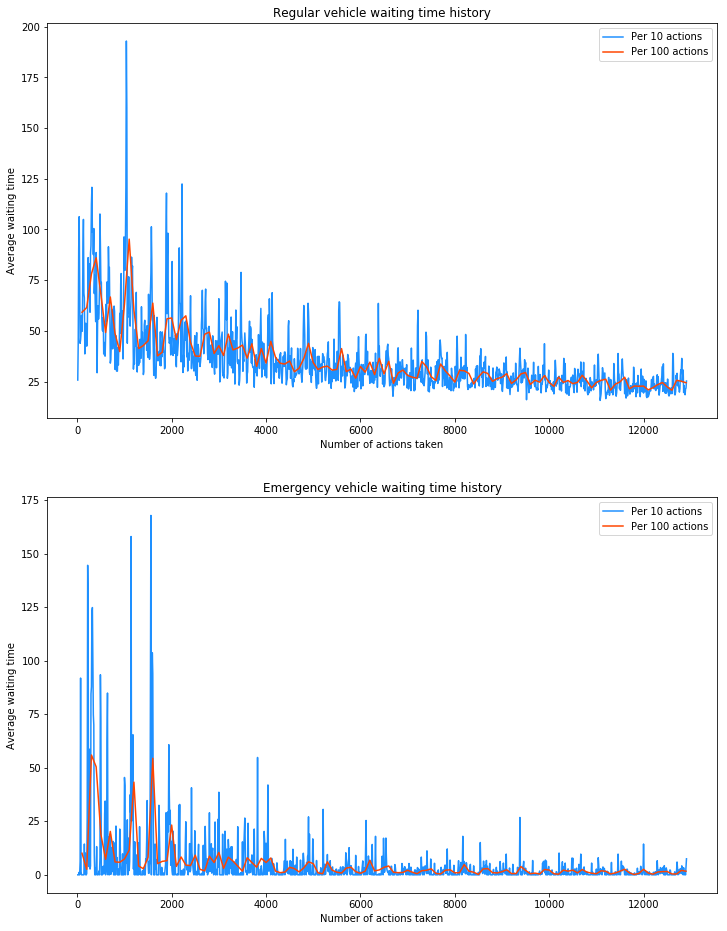

In [14]:
# vehicle average waiting time history  
fig=plt.figure()
ax = fig.add_subplot(211)
fig.set_size_inches(12,16)
plot(xaxis_per_10,regular_waiting_per_10,'Number of actions taken','Average waiting time','Regular vehicle waiting time history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,regular_waiting_per_100,'Number of actions taken','Average waiting time','Regular vehicle waiting time history',color='orangered',label='Per 100 actions')
ax = fig.add_subplot(212)
plot(xaxis_per_10,emg_waiting_per_10,'Number of actions taken','Average waiting time','Emergency vehicle waiting time history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,emg_waiting_per_100,'Number of actions taken','Average waiting time','Emergency vehicle waiting time history',color='orangered',label='Per 100 actions')

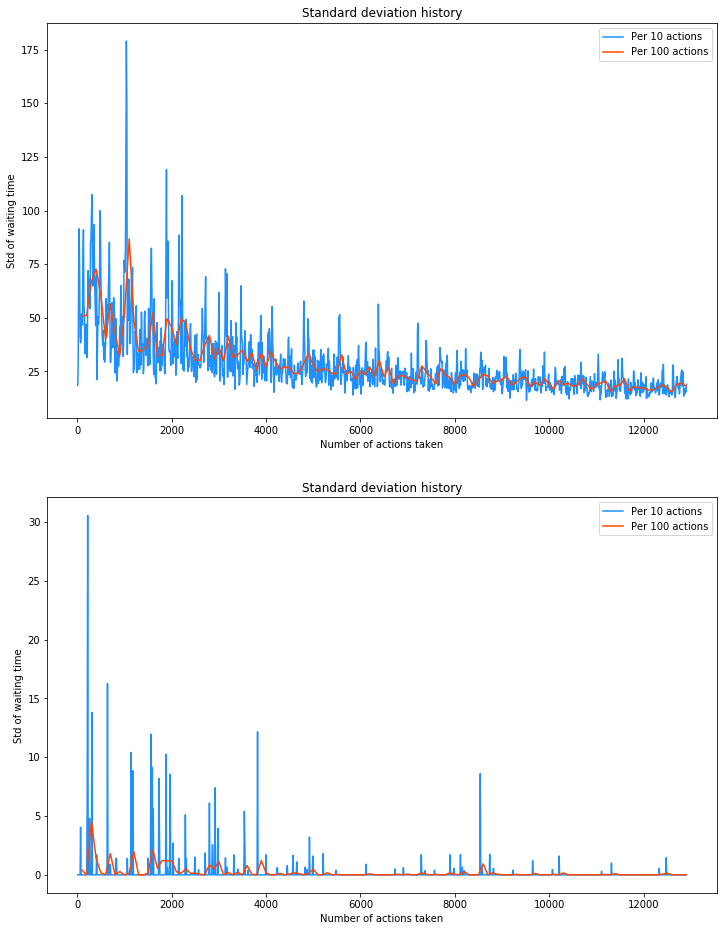

In [15]:
# vehicle waiting time std history
fig=plt.figure()
ax = fig.add_subplot(211)
fig.set_size_inches(12,16)
plot(xaxis_per_10,reg_std_per_10,'Number of actions taken','Std of waiting time','Standard deviation history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,reg_std_per_100,'Number of actions taken','Std of waiting time','Standard deviation history',color='orangered',label='Per 100 actions')
ax = fig.add_subplot(212)
plot(xaxis_per_10,emg_std_per_10,'Number of actions taken','Std of waiting time','Standard deviation history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,emg_std_per_100,'Number of actions taken','Std of waiting time','Standard deviation history',color='orangered',label='Per 100 actions')

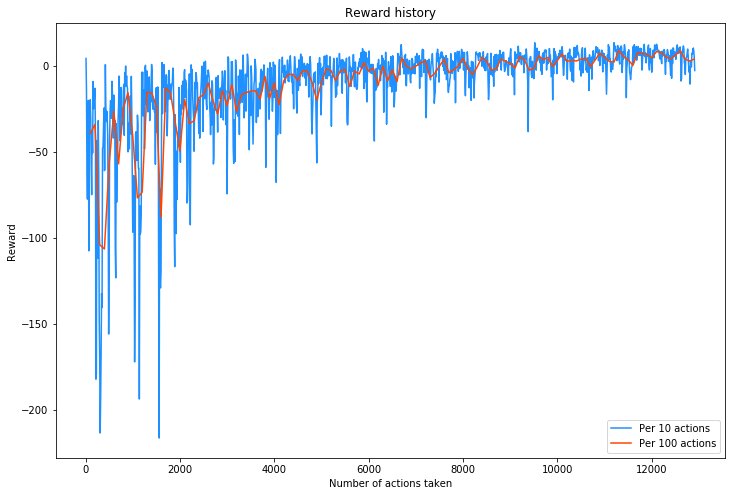

In [16]:
#reward history
fig=plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(12,8)
plot(xaxis_per_10,reward_per_10,'Number of actions taken','Reward','Reward history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,reward_per_100,'Number of actions taken','Reward','Reward history',color='orangered',label='Per 100 actions')

# Save statistics

In [17]:
regular_waiting_per_100,reg_std_per_100,emg_waiting_per_100,emg_std_per_100,reward_per_100,xaxis_per_100 = avgStatis(100)
regular_waiting_per_10,reg_std_per_10,emg_waiting_per_10,emg_std_per_10,reward_per_10,xaxis_per_10 = avgStatis(10)
file_list=['regular_waiting_per_100','reg_std_per_100','emg_waiting_per_100','emg_std_per_100','reward_per_100','xaxis_per_100','regular_waiting_per_10','reg_std_per_10','emg_waiting_per_10','emg_std_per_10','reward_per_10','xaxis_per_10']
today = datetime.now()
def saveStatistics():
    # define the name of the directory to be created
    path = "statistics/{}.{}.{}-{}.{}{}/".format(today.strftime('%Y'),today.strftime('%m'),today.strftime('%d'),today.strftime('%I'),today.strftime('%M'),today.strftime('%p'))
    os.mkdir(path)
    for file_name in file_list:
        # open output file for writing
        with open(path+'{}.txt'.format(file_name), 'w') as filehandle:
            json.dump(eval(file_name), filehandle)
saveStatistics()

# Testing

In [5]:
sumo_env=Sumo(K=0.5,Z=1)
Agent = load_model('models/avg_only/DQN.h5')
traci.start([sumo_env.getSumoBinary(gui=True), "-c", "RealWorld.sumocfg", '--start'])
count=0
step_count = 1  
action_count=[]
regular_waiting_history=[]
emergency_waiting_history=[]
regular_std_history=[]
emergency_std_history=[]
reward_history=[]

In [6]:
while traci.simulation.getMinExpectedNumber()>0:
  
        traci.simulationStep()
        sumo_env.updateWaitingTime()
        if(count % 12 == 0):#agent will make a decision at the 12th second of the current phase
            
            current_state,current_state_distribution=sumo_env.getState()
            action=np.argmax(Agent.predict(current_state)[0])
            sumo_env.changePhase(action)
            reward,regular_waiting,regular_std,emergency_waiting,emergency_std = sumo_env.reward(current_state_distribution)
            print("waiting ",regular_waiting," regular_std ",regular_std," reward ",reward)
                 
            action_count.append(step_count)

            regular_waiting_history.append(regular_waiting)
            emergency_waiting_history.append(emergency_waiting)

            regular_std_history.append(regular_std)
            emergency_std_history.append(emergency_std)     
            reward_history.append(reward)
        count+=1
            
traci.close()

waiting  0.0  regular_std  0.0  reward  30.0
waiting  0.0  regular_std  0.0  reward  30.0
waiting  0.0  regular_std  0.0  reward  30.0
waiting  0.0  regular_std  0.0  reward  30.0
waiting  4.0  regular_std  2.24  reward  26.0
waiting  8.5  regular_std  7.02  reward  21.5
waiting  14.83  regular_std  9.71  reward  15.166666666666666
waiting  18.88  regular_std  12.15  reward  11.125
waiting  24.33  regular_std  14.34  reward  5.666666666666668
waiting  15.38  regular_std  14.26  reward  14.625
waiting  12.29  regular_std  7.44  reward  17.714285714285715
waiting  20.0  regular_std  13.09  reward  10.0
waiting  16.2  regular_std  13.19  reward  13.8
waiting  25.15  regular_std  15.29  reward  4.846153846153847
waiting  25.62  regular_std  20.35  reward  4.384615384615383
waiting  22.1  regular_std  26.41  reward  7.899999999999999
waiting  12.54  regular_std  16.51  reward  17.46153846153846
waiting  14.7  regular_std  11.82  reward  15.3
waiting  23.0  regular_std  11.07  reward  7.0
wa

waiting  4.0  regular_std  2.92  reward  26.0
waiting  14.0  regular_std  7.67  reward  16.0
waiting  16.25  regular_std  8.67  reward  13.75
waiting  21.5  regular_std  7.5  reward  8.5
waiting  8.67  regular_std  7.63  reward  21.333333333333336
waiting  14.08  regular_std  10.31  reward  15.923076923076923
waiting  15.83  regular_std  11.51  reward  14.166666666666666
waiting  21.0  regular_std  15.12  reward  9.0
waiting  21.14  regular_std  18.05  reward  8.857142857142858
waiting  18.92  regular_std  18.85  reward  11.083333333333332
waiting  13.25  regular_std  11.24  reward  16.75
waiting  18.73  regular_std  10.53  reward  11.272727272727273
waiting  18.0  regular_std  13.08  reward  12.0
waiting  13.2  regular_std  13.32  reward  16.8
waiting  12.55  regular_std  9.7  reward  17.454545454545453
waiting  18.93  regular_std  12.34  reward  11.066666666666666
waiting  21.95  regular_std  16.55  reward  8.045454545454547
waiting  23.06  regular_std  19.47  reward  6.9375
waiting 

waiting  25.27  regular_std  14.82  reward  4.733333333333334
waiting  17.47  regular_std  14.44  reward  12.533333333333335
waiting  21.36  regular_std  13.02  reward  8.642857142857142
waiting  16.81  regular_std  14.33  reward  13.1875
waiting  28.15  regular_std  16.62  reward  1.8461538461538467
waiting  20.6  regular_std  14.66  reward  9.399999999999999
waiting  19.88  regular_std  16.92  reward  10.125
waiting  9.0  regular_std  8.71  reward  21.0
waiting  11.29  regular_std  10.65  reward  18.714285714285715
waiting  20.08  regular_std  15.11  reward  9.916666666666668
waiting  18.18  regular_std  12.28  reward  11.818181818181817
waiting  19.44  regular_std  12.18  reward  10.555555555555557
waiting  18.5  regular_std  15.8  reward  11.5
waiting  11.09  regular_std  9.77  reward  18.909090909090907
waiting  16.18  regular_std  13.62  reward  13.823529411764707
waiting  18.59  regular_std  13.13  reward  11.411764705882351
waiting  17.35  regular_std  10.43  reward  12.6470588

waiting  18.75  regular_std  9.68  reward  11.25
waiting  18.62  regular_std  15.81  reward  11.375
waiting  9.43  regular_std  11.82  reward  20.57142857142857
waiting  18.2  regular_std  6.71  reward  11.8
waiting  10.55  regular_std  8.65  reward  19.454545454545453
waiting  13.38  regular_std  8.18  reward  16.625
waiting  19.69  regular_std  13.38  reward  10.307692307692307
waiting  16.69  regular_std  10.57  reward  13.307692307692307
waiting  20.3  regular_std  12.3  reward  9.7
waiting  22.0  regular_std  18.79  reward  8.0
waiting  16.23  regular_std  12.36  reward  13.76923076923077
waiting  25.6  regular_std  18.45  reward  4.399999999999999
waiting  8.25  regular_std  4.94  reward  21.75
waiting  13.91  regular_std  9.42  reward  16.090909090909093
waiting  18.29  regular_std  12.88  reward  11.705882352941178
waiting  21.27  regular_std  15.45  reward  8.733333333333334
waiting  29.0  regular_std  19.68  reward  1.0
waiting  33.3  regular_std  24.41  reward  -3.2999999999

waiting  22.88  regular_std  17.83  reward  7.125
waiting  19.89  regular_std  17.62  reward  10.11111111111111
waiting  24.0  regular_std  20.17  reward  6.0
waiting  19.0  regular_std  18.07  reward  11.0
waiting  15.85  regular_std  13.72  reward  14.15
waiting  16.88  regular_std  9.75  reward  13.125
waiting  25.42  regular_std  12.95  reward  4.583333333333332
waiting  20.57  regular_std  12.77  reward  9.428571428571427
waiting  12.0  regular_std  11.95  reward  18.0
waiting  21.44  regular_std  15.07  reward  8.555555555555557
waiting  15.33  regular_std  12.61  reward  14.666666666666666
waiting  22.0  regular_std  18.49  reward  8.0
waiting  18.09  regular_std  16.57  reward  11.90909090909091
waiting  25.8  regular_std  21.69  reward  4.199999999999999
waiting  29.43  regular_std  21.64  reward  0.571428571428573
waiting  16.78  regular_std  17.75  reward  13.222222222222221
waiting  14.73  regular_std  9.35  reward  15.272727272727273
waiting  22.64  regular_std  13.73  rew

waiting  18.4  regular_std  14.77  reward  11.600000000000001
waiting  23.25  regular_std  8.84  reward  6.75
waiting  13.25  regular_std  10.29  reward  16.75
waiting  17.14  regular_std  10.22  reward  12.857142857142858
waiting  20.55  regular_std  14.1  reward  9.454545454545453
waiting  24.73  regular_std  15.9  reward  5.272727272727273
waiting  25.88  regular_std  18.56  reward  4.125
waiting  16.78  regular_std  14.22  reward  13.222222222222221
waiting  24.89  regular_std  18.28  reward  5.111111111111111
waiting  13.1  regular_std  12.89  reward  16.9
waiting  16.0  regular_std  10.6  reward  14.0
waiting  24.27  regular_std  14.1  reward  5.727272727272727
waiting  26.38  regular_std  16.15  reward  3.625
waiting  40.6  regular_std  18.6  reward  -10.600000000000001
waiting  7.33  regular_std  3.71  reward  22.666666666666668
waiting  16.22  regular_std  9.85  reward  13.777777777777779
waiting  14.71  regular_std  10.83  reward  15.285714285714286
waiting  19.8  regular_std

waiting  6.6  regular_std  4.54  reward  23.4
waiting  10.88  regular_std  7.06  reward  19.125
waiting  16.1  regular_std  11.3  reward  13.899999999999999
waiting  16.5  regular_std  13.73  reward  13.5
waiting  14.25  regular_std  11.14  reward  15.75
waiting  18.94  regular_std  15.47  reward  11.055555555555557
waiting  23.64  regular_std  14.96  reward  6.363636363636363
waiting  20.0  regular_std  12.78  reward  10.0
waiting  17.0  regular_std  11.47  reward  13.0
waiting  17.27  regular_std  12.83  reward  12.727272727272727
waiting  13.73  regular_std  12.39  reward  16.272727272727273
waiting  14.5  regular_std  11.24  reward  15.5
waiting  22.27  regular_std  11.27  reward  7.727272727272727
waiting  16.54  regular_std  17.11  reward  13.46153846153846
waiting  21.0  regular_std  13.45  reward  9.0
waiting  27.7  regular_std  18.79  reward  2.3000000000000007
waiting  18.78  regular_std  17.87  reward  11.222222222222221
waiting  19.17  regular_std  16.44  reward  10.8333333

waiting  19.5  regular_std  11.93  reward  10.5
waiting  20.4  regular_std  15.4  reward  9.600000000000001
waiting  12.22  regular_std  9.7  reward  17.77777777777778
waiting  20.0  regular_std  13.25  reward  10.0
waiting  9.5  regular_std  8.2  reward  20.5
waiting  13.58  regular_std  6.95  reward  16.416666666666664
waiting  18.56  regular_std  12.59  reward  11.444444444444443
waiting  17.08  regular_std  16.64  reward  12.916666666666668
waiting  17.44  regular_std  13.87  reward  12.555555555555557
waiting  19.7  regular_std  13.23  reward  10.3
waiting  28.0  regular_std  11.27  reward  2.0
waiting  25.8  regular_std  17.5  reward  4.199999999999999
waiting  17.0  regular_std  9.42  reward  13.0
waiting  12.0  regular_std  13.38  reward  18.0
waiting  13.77  regular_std  8.41  reward  16.23076923076923
waiting  19.33  regular_std  12.11  reward  10.666666666666668
waiting  22.62  regular_std  16.11  reward  7.375
waiting  18.91  regular_std  13.53  reward  11.09090909090909
wa

waiting  19.5  regular_std  18.27  reward  10.5
waiting  17.64  regular_std  12.82  reward  12.357142857142858
waiting  19.15  regular_std  14.23  reward  10.846153846153847
waiting  21.08  regular_std  18.34  reward  8.916666666666668
waiting  13.0  regular_std  9.97  reward  17.0
waiting  8.08  regular_std  6.5  reward  21.923076923076923
waiting  16.53  regular_std  9.05  reward  13.466666666666665
waiting  17.94  regular_std  14.39  reward  12.058823529411764
waiting  17.58  regular_std  16.15  reward  12.421052631578949
waiting  19.32  regular_std  10.48  reward  10.684210526315791
waiting  21.44  regular_std  15.07  reward  8.555555555555557
waiting  18.8  regular_std  17.76  reward  11.2
waiting  21.74  regular_std  16.64  reward  8.263157894736842
waiting  21.14  regular_std  14.87  reward  8.857142857142858
waiting  17.53  regular_std  14.73  reward  12.473684210526315
waiting  22.65  regular_std  13.61  reward  7.350000000000001
waiting  24.61  regular_std  18.33  reward  5.3

waiting  19.73  regular_std  18.44  reward  10.266666666666666
waiting  18.5  regular_std  18.35  reward  11.5
waiting  15.69  regular_std  10.9  reward  14.3125
waiting  16.12  regular_std  11.74  reward  13.875
waiting  21.3  regular_std  16.01  reward  8.7
waiting  20.14  regular_std  16.87  reward  9.863636363636363
waiting  25.59  regular_std  20.3  reward  4.4117647058823515
waiting  19.54  regular_std  16.2  reward  10.46153846153846
waiting  19.82  regular_std  14.26  reward  10.181818181818183
waiting  23.7  regular_std  13.42  reward  6.300000000000001
waiting  23.55  regular_std  18.49  reward  6.454545454545453
waiting  25.79  regular_std  23.08  reward  4.214285714285715
waiting  21.07  regular_std  22.16  reward  8.933333333333334
waiting  27.5  regular_std  28.49  reward  2.5
waiting  14.36  regular_std  10.11  reward  15.636363636363637
waiting  21.44  regular_std  13.13  reward  8.555555555555557
waiting  21.5  regular_std  15.12  reward  8.5
waiting  34.5  regular_std

waiting  15.09  regular_std  10.79  reward  14.909090909090908
waiting  16.6  regular_std  13.83  reward  13.399999999999999
waiting  18.6  regular_std  5.46  reward  11.399999999999999
waiting  20.67  regular_std  15.49  reward  9.333333333333332
waiting  6.33  regular_std  4.92  reward  23.666666666666668
waiting  18.12  regular_std  7.22  reward  11.875
waiting  27.5  regular_std  12.18  reward  2.5
waiting  16.11  regular_std  16.71  reward  13.88888888888889
waiting  18.0  regular_std  10.53  reward  12.0
waiting  17.27  regular_std  16.71  reward  12.727272727272727
waiting  21.91  regular_std  19.3  reward  8.09090909090909
waiting  21.91  regular_std  16.92  reward  8.09090909090909
waiting  16.33  regular_std  14.84  reward  13.666666666666668
waiting  23.11  regular_std  19.59  reward  6.888888888888889
waiting  18.83  regular_std  17.47  reward  11.166666666666668
waiting  16.38  regular_std  12.36  reward  13.625
waiting  20.69  regular_std  14.43  reward  9.307692307692307

waiting  16.17  regular_std  10.73  reward  13.833333333333332
waiting  8.8  regular_std  4.83  reward  21.2
waiting  9.71  regular_std  6.32  reward  20.285714285714285
waiting  15.62  regular_std  9.47  reward  14.375
waiting  25.4  regular_std  17.47  reward  4.600000000000001
waiting  14.78  regular_std  13.27  reward  15.222222222222221
waiting  17.36  regular_std  17.44  reward  12.636363636363637
waiting  13.9  regular_std  12.05  reward  16.1
waiting  16.12  regular_std  15.23  reward  13.882352941176471
waiting  16.58  regular_std  15.42  reward  13.416666666666668
waiting  15.08  regular_std  9.56  reward  14.923076923076923
waiting  15.09  regular_std  14.66  reward  14.909090909090908
waiting  13.92  regular_std  15.88  reward  16.083333333333336
waiting  16.43  regular_std  8.76  reward  13.571428571428573
waiting  22.38  regular_std  14.41  reward  7.615384615384617
waiting  16.0  regular_std  18.53  reward  14.0
waiting  18.7  regular_std  16.36  reward  11.3
waiting  16

waiting  19.17  regular_std  7.88  reward  10.833333333333332
waiting  18.89  regular_std  16.47  reward  11.11111111111111
waiting  23.78  regular_std  16.78  reward  6.222222222222221
waiting  18.09  regular_std  12.3  reward  11.90909090909091
waiting  16.85  regular_std  13.14  reward  13.153846153846153
waiting  18.64  regular_std  11.16  reward  11.363636363636363
waiting  17.33  regular_std  12.54  reward  12.666666666666668
waiting  10.45  regular_std  5.66  reward  19.545454545454547
waiting  24.75  regular_std  6.67  reward  5.25
waiting  11.12  regular_std  11.78  reward  18.875
waiting  17.17  regular_std  14.21  reward  12.833333333333332
waiting  16.17  regular_std  12.24  reward  13.833333333333332
waiting  25.0  regular_std  15.26  reward  5.0
waiting  30.25  regular_std  18.53  reward  -0.25
waiting  22.11  regular_std  20.36  reward  7.888888888888889
waiting  10.88  regular_std  10.01  reward  19.125
waiting  12.3  regular_std  7.0  reward  17.7
waiting  17.2  regula

waiting  18.25  regular_std  10.96  reward  11.75
waiting  18.25  regular_std  16.5  reward  11.75
waiting  17.77  regular_std  12.01  reward  12.23076923076923
waiting  22.42  regular_std  16.55  reward  7.583333333333332
waiting  19.62  regular_std  14.88  reward  10.384615384615383
waiting  27.33  regular_std  14.19  reward  2.666666666666668
waiting  12.62  regular_std  13.46  reward  17.375
waiting  15.9  regular_std  12.23  reward  14.1
waiting  15.14  regular_std  10.86  reward  14.857142857142858
waiting  23.25  regular_std  13.25  reward  6.75
waiting  27.83  regular_std  13.2  reward  2.166666666666668
waiting  20.1  regular_std  17.36  reward  9.899999999999999
waiting  12.89  regular_std  8.27  reward  17.11111111111111
waiting  12.91  regular_std  12.32  reward  17.090909090909093
waiting  18.18  regular_std  11.91  reward  11.818181818181817
waiting  15.67  regular_std  11.69  reward  14.333333333333334
waiting  13.43  regular_std  7.82  reward  16.57142857142857
waiting 

waiting  21.14  regular_std  17.68  reward  8.857142857142858
waiting  16.69  regular_std  14.58  reward  13.3125
waiting  19.19  regular_std  16.93  reward  10.80952380952381
waiting  22.7  regular_std  19.38  reward  7.300000000000001
waiting  23.14  regular_std  18.65  reward  6.857142857142858
waiting  17.0  regular_std  13.18  reward  13.0
waiting  22.13  regular_std  18.77  reward  7.866666666666667
waiting  20.83  regular_std  10.82  reward  9.166666666666668
waiting  25.85  regular_std  16.97  reward  4.153846153846153
waiting  21.92  regular_std  19.01  reward  8.083333333333332
waiting  19.54  regular_std  22.58  reward  10.46153846153846
waiting  22.0  regular_std  19.45  reward  8.0
waiting  16.75  regular_std  10.3  reward  13.25
waiting  27.89  regular_std  12.74  reward  2.1111111111111107
waiting  16.31  regular_std  16.59  reward  13.692307692307693
waiting  16.83  regular_std  7.74  reward  13.166666666666668
waiting  14.0  regular_std  12.74  reward  16.0
waiting  17

waiting  24.17  regular_std  19.3  reward  5.833333333333332
waiting  20.64  regular_std  15.85  reward  9.363636363636363
waiting  19.0  regular_std  13.71  reward  11.0
waiting  12.67  regular_std  12.87  reward  17.333333333333336
waiting  14.1  regular_std  10.48  reward  15.9
waiting  16.62  regular_std  14.34  reward  13.384615384615383
waiting  20.21  regular_std  13.65  reward  9.785714285714285
waiting  17.43  regular_std  12.95  reward  12.571428571428573
waiting  18.14  regular_std  16.49  reward  11.857142857142858
waiting  19.0  regular_std  20.5  reward  11.0
waiting  28.4  regular_std  23.04  reward  1.6000000000000014
waiting  22.4  regular_std  20.3  reward  7.600000000000001
waiting  16.45  regular_std  10.9  reward  13.545454545454547
waiting  14.82  regular_std  12.41  reward  15.181818181818182
waiting  15.57  regular_std  13.21  reward  14.428571428571429
waiting  27.08  regular_std  16.22  reward  2.9230769230769234
waiting  27.08  regular_std  17.45  reward  2.9

waiting  17.6  regular_std  13.6  reward  12.399999999999999
waiting  17.23  regular_std  12.14  reward  12.76923076923077
waiting  19.47  regular_std  17.23  reward  10.533333333333335
waiting  14.07  regular_std  10.03  reward  15.928571428571429
waiting  21.2  regular_std  13.93  reward  8.8
waiting  20.87  regular_std  15.74  reward  9.133333333333333
waiting  26.15  regular_std  18.5  reward  3.8461538461538467
waiting  18.0  regular_std  13.3  reward  12.0
waiting  14.33  regular_std  12.38  reward  15.666666666666666
waiting  17.9  regular_std  15.98  reward  12.100000000000001
waiting  18.44  regular_std  14.63  reward  11.555555555555557
waiting  17.0  regular_std  12.22  reward  13.0
waiting  17.67  regular_std  14.78  reward  12.333333333333332
waiting  21.75  regular_std  18.18  reward  8.25
waiting  17.36  regular_std  15.3  reward  12.636363636363637
waiting  17.23  regular_std  10.25  reward  12.76923076923077
waiting  13.73  regular_std  11.35  reward  16.26666666666666

waiting  9.67  regular_std  6.49  reward  20.333333333333336
waiting  18.69  regular_std  10.09  reward  11.307692307692307
waiting  22.43  regular_std  15.73  reward  7.571428571428573
waiting  18.43  regular_std  18.65  reward  11.571428571428573
waiting  21.86  regular_std  22.2  reward  8.142857142857142
waiting  17.93  regular_std  22.58  reward  12.071428571428573
waiting  18.8  regular_std  13.93  reward  11.2
waiting  20.16  regular_std  13.28  reward  9.842105263157894
waiting  19.13  regular_std  14.5  reward  10.866666666666667
waiting  21.7  regular_std  14.18  reward  8.3
waiting  19.5  regular_std  15.41  reward  10.5
waiting  11.12  regular_std  9.02  reward  18.875
waiting  19.89  regular_std  11.26  reward  10.11111111111111
waiting  16.57  regular_std  13.72  reward  13.428571428571427
waiting  18.27  regular_std  14.13  reward  11.733333333333334
waiting  18.62  regular_std  13.85  reward  11.384615384615383
waiting  15.08  regular_std  9.38  reward  14.9230769230769

waiting  17.44  regular_std  14.24  reward  12.555555555555557
waiting  12.12  regular_std  10.73  reward  17.875
waiting  17.5  regular_std  13.34  reward  12.5
waiting  23.8  regular_std  14.63  reward  6.199999999999999
waiting  16.42  regular_std  12.26  reward  13.583333333333332
waiting  19.77  regular_std  15.22  reward  10.23076923076923
waiting  20.0  regular_std  15.13  reward  10.0
waiting  19.6  regular_std  16.84  reward  10.399999999999999
waiting  8.75  regular_std  5.12  reward  21.25
waiting  12.33  regular_std  10.84  reward  17.666666666666664
waiting  9.56  regular_std  7.15  reward  20.444444444444443
waiting  16.3  regular_std  11.66  reward  13.7
waiting  22.38  regular_std  15.03  reward  7.625
waiting  12.0  regular_std  9.84  reward  18.0
waiting  9.92  regular_std  8.19  reward  20.076923076923077
waiting  16.8  regular_std  7.98  reward  13.2
waiting  32.8  regular_std  7.33  reward  -2.799999999999997
waiting  24.0  regular_std  18.59  reward  6.0
waiting  

waiting  23.83  regular_std  18.72  reward  6.166666666666668
waiting  17.09  regular_std  17.8  reward  12.90909090909091
waiting  17.25  regular_std  11.14  reward  12.75
waiting  21.83  regular_std  14.24  reward  8.166666666666668
waiting  24.18  regular_std  15.97  reward  5.8235294117647065
waiting  26.35  regular_std  15.84  reward  3.647058823529413
waiting  23.48  regular_std  15.54  reward  6.5238095238095255
waiting  34.11  regular_std  16.3  reward  -4.111111111111114
waiting  37.77  regular_std  24.85  reward  -7.7692307692307665
waiting  19.69  regular_std  19.25  reward  10.307692307692307
waiting  28.08  regular_std  23.36  reward  1.9230769230769234
waiting  37.55  regular_std  25.77  reward  -7.545454545454547
waiting  30.75  regular_std  20.75  reward  -0.75
waiting  20.83  regular_std  24.86  reward  9.166666666666668
waiting  13.67  regular_std  12.7  reward  16.333333333333336
waiting  16.0  regular_std  13.99  reward  14.0
waiting  20.31  regular_std  16.06  rewa

waiting  19.75  regular_std  9.61  reward  10.25
waiting  19.41  regular_std  14.5  reward  10.588235294117649
waiting  21.36  regular_std  14.93  reward  8.642857142857142
waiting  24.67  regular_std  19.26  reward  5.333333333333332
waiting  21.07  regular_std  15.45  reward  8.928571428571427
waiting  22.81  regular_std  19.89  reward  7.1875
waiting  21.24  regular_std  11.62  reward  8.764705882352942
waiting  28.24  regular_std  13.83  reward  1.764705882352942
waiting  27.25  regular_std  20.29  reward  2.75
waiting  25.5  regular_std  23.84  reward  4.5
waiting  17.62  regular_std  14.23  reward  12.384615384615383
waiting  20.13  regular_std  18.11  reward  9.866666666666667
waiting  22.67  regular_std  23.06  reward  7.333333333333332
waiting  23.62  regular_std  16.23  reward  6.384615384615383
waiting  24.1  regular_std  16.4  reward  5.899999999999999
waiting  13.46  regular_std  17.71  reward  16.53846153846154
waiting  16.71  regular_std  10.19  reward  13.28571428571428

waiting  34.07  regular_std  25.98  reward  -4.06666666666667
waiting  43.5  regular_std  28.67  reward  -13.5
waiting  40.67  regular_std  39.35  reward  -10.666666666666664
waiting  24.36  regular_std  20.65  reward  5.636363636363637
waiting  21.0  regular_std  20.14  reward  9.0
waiting  17.11  regular_std  25.92  reward  12.88888888888889
waiting  9.78  regular_std  7.71  reward  20.22222222222222
waiting  13.77  regular_std  9.53  reward  16.23076923076923
waiting  17.69  regular_std  12.68  reward  12.307692307692307
waiting  22.81  regular_std  18.28  reward  7.1875
waiting  23.65  regular_std  17.59  reward  6.352941176470587
waiting  24.92  regular_std  14.0  reward  5.083333333333332
waiting  21.11  regular_std  17.44  reward  8.894736842105264
waiting  27.33  regular_std  21.22  reward  2.666666666666668
waiting  29.56  regular_std  27.85  reward  0.4375
waiting  19.08  regular_std  12.98  reward  10.916666666666668
waiting  17.06  regular_std  18.61  reward  12.9375
waitin

waiting  18.69  regular_std  15.71  reward  11.307692307692307
waiting  17.25  regular_std  12.52  reward  12.75
waiting  15.0  regular_std  15.27  reward  15.0
waiting  14.65  regular_std  11.72  reward  15.352941176470589
waiting  20.08  regular_std  12.33  reward  9.923076923076923
waiting  25.08  regular_std  14.64  reward  4.916666666666668
waiting  22.83  regular_std  13.8  reward  7.166666666666668
waiting  17.33  regular_std  15.21  reward  12.666666666666668
waiting  23.62  regular_std  16.62  reward  6.375
waiting  14.91  regular_std  13.63  reward  15.090909090909092
waiting  11.38  regular_std  11.22  reward  18.615384615384613
waiting  18.15  regular_std  15.3  reward  11.846153846153847
waiting  18.67  regular_std  14.05  reward  11.333333333333332
waiting  15.79  regular_std  10.65  reward  14.214285714285714
waiting  21.73  regular_std  10.91  reward  8.272727272727273
waiting  22.11  regular_std  14.21  reward  7.888888888888889
waiting  14.7  regular_std  13.94  rewar

waiting  21.0  regular_std  11.44  reward  9.0
waiting  19.45  regular_std  15.64  reward  10.545454545454547
waiting  24.0  regular_std  10.88  reward  6.0
waiting  21.45  regular_std  17.99  reward  8.545454545454547
waiting  26.42  regular_std  19.99  reward  3.583333333333332
waiting  24.6  regular_std  15.27  reward  5.399999999999999
waiting  19.46  regular_std  21.07  reward  10.53846153846154
waiting  23.11  regular_std  11.13  reward  6.888888888888889
waiting  20.0  regular_std  15.95  reward  10.0
waiting  26.31  regular_std  18.2  reward  3.6923076923076934
waiting  16.5  regular_std  12.94  reward  13.5
waiting  11.17  regular_std  10.22  reward  18.833333333333336
waiting  14.8  regular_std  12.85  reward  15.2
waiting  18.2  regular_std  14.06  reward  11.8
waiting  29.29  regular_std  21.24  reward  0.7142857142857153
waiting  33.4  regular_std  12.82  reward  -3.3999999999999986
waiting  15.0  regular_std  15.9  reward  15.0
waiting  10.25  regular_std  8.04  reward  1

FatalTraCIError: connection closed by SUMO

In [7]:
regular_waiting_per_100,reg_std_per_100,emg_waiting_per_100,emg_std_per_100,reward_per_100,xaxis_per_100 = avgStatis(100)
regular_waiting_per_10,reg_std_per_10,emg_waiting_per_10,emg_std_per_10,reward_per_10,xaxis_per_10 = avgStatis(10)

In [8]:

file_list=['regular_waiting_per_100','reg_std_per_100','emg_waiting_per_100','emg_std_per_100','reward_per_100','xaxis_per_100','regular_waiting_per_10','reg_std_per_10','emg_waiting_per_10','emg_std_per_10','reward_per_10','xaxis_per_10']
today = datetime.now()
def saveStatistics():
    # define the name of the directory to be created
    path = "statistics/Testing/{}.{}.{}-{}.{}{}/".format(today.strftime('%Y'),today.strftime('%m'),today.strftime('%d'),today.strftime('%I'),today.strftime('%M'),today.strftime('%p'))
    os.mkdir(path)
    for file_name in file_list:
        # open output file for writing
        with open(path+'{}.txt'.format(file_name), 'w') as filehandle:
            json.dump(eval(file_name), filehandle)
saveStatistics()

In [ ]:
# vehicle average waiting time history  
fig=plt.figure()
ax = fig.add_subplot(211)
fig.set_size_inches(12,16)
plot(xaxis_per_10,regular_waiting_per_10,'Number of actions taken','Average waiting time','Regular vehicle waiting time history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,regular_waiting_per_100,'Number of actions taken','Average waiting time','Regular vehicle waiting time history',color='orangered',label='Per 100 actions')
ax = fig.add_subplot(212)
plot(xaxis_per_10,emg_waiting_per_10,'Number of actions taken','Average waiting time','Emergency vehicle waiting time history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,emg_waiting_per_100,'Number of actions taken','Average waiting time','Emergency vehicle waiting time history',color='orangered',label='Per 100 actions')